In [1]:
import os
import time
import math
import random
import shutil
import contextlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as data
import torchvision.transforms as transforms

from utils.converter import LabelConverter, IndexConverter
from datasets.dataset import InMemoryDigitsDataset, DigitsDataset, collate_train, collate_dev, inmemory_train, inmemory_dev
from generate import gen_text_img

import arguments
from models.densenet_ import DenseNet

import warnings
warnings.filterwarnings("always")

In [2]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()

    for i, sample in enumerate(train_loader):
        # Measure data loading time
        data_time.update(time.time() - end)

        # Zero out gradients so we can accumulate new ones over batches
        optimizer.zero_grad()

        # step 2. Get our inputs targets ready for the network.
        # targets is a list of `torch.IntTensor` with `batch_size` size.
        target_lengths = sample.target_lengths.to(device)
        targets = sample.targets # Expected targets to have CPU Backend

        # step 3. Run out forward pass.
        images = sample.images
        if isinstance(images, tuple):
            targets = targets.to(device)
            log_probs = []
            for image in images:
                image = image.unsqueeze(0).to(device)
                log_prob = model(image).squeeze(1)
                log_probs.append(log_prob)
            input_lengths = torch.IntTensor([i.size(0) for i in log_probs]).to(device)
            log_probs = pad_sequence(log_probs)
        else: # Batch
            images = images.to(device)
            log_probs = model(images)
#             log_probs = F.log_softmax(log_probs, dim=2)
#             log_probs = log_probs.permute(1,0,2)
            input_lengths = torch.full((images.size(0),), log_probs.size(0), dtype=torch.int32, device=device)
        # step 4. Compute the loss, gradients, and update the parameters
        # by calling optimizer.step()
        loss = criterion(log_probs, targets, input_lengths, target_lengths)
        losses.update(loss.item())
        loss.backward()

        # do one step for multiple batches
        # accumulated gradients are used
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if (i+1) % args.print_freq == 0 or i == 0 or (i+1) == len(train_loader):
            print('>> Train: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(
                   epoch+1, i+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))

    return losses.avg


In [3]:
def validate(dev_loader, model, epoch, converter):
    batch_time = AverageMeter()
    accuracy = AverageMeter()

    # switch to evaluate mode
    model.eval()

    num_correct = 0
    num_verified = 0
    end = time.time()

    #for i, (images, targets) in enumerate(dev_loader):
    for i, sample in enumerate(dev_loader):
        images = sample.images
        targets = sample.targets
        if isinstance(images, tuple):
            preds = []
            for image in images:
                image = image.unsqueeze(0).to(device)
                log_prob = model(image)
                preds.append(converter.best_path_decode(log_prob, strings=False))
        else: # Batch
            images = images.to(device)
            log_probs = model(images)
            preds = converter.best_path_decode(log_probs, strings=False)

        # measure elapsed time
        print(log_probs)
        batch_time.update(time.time() - end)
        end = time.time()
        for i in range(len(targets)):
             num_verified += len(targets[i])
#         print(num_verified)
        for pred, target in zip(preds, targets):
            print(pred)
            print(target)
            for i in range(min(len(target),len(pred))):
                if target[i]==pred[i]:
                    num_correct += 1
#         print(num_correct)
        accuracy.update(num_correct / num_verified) # character
                
        for i in range(len(preds)):
            pred = converter.best_path_decode(log_probs, strings=True)[i].decode('utf-8')
            print('pred: {}'.format(pred))

        if (i+1) % args.print_freq == 0 or i == 0 or (i+1) == len(dev_loader):
            print('>> Val: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Accu {accuracy.val:.3f}'.format(
                   epoch+1, i+1, len(dev_loader), batch_time=batch_time, accuracy=accuracy))

    return accuracy.val


In [4]:
def save_checkpoint(state, is_best, directory):
    filename = os.path.join(directory, '{}_epoch_{}.pth.tar'.format(state['arch'], state['epoch']))
    with contextlib.suppress(FileNotFoundError):
        os.remove(filename)
    torch.save(state, filename)
    if is_best:
        print('>>>> save best model at epoch: {}'.format(state['epoch']))
        filename_best = os.path.join(directory, '{}_best.pth.tar'.format(state['arch']))
        with contextlib.suppress(FileNotFoundError):
            os.remove(filename_best)
        shutil.copyfile(filename, filename_best)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def set_batchnorm_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        # freeze running mean and std:
        # we do training one image at a time
        # so the statistics would not be per batch
        # hence we choose freezing (ie using imagenet statistics)
        m.eval()
        # # freeze parameters:
        # # in fact no need to freeze scale and bias
        # # they can be learned
        # # that is why next two lines are commented
        # for p in m.parameters():
            # p.requires_grad = False

In [25]:
import sys
# alphabet/alphabet_decode_5990.txt
sys.argv = ['main.py','--dataset-root','alphabet','--arch','densenet121','--alphabet','alphabet/alphabet_decode_5990.txt',
            '--lr','5e-5','--max-epoch','20','--optimizer','sgd','--gpu-id','-1','--not-pretrained']

In [15]:
args = arguments.parse_args()

if args.gpu_id < 0:
    device = torch.device("cpu")
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True

# create export dir if it doesnt exist
directory = "{}".format(args.arch)
directory += "_{}_lr{:.1e}_wd{:.1e}".format(args.optimizer, args.lr, args.weight_decay)
directory += "_bsize{}_imsize{}".format(args.batch_size, args.image_size)

args.directory = os.path.join(args.directory, directory)
print(">> Creating directory if it does not exist:\n>> '{}'".format(args.directory))
if not os.path.exists(args.directory):
    os.makedirs(args.directory)

# initialize model
if args.pretrained:
    print(">> Using pre-trained model '{}'".format(args.arch))
else:
    print(">> Using model from scratch (random weights) '{}'".format(args.arch))

# load alphabet from file
if os.path.isfile(args.alphabet):
    alphabet = ''
    with open(args.alphabet, mode='r', encoding='utf-8') as f:
        for line in f.readlines():
            alphabet += line.strip()
    args.alphabet = alphabet

model = DenseNet(num_classes=len(args.alphabet) + 1)

if args.pretrained:
    model_path = 'pretrained/new_prarams.pth'
    checkpoint = torch.load(model_path,map_location = 'cpu')
    model.load_state_dict(checkpoint)

transform = transforms.Compose([
    transforms.Resize((32, 280)),
    transforms.ToTensor(),
])

>> Creating directory if it does not exist:
>> './checkpoint/densenet121_rmsprop_lr5.0e-05_wd5.0e-04_bsize64_imsize32'
>> Using model from scratch (random weights) 'densenet121'


In [26]:
# define loss function
criterion = nn.CTCLoss()
criterion = criterion.to(device)

# define optimizer
if args.optimizer == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
elif args.optimizer == 'rmsprop':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
elif args.optimizer == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

converter = LabelConverter(args.alphabet, ignore_case=False)

# define learning rate decay schedule
# TODO: maybe pass as argument in future implementation?
# exp_decay = math.exp(-0.1)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=exp_decay)

acc = []
losses = []
times = []
start_time = time.time()

In [27]:
from datasets.dataset import InMemoryDigitsDataset, DigitsDataset, collate_train, collate_dev, inmemory_train, inmemory_dev

num = 100
dev_num = num
use_file = 1
text = "十四二"
text_length = 1
font_size = 32
font_id = 1
space_width = 1
text_color = '#282828'
thread_count = 8
channel = 3

random_skew = True
skew_angle = 0
random_blur = True
blur = 0

orientation = 0
distorsion = 0
distorsion_orientation = 0
background = 1

random_process = False
noise = 0
erode = 0
dilate = 0
incline = 0

In [29]:
for i in range(30):
    text_meta, text_img = gen_text_img(num, use_file, text, text_length, font_size, font_id, space_width, background, text_color,
                                      orientation, blur, random_blur, distorsion, distorsion_orientation, skew_angle, random_skew,
                                      random_process, noise, erode, dilate, incline,
                                      thread_count, channel)
    #     dev_meta, dev_img = gen_text_img(dev_num, use_file, text, text_length, font_size, font_id, space_width, background, text_color,
    #                               orientation, blur, random_blur, distorsion, distorsion_orientation, skew_angle, random_skew,
    #                               thread_count)
    dev_meta, dev_img = text_meta, text_img

    index_converter = IndexConverter(args.alphabet, ignore_case=False)

    train_dataset = InMemoryDigitsDataset(mode='train',text=text_meta,img=text_img,total=num,
                                      transform=transform, converter = index_converter)
    dev_dataset = InMemoryDigitsDataset(mode='dev', text=dev_meta, img=dev_img, total=dev_num,
                                    transform=transform, converter = index_converter)

    train_loader = data.DataLoader(train_dataset, batch_size=args.batch_size, collate_fn=collate_train,
                               shuffle=True, num_workers=args.workers, pin_memory=True)
    dev_loader = data.DataLoader(dev_dataset, batch_size=args.batch_size, collate_fn=collate_dev,
                             shuffle=False, num_workers=args.workers, pin_memory=True)
    
    for i, sample in enumerate(train_loader):
        print(sample.targets.shape)
    
    is_best = False
    best_accuracy = 0.0
    accuracy = 0.0
    start_epoch = 0
    
    for epoch in range(start_epoch, args.max_epoch):
        if args.test_only:
            args.max_epoch = 1
            print('>>>> Test model, using model at epoch: {}'.format(start_epoch))
            start_epoch -= 1
            with torch.no_grad():
                accuracy = validate(dev_loader, model, start_epoch, converter)
            acc.append(format(accuracy))
            print('>>>> Accuracy: {}'.format(accuracy))
        else:
            # aujust learning rate for each epoch
#             scheduler.step()

            # train for one epoch on train set
            loss = train(train_loader, model, criterion, optimizer, epoch)
            losses.append(format(loss))
            # evaluate on validation set
            if (epoch + 1) % args.validate_interval == 0:
                with torch.no_grad():
                    accuracy = validate(dev_loader, model, epoch, converter)

            # # evaluate on test datasets every test_freq epochs
            # if (epoch + 1) % args.test_freq == 0:
            #     with torch.no_grad():
            #         test(args.test_datasets, model)

            # remember best accuracy and save checkpoint
            is_best = accuracy > 0.0 and accuracy >= best_accuracy
            best_accuracy = max(accuracy, best_accuracy)
            acc.append(format(accuracy))
            print('>>>> Accuracy: {}'.format(accuracy))

            if (epoch + 1) % args.save_interval == 0:
                save_checkpoint({
                    'arch': args.arch,
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'best_accuracy': best_accuracy,


                    'optimizer' : optimizer.state_dict(),
                }, is_best, args.directory)
            if best_accuracy == 1:
                break
    end_time = time.time()
    times.append(end_time-start_time)


torch.Size([64])
torch.Size([36])
>> Train: [1][1/2]	Time 6.690 (6.690)	Data 0.170 (0.170)	Loss 7.6121 (7.6121)
>> Train: [1][2/2]	Time 3.366 (5.028)	Data 0.001 (0.086)	Loss 7.6234 (7.6178)
tensor([[[ -0.0949, -11.3660, -11.2259,  ..., -11.8093, -11.4904, -11.2929],
         [ -0.0963, -11.3465, -11.2073,  ..., -11.7923, -11.4743, -11.2747],
         [ -0.0963, -11.3465, -11.2073,  ..., -11.7923, -11.4743, -11.2747],
         ...,
         [ -0.0949, -11.3660, -11.2259,  ..., -11.8093, -11.4904, -11.2929],
         [ -0.0963, -11.3465, -11.2073,  ..., -11.7923, -11.4743, -11.2748],
         [ -0.0963, -11.3465, -11.2073,  ..., -11.7923, -11.4743, -11.2747]],

        [[ -0.0832, -11.4476, -11.2664,  ..., -11.9315, -11.6213, -11.4468],
         [ -0.0840, -11.4268, -11.2720,  ..., -11.9095, -11.6117, -11.4318],
         [ -0.0840, -11.4268, -11.2720,  ..., -11.9096, -11.6117, -11.4319],
         ...,
         [ -0.0832, -11.4476, -11.2664,  ..., -11.9315, -11.6213, -11.4468],
         [

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0972, -11.3384, -11.1999,  ..., -11.7857, -11.4663, -11.2681],
         [ -0.0972, -11.3384, -11.1999,  ..., -11.7857, -11.4663, -11.2681],
         [ -0.0972, -11.3384, -11.1999,  ..., -11.7857, -11.4663, -11.2681],
         ...,
         [ -0.0958, -11.3579, -11.2184,  ..., -11.8026, -11.4823, -11.2864],
         [ -0.0972, -11.3384, -11.1999,  ..., -11.7857, -11.4663, -11.2681],
         [ -0.0972, -11.3384, -11.1999,  ..., -11.7857, -11.4663, -11.2681]],

        [[ -0.0828, -11.4437, -11.2903,  ..., -11.9291, -11.6305, -11.4499],
         [ -0.0828, -11.4

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [4][1/2]	Time 6.562 (6.562)	Data 0.158 (0.158)	Loss 7.4057 (7.4057)
>> Train: [4][2/2]	Time 3.354 (4.958)	Data 0.000 (0.079)	Loss 7.3782 (7.3919)
tensor([[[ -0.0958, -11.3591, -11.2187,  ..., -11.8056, -11.4836, -11.2895],
         [ -0.0978, -11.3347, -11.1955,  ..., -11.7835, -11.4621, -11.2656],
         [ -0.0978, -11.3348, -11.1955,  ..., -11.7835, -11.4621, -11.2656],
         ...,
         [ -0.0958, -11.3591, -11.2187,  ..., -11.8056, -11.4836, -11.2895],
         [ -0.0978, -11.3348, -11.1956,  ..., -11.7835, -11.4621, -11.2657],
         [ -0.0978, -11.3348, -11.1955,  ..., -11.7835, -11.4621, -11.2656]],

        [[ -0.0820, -11.4676, -11.2868,  ..., -11.9548, -11.6417, -11.4696],
         [ -0.0857, -11.4106, -11.2582,  ..., -11.8962, -11.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0925, -11.3965, -11.2536,  ..., -11.8443, -11.5253, -11.3276],
         [ -0.0925, -11.3965, -11.2536,  ..., -11.8443, -11.5252, -11.3276],
         [ -0.0925, -11.3965, -11.2536,  ..., -11.8443, -11.5252, -11.3276],
         ...,
         [ -0.0910, -11.4187, -11.2747,  ..., -11.8638, -11.5441, -11.3484],
         [ -0.0925, -11.3965, -11.2536,  ..., -11.8443, -11.5252, -11.3276],
         [ -0.0925, -11.3965, -11.2536,  ..., -11.8443, -11.5252, -11.3276]],

        [[ -0.0795, -11.4946, -11.3362,  ..., -11.9806, -11.6816, -11.5011],
         [ -0.0795, -11.4

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [7][1/2]	Time 6.400 (6.400)	Data 0.144 (0.144)	Loss 7.1769 (7.1769)
>> Train: [7][2/2]	Time 3.260 (4.830)	Data 0.001 (0.072)	Loss 7.2082 (7.1926)
tensor([[[ -0.0855, -11.4898, -11.3450,  ..., -11.9365, -11.6150, -11.4210],
         [ -0.0872, -11.4647, -11.3210,  ..., -11.9140, -11.5929, -11.3971],
         [ -0.0872, -11.4647, -11.3210,  ..., -11.9140, -11.5929, -11.3971],
         ...,
         [ -0.0855, -11.4898, -11.3450,  ..., -11.9365, -11.6150, -11.4210],
         [ -0.0872, -11.4647, -11.3211,  ..., -11.9141, -11.5929, -11.3971],
         [ -0.0872, -11.4647, -11.3210,  ..., -11.9140, -11.5929, -11.3971]],

        [[ -0.0746, -11.5780, -11.3929,  ..., -12.0662, -11.7533, -11.5800],
         [ -0.0761, -11.5475, -11.3878,  ..., -12.0342, -11.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0881, -11.4558, -11.3138,  ..., -11.9045, -11.5846, -11.3855],
         [ -0.0881, -11.4558, -11.3138,  ..., -11.9045, -11.5846, -11.3855],
         [ -0.0881, -11.4558, -11.3138,  ..., -11.9045, -11.5846, -11.3855],
         ...,
         [ -0.0864, -11.4804, -11.3375,  ..., -11.9269, -11.6066, -11.4093],
         [ -0.0881, -11.4557, -11.3138,  ..., -11.9044, -11.5846, -11.3855],
         [ -0.0881, -11.4558, -11.3138,  ..., -11.9045, -11.5846, -11.3855]],

        [[ -0.0785, -11.5148, -11.3584,  ..., -12.0010, -11.7001, -11.5178],
         [ -0.0786, -11.5

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [10][1/2]	Time 6.764 (6.764)	Data 0.158 (0.158)	Loss 7.0210 (7.0210)
>> Train: [10][2/2]	Time 3.525 (5.145)	Data 0.001 (0.079)	Loss 6.9775 (6.9993)
tensor([[[ -0.0847, -11.5040, -11.3606,  ..., -11.9518, -11.6306, -11.4379],
         [ -0.0866, -11.4771, -11.3350,  ..., -11.9272, -11.6062, -11.4118],
         [ -0.0866, -11.4771, -11.3350,  ..., -11.9272, -11.6062, -11.4119],
         ...,
         [ -0.0847, -11.5040, -11.3606,  ..., -11.9518, -11.6306, -11.4379],
         [ -0.0866, -11.4771, -11.3350,  ..., -11.9272, -11.6062, -11.4119],
         [ -0.0866, -11.4771, -11.3350,  ..., -11.9272, -11.6062, -11.4119]],

        [[ -0.0734, -11.5993, -11.4177,  ..., -12.0891, -11.7780, -11.6050],
         [ -0.0768, -11.5418, -11.3863,  ..., -12.0293, -11.7273,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0832, -11.5220, -11.3804,  ..., -11.9725, -11.6519, -11.4576],
         [ -0.0832, -11.5220, -11.3804,  ..., -11.9725, -11.6519, -11.4576],
         [ -0.0832, -11.5220, -11.3804,  ..., -11.9725, -11.6519, -11.4576],
         ...,
         [ -0.0816, -11.5470, -11.4042,  ..., -11.9952, -11.6744, -11.4816],
         [ -0.0832, -11.5220, -11.3803,  ..., -11.9725, -11.6519, -11.4576],
         [ -0.0832, -11.5220, -11.3804,  ..., -11.9725, -11.6519, -11.4576]],

        [[ -0.0728, -11.6026, -11.4460,  ..., -12.0906, -11.7897, -11.6117],
         [ -0.0729, -11.6

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [13][1/2]	Time 6.257 (6.257)	Data 0.149 (0.149)	Loss 6.8191 (6.8191)
>> Train: [13][2/2]	Time 3.558 (4.907)	Data 0.001 (0.075)	Loss 6.8233 (6.8212)
tensor([[[ -0.0804, -11.5677, -11.4236,  ..., -12.0163, -11.6948, -11.5016],
         [ -0.0820, -11.5430, -11.4000,  ..., -11.9940, -11.6726, -11.4780],
         [ -0.0820, -11.5430, -11.4000,  ..., -11.9940, -11.6726, -11.4780],
         ...,
         [ -0.0804, -11.5677, -11.4236,  ..., -12.0163, -11.6948, -11.5016],
         [ -0.0820, -11.5430, -11.4000,  ..., -11.9940, -11.6726, -11.4781],
         [ -0.0820, -11.5430, -11.4000,  ..., -11.9940, -11.6726, -11.4780]],

        [[ -0.0700, -11.6581, -11.4759,  ..., -12.1498, -11.8379, -11.6645],
         [ -0.0722, -11.6170, -11.4587,  ..., -12.1056, -11.8041,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0805, -11.5640, -11.4214,  ..., -12.0177, -11.6944, -11.5012],
         [ -0.0805, -11.5640, -11.4214,  ..., -12.0177, -11.6944, -11.5012],
         [ -0.0805, -11.5640, -11.4214,  ..., -12.0177, -11.6944, -11.5012],
         ...,
         [ -0.0792, -11.5863, -11.4428,  ..., -12.0376, -11.7142, -11.5227],
         [ -0.0805, -11.5640, -11.4214,  ..., -12.0177, -11.6944, -11.5012],
         [ -0.0805, -11.5640, -11.4214,  ..., -12.0177, -11.6944, -11.5012]],

        [[ -0.0710, -11.6374, -11.4803,  ..., -12.1299, -11.8262, -11.6477],
         [ -0.0710, -11.6

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [16][1/2]	Time 6.586 (6.586)	Data 0.148 (0.148)	Loss 6.6347 (6.6347)
>> Train: [16][2/2]	Time 3.281 (4.933)	Data 0.001 (0.075)	Loss 6.6854 (6.6600)
tensor([[[ -0.0755, -11.6436, -11.4989,  ..., -12.0927, -11.7721, -11.5793],
         [ -0.0767, -11.6226, -11.4787,  ..., -12.0744, -11.7540, -11.5598],
         [ -0.0767, -11.6226, -11.4787,  ..., -12.0744, -11.7540, -11.5598],
         ...,
         [ -0.0755, -11.6436, -11.4989,  ..., -12.0927, -11.7721, -11.5793],
         [ -0.0767, -11.6227, -11.4787,  ..., -12.0744, -11.7540, -11.5598],
         [ -0.0767, -11.6226, -11.4787,  ..., -12.0744, -11.7540, -11.5598]],

        [[ -0.0644, -11.7580, -11.5770,  ..., -12.2502, -11.9409, -11.7658],
         [ -0.0652, -11.7368, -11.5776,  ..., -12.2263, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0782, -11.6034, -11.4601,  ..., -12.0534, -11.7337, -11.5387],
         [ -0.0782, -11.6033, -11.4601,  ..., -12.0533, -11.7337, -11.5387],
         [ -0.0782, -11.6033, -11.4601,  ..., -12.0533, -11.7337, -11.5387],
         ...,
         [ -0.0768, -11.6267, -11.4826,  ..., -12.0742, -11.7545, -11.5608],
         [ -0.0782, -11.6033, -11.4601,  ..., -12.0533, -11.7337, -11.5387],
         [ -0.0782, -11.6033, -11.4601,  ..., -12.0533, -11.7337, -11.5387]],

        [[ -0.0695, -11.6706, -11.5129,  ..., -12.1578, -11.8584, -11.6773],
         [ -0.0695, -11.6702, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [19][1/2]	Time 6.837 (6.837)	Data 0.144 (0.144)	Loss 6.5093 (6.5093)
>> Train: [19][2/2]	Time 3.366 (5.102)	Data 0.002 (0.073)	Loss 6.4559 (6.4826)
tensor([[[ -0.0745, -11.6642, -11.5205,  ..., -12.1146, -11.7925, -11.6014],
         [ -0.0760, -11.6379, -11.4951,  ..., -12.0906, -11.7687, -11.5763],
         [ -0.0760, -11.6379, -11.4951,  ..., -12.0906, -11.7687, -11.5763],
         ...,
         [ -0.0745, -11.6642, -11.5205,  ..., -12.1146, -11.7925, -11.6014],
         [ -0.0760, -11.6379, -11.4951,  ..., -12.0907, -11.7687, -11.5763],
         [ -0.0760, -11.6379, -11.4951,  ..., -12.0907, -11.7687, -11.5763]],

        [[ -0.0653, -11.7501, -11.5714,  ..., -12.2441, -11.9326, -11.7594],
         [ -0.0675, -11.7057, -11.5492,  ..., -12.1962, -11.8945,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0737, -11.6756, -11.5318,  ..., -12.1285, -11.8052, -11.6151],
         [ -0.0737, -11.6756, -11.5317,  ..., -12.1285, -11.8052, -11.6151],
         [ -0.0737, -11.6756, -11.5317,  ..., -12.1285, -11.8052, -11.6151],
         ...,
         [ -0.0722, -11.7016, -11.5567,  ..., -12.1519, -11.8286, -11.6397],
         [ -0.0737, -11.6756, -11.5317,  ..., -12.1284, -11.8052, -11.6151],
         [ -0.0737, -11.6756, -11.5317,  ..., -12.1285, -11.8052, -11.6151]],

        [[ -0.0647, -11.7570, -11.5993,  ..., -12.2476, -11.9455, -11.7672],
         [ -0.0647, -11.7

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [22][1/2]	Time 6.681 (6.681)	Data 0.151 (0.151)	Loss 6.3873 (6.3873)
>> Train: [22][2/2]	Time 3.487 (5.084)	Data 0.001 (0.076)	Loss 6.2531 (6.3202)
tensor([[[ -0.0704, -11.7347, -11.5899,  ..., -12.1859, -11.8639, -11.6701],
         [ -0.0717, -11.7101, -11.5664,  ..., -12.1636, -11.8417, -11.6468],
         [ -0.0717, -11.7101, -11.5664,  ..., -12.1636, -11.8417, -11.6468],
         ...,
         [ -0.0704, -11.7347, -11.5899,  ..., -12.1859, -11.8639, -11.6701],
         [ -0.0717, -11.7102, -11.5664,  ..., -12.1637, -11.8417, -11.6468],
         [ -0.0717, -11.7101, -11.5664,  ..., -12.1636, -11.8417, -11.6468]],

        [[ -0.0627, -11.8049, -11.6257,  ..., -12.2989, -11.9892, -11.8118],
         [ -0.0645, -11.7661, -11.6093,  ..., -12.2

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0719, -11.7109, -11.5680,  ..., -12.1649, -11.8395, -11.6492],
         [ -0.0719, -11.7109, -11.5680,  ..., -12.1649, -11.8395, -11.6492],
         [ -0.0719, -11.7109, -11.5680,  ..., -12.1649, -11.8395, -11.6492],
         ...,
         [ -0.0704, -11.7370, -11.5932,  ..., -12.1889, -11.8634, -11.6743],
         [ -0.0719, -11.7109, -11.5680,  ..., -12.1649, -11.8395, -11.6492],
         [ -0.0719, -11.7109, -11.5680,  ..., -12.1649, -11.8395, -11.6492]],

        [[ -0.0642, -11.7747, -11.6199,  ..., -12.2657, -11.9604, -11.7839],
         [ -0.0642

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [25][1/2]	Time 6.349 (6.349)	Data 0.141 (0.141)	Loss 6.2078 (6.2078)
>> Train: [25][2/2]	Time 3.252 (4.800)	Data 0.001 (0.071)	Loss 6.1945 (6.2012)
tensor([[[ -0.0687, -11.7679, -11.6242,  ..., -12.2197, -11.8962, -11.7056],
         [ -0.0700, -11.7436, -11.6009,  ..., -12.1976, -11.8742, -11.6825],
         [ -0.0700, -11.7436, -11.6009,  ..., -12.1976, -11.8742, -11.6825],
         ...,
         [ -0.0687, -11.7679, -11.6242,  ..., -12.2197, -11.8962, -11.7056],
         [ -0.0700, -11.7436, -11.6009,  ..., -12.1976, -11.8742, -11.6825],
         [ -0.0700, -11.7436, -11.6009,  ..., -12.1976, -11.8742, -11.6825]],

        [[ -0.0600, -11.8612, -11.6833,  ..., -12.3559, -12.0452, -11.8700],
         [ -0.0620, -11.8179, -11.6624,  ..., -12.3093, -12.0078,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0702, -11.7445, -11.6009,  ..., -12.1974, -11.8732, -11.6834],
         [ -0.0702, -11.7445, -11.6009,  ..., -12.1974, -11.8732, -11.6834],
         [ -0.0702, -11.7445, -11.6009,  ..., -12.1974, -11.8732, -11.6834],
         ...,
         [ -0.0687, -11.7709, -11.6263,  ..., -12.2218, -11.8973, -11.7087],
         [ -0.0702, -11.7445, -11.6009,  ..., -12.1974, -11.8732, -11.6833],
         [ -0.0702, -11.7445, -11.6009,  ..., -12.1974, -11.8732, -11.6834]],

        [[ -0.0624, -11.8150, -11.6587,  ..., -12.3042, -12.0021, -11.8236],
         [ -0.0624, -11.8146, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [28][1/2]	Time 6.524 (6.524)	Data 0.156 (0.156)	Loss 6.0515 (6.0515)
>> Train: [28][2/2]	Time 3.322 (4.923)	Data 0.001 (0.079)	Loss 6.1183 (6.0849)
tensor([[[ -0.0647, -11.8419, -11.6962,  ..., -12.2949, -11.9717, -11.7815],
         [ -0.0658, -11.8196, -11.6748,  ..., -12.2750, -11.9517, -11.7605],
         [ -0.0658, -11.8196, -11.6748,  ..., -12.2750, -11.9517, -11.7605],
         ...,
         [ -0.0647, -11.8419, -11.6962,  ..., -12.2949, -11.9717, -11.7815],
         [ -0.0658, -11.8197, -11.6748,  ..., -12.2750, -11.9518, -11.7605],
         [ -0.0658, -11.8196, -11.6748,  ..., -12.2750, -11.9517, -11.7605]],

        [[ -0.0569, -11.9298, -11.7510,  ..., -12.4260, -12.1151, -11.9408],
         [ -0.0581, -11.9004, -11.7430,  ..., -12.3933, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0659, -11.8214, -11.6761,  ..., -12.2767, -11.9538, -11.7619],
         [ -0.0659, -11.8214, -11.6761,  ..., -12.2767, -11.9538, -11.7618],
         [ -0.0659, -11.8214, -11.6761,  ..., -12.2767, -11.9538, -11.7618],
         ...,
         [ -0.0647, -11.8456, -11.6992,  ..., -12.2986, -11.9756, -11.7848],
         [ -0.0659, -11.8214, -11.6761,  ..., -12.2767, -11.9538, -11.7618],
         [ -0.0659, -11.8214, -11.6761,  ..., -12.2767, -11.9538, -11.7618]],

        [[ -0.0595, -11.8764, -11.7195,  ..., -12.3690, -12.0684, -11.8864],
         [ -0.0595, -11.8760, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
torch.Size([64])
torch.Size([36])
>> Train: [1][1/2]	Time 6.434 (6.434)	Data 0.145 (0.145)	Loss 5.9632 (5.9632)
>> Train: [1][2/2]	Time 3.339 (4.887)	Data 0.001 (0.073)	Loss 5.9251 (5.9442)
tensor([[[ -0.0640, -11.8605, -11.7132,  ..., -12.3157, -11.9912, -11.8011],
         [ -0.0640, -11.8605, -11.7132,  ..., -12.3157, -11.9912, -11.8011],
         [ -0.0640, -11.8605, -11.7132,  ..., -12.3157, -11.9912, -11.8011],
         ...,
         [ -0.0629, -11.8823, -11.7342,  ..., -12.3351, -12.0105, -11.8215],
         [ -0.0640, -11.8605, -11.7132,  ..., -12.3157, -11.9912, -11.8011],
         [ -0.0640, -11.8605, -11.7132,  ..., -12.3157, -11.9912, -11.8011]],

        [[ -0.0585, -11.9012, -11.7421,  ..., -12.3920, -12.0909, -11.9105],
         [ -0.0585, -11.9013, -11

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0626, -11.8868, -11.7394,  ..., -12.3418, -12.0184, -11.8291],
         [ -0.0626, -11.8867, -11.7394,  ..., -12.3417, -12.0184, -11.8290],
         [ -0.0626, -11.8867, -11.7394,  ..., -12.3417, -12.0184, -11.8290],
         ...,
         [ -0.0626, -11.8867, -11.7394,  ..., -12.3417, -12.0184, -11.8290],
         [ -0.0616, -11.9083, -11.7601,  ..., -12.3608, -12.0375, -11.8491],
         [ -0.0626, -11.8867, -11.7394,  ..., -12.3417, -12.0184, -11.8290]],

        [[ -0.0565, -11.9442, -11.7854,  ..., -12.4351, -12.1348, -11.9550],
         [ -0.0566, -11.9

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [4][1/2]	Time 6.543 (6.543)	Data 0.137 (0.137)	Loss 5.8364 (5.8364)
>> Train: [4][2/2]	Time 3.351 (4.947)	Data 0.001 (0.069)	Loss 5.8165 (5.8264)
tensor([[[ -0.0616, -11.9109, -11.7637,  ..., -12.3672, -12.0429, -11.8542],
         [ -0.0616, -11.9109, -11.7637,  ..., -12.3672, -12.0429, -11.8542],
         [ -0.0616, -11.9109, -11.7637,  ..., -12.3672, -12.0429, -11.8542],
         ...,
         [ -0.0607, -11.9308, -11.7828,  ..., -12.3847, -12.0603, -11.8728],
         [ -0.0615, -11.9109, -11.7638,  ..., -12.3672, -12.0429, -11.8542],
         [ -0.0616, -11.9109, -11.7637,  ..., -12.3672, -12.0429, -11.8542]],

        [[ -0.0553, -11.9734, -11.8156,  ..., -12.4664, -12.1660, -11.9845],
         [ -0.0553, -11.9735, -11.8156,  ..., -12.4664, -12.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0627, -11.8914, -11.7466,  ..., -12.3489, -12.0233, -11.8364],
         [ -0.0627, -11.8914, -11.7466,  ..., -12.3489, -12.0232, -11.8364],
         [ -0.0627, -11.8914, -11.7466,  ..., -12.3489, -12.0232, -11.8364],
         ...,
         [ -0.0627, -11.8914, -11.7466,  ..., -12.3489, -12.0232, -11.8364],
         [ -0.0616, -11.9143, -11.7688,  ..., -12.3695, -12.0436, -11.8579],
         [ -0.0627, -11.8914, -11.7466,  ..., -12.3489, -12.0232, -11.8364]],

        [[ -0.0572, -11.9360, -11.7816,  ..., -12.4289, -12.1272, -11.9479],
         [ -0.0573

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [7][1/2]	Time 6.586 (6.586)	Data 0.136 (0.136)	Loss 5.7238 (5.7238)
>> Train: [7][2/2]	Time 3.347 (4.967)	Data 0.000 (0.068)	Loss 5.7273 (5.7256)
tensor([[[ -0.0587, -11.9715, -11.8242,  ..., -12.4300, -12.1051, -11.9170],
         [ -0.0587, -11.9715, -11.8242,  ..., -12.4300, -12.1051, -11.9170],
         [ -0.0587, -11.9715, -11.8242,  ..., -12.4300, -12.1051, -11.9170],
         ...,
         [ -0.0579, -11.9915, -11.8435,  ..., -12.4474, -12.1223, -11.9354],
         [ -0.0587, -11.9715, -11.8243,  ..., -12.4300, -12.1051, -11.9170],
         [ -0.0587, -11.9715, -11.8242,  ..., -12.4300, -12.1051, -11.9170]],

        [[ -0.0521, -12.0518, -11.8935,  ..., -12.5468, -12.2469, -12.0644],
         [ -0.0521, -12.0518, -11.8935,  ..., -12.5468, -12.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0589, -11.9723, -11.8253,  ..., -12.4299, -12.1054, -11.9169],
         [ -0.0589, -11.9722, -11.8253,  ..., -12.4299, -12.1054, -11.9169],
         [ -0.0589, -11.9722, -11.8253,  ..., -12.4299, -12.1054, -11.9169],
         ...,
         [ -0.0589, -11.9722, -11.8253,  ..., -12.4299, -12.1054, -11.9169],
         [ -0.0579, -11.9942, -11.8463,  ..., -12.4494, -12.1247, -11.9374],
         [ -0.0589, -11.9722, -11.8253,  ..., -12.4299, -12.1054, -11.9169]],

        [[ -0.0530, -12.0360, -11.8778,  ..., -12.5295, -12.2296, -12.0469],
         [ -0.0530, -12.0355, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [10][1/2]	Time 6.561 (6.561)	Data 0.151 (0.151)	Loss 5.6261 (5.6261)
>> Train: [10][2/2]	Time 3.358 (4.959)	Data 0.000 (0.076)	Loss 5.6262 (5.6261)
tensor([[[ -0.0582, -11.9913, -11.8443,  ..., -12.4483, -12.1255, -11.9376],
         [ -0.0582, -11.9913, -11.8443,  ..., -12.4483, -12.1255, -11.9376],
         [ -0.0582, -11.9913, -11.8443,  ..., -12.4483, -12.1255, -11.9376],
         ...,
         [ -0.0573, -12.0118, -11.8641,  ..., -12.4663, -12.1433, -11.9566],
         [ -0.0582, -11.9913, -11.8443,  ..., -12.4484, -12.1255, -11.9376],
         [ -0.0582, -11.9913, -11.8443,  ..., -12.4483, -12.1255, -11.9376]],

        [[ -0.0522, -12.0593, -11.9023,  ..., -12.5531, -12.2537, -12.0717],
         [ -0.0522, -12.0593, -11.9024,  ..., -12.5531, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0577, -12.0029, -11.8566,  ..., -12.4609, -12.1354, -11.9490],
         [ -0.0577, -12.0028, -11.8566,  ..., -12.4609, -12.1354, -11.9490],
         [ -0.0577, -12.0028, -11.8566,  ..., -12.4609, -12.1354, -11.9490],
         ...,
         [ -0.0577, -12.0028, -11.8566,  ..., -12.4608, -12.1354, -11.9490],
         [ -0.0568, -12.0247, -11.8778,  ..., -12.4803, -12.1545, -11.9693],
         [ -0.0577, -12.0028, -11.8566,  ..., -12.4609, -12.1354, -11.9490]],

        [[ -0.0515, -12.0791, -11.9232,  ..., -12.5743, -12.2717, -12.0915],
         [ -0.0515, -12.0

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [13][1/2]	Time 6.525 (6.525)	Data 0.139 (0.139)	Loss 5.5037 (5.5037)
>> Train: [13][2/2]	Time 3.520 (5.023)	Data 0.001 (0.070)	Loss 5.5591 (5.5314)
tensor([[[ -0.0570, -12.0212, -11.8743,  ..., -12.4778, -12.1544, -11.9676],
         [ -0.0570, -12.0212, -11.8743,  ..., -12.4778, -12.1544, -11.9676],
         [ -0.0570, -12.0212, -11.8743,  ..., -12.4778, -12.1544, -11.9676],
         ...,
         [ -0.0562, -12.0426, -11.8950,  ..., -12.4969, -12.1732, -11.9875],
         [ -0.0570, -12.0212, -11.8743,  ..., -12.4779, -12.1544, -11.9676],
         [ -0.0570, -12.0212, -11.8743,  ..., -12.4778, -12.1544, -11.9676]],

        [[ -0.0512, -12.0920, -11.9340,  ..., -12.5838, -12.2851, -12.1035],
         [ -0.0512, -12.0920, -11.9340,  ..., -12.5838, -12.2852,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0561, -12.0417, -11.8961,  ..., -12.5014, -12.1775, -11.9904],
         [ -0.0561, -12.0417, -11.8961,  ..., -12.5014, -12.1775, -11.9904],
         [ -0.0561, -12.0417, -11.8960,  ..., -12.5014, -12.1775, -11.9904],
         ...,
         [ -0.0561, -12.0417, -11.8960,  ..., -12.5014, -12.1775, -11.9904],
         [ -0.0553, -12.0626, -11.9162,  ..., -12.5200, -12.1958, -12.0099],
         [ -0.0561, -12.0417, -11.8961,  ..., -12.5014, -12.1775, -11.9904]],

        [[ -0.0506, -12.1074, -11.9518,  ..., -12.6041, -12.3047, -12.1216],
         [ -0.0506, -12.1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [16][1/2]	Time 6.421 (6.421)	Data 0.133 (0.133)	Loss 5.4527 (5.4527)
>> Train: [16][2/2]	Time 3.621 (5.021)	Data 0.000 (0.067)	Loss 5.3888 (5.4207)
tensor([[[ -0.0549, -12.0739, -11.9286,  ..., -12.5340, -12.2092, -12.0220],
         [ -0.0549, -12.0739, -11.9286,  ..., -12.5340, -12.2092, -12.0220],
         [ -0.0549, -12.0739, -11.9286,  ..., -12.5340, -12.2092, -12.0220],
         ...,
         [ -0.0541, -12.0948, -11.9489,  ..., -12.5527, -12.2275, -12.0414],
         [ -0.0549, -12.0739, -11.9286,  ..., -12.5340, -12.2093, -12.0220],
         [ -0.0549, -12.0739, -11.9286,  ..., -12.5340, -12.2092, -12.0220]],

        [[ -0.0492, -12.1491, -11.9930,  ..., -12.6467, -12.3476, -12.1634],
         [ -0.0492, -12.1491, -11.9930,  ..., -12.6467, -12.3476,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0547, -12.0812, -11.9358,  ..., -12.5419, -12.2159, -12.0293],
         [ -0.0547, -12.0812, -11.9358,  ..., -12.5419, -12.2159, -12.0293],
         [ -0.0547, -12.0812, -11.9358,  ..., -12.5419, -12.2159, -12.0293],
         ...,
         [ -0.0547, -12.0812, -11.9358,  ..., -12.5419, -12.2159, -12.0293],
         [ -0.0539, -12.1017, -11.9558,  ..., -12.5603, -12.2339, -12.0484],
         [ -0.0547, -12.0812, -11.9358,  ..., -12.5419, -12.2159, -12.0293]],

        [[ -0.0493, -12.1494, -11.9921,  ..., -12.6469, -12.3457, -12.1631],
         [ -0.0493, -12.1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [19][1/2]	Time 6.537 (6.537)	Data 0.142 (0.142)	Loss 5.3541 (5.3541)
>> Train: [19][2/2]	Time 3.389 (4.963)	Data 0.002 (0.072)	Loss 5.3064 (5.3303)
tensor([[[ -0.0530, -12.1256, -11.9778,  ..., -12.5833, -12.2596, -12.0729],
         [ -0.0530, -12.1256, -11.9778,  ..., -12.5833, -12.2596, -12.0729],
         [ -0.0530, -12.1256, -11.9778,  ..., -12.5833, -12.2596, -12.0729],
         ...,
         [ -0.0523, -12.1447, -11.9964,  ..., -12.6003, -12.2760, -12.0905],
         [ -0.0530, -12.1257, -11.9778,  ..., -12.5834, -12.2596, -12.0730],
         [ -0.0530, -12.1256, -11.9778,  ..., -12.5833, -12.2596, -12.0729]],

        [[ -0.0477, -12.1972, -12.0372,  ..., -12.6914, -12.3932, -12.2081],
         [ -0.0477, -12.1972, -12.0372,  ..., -12.6

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0524, -12.1409, -11.9940,  ..., -12.5994, -12.2753, -12.0886],
         [ -0.0524, -12.1409, -11.9940,  ..., -12.5994, -12.2753, -12.0886],
         [ -0.0524, -12.1409, -11.9940,  ..., -12.5994, -12.2753, -12.0886],
         ...,
         [ -0.0524, -12.1409, -11.9940,  ..., -12.5994, -12.2753, -12.0886],
         [ -0.0517, -12.1599, -12.0127,  ..., -12.6167, -12.2919, -12.1062],
         [ -0.0524, -12.1409, -11.9940,  ..., -12.5994, -12.2753, -12.0886]],

        [[ -0.0471, -12.2148, -12.0561,  ..., -12.7103, -12.4122, -12.2263],
         [ -0.0471, -12.2

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [22][1/2]	Time 6.893 (6.893)	Data 0.155 (0.155)	Loss 5.2472 (5.2472)
>> Train: [22][2/2]	Time 3.463 (5.178)	Data 0.000 (0.078)	Loss 5.2530 (5.2501)
tensor([[[ -0.0529, -12.1369, -11.9902,  ..., -12.5945, -12.2717, -12.0848],
         [ -0.0529, -12.1369, -11.9902,  ..., -12.5945, -12.2717, -12.0848],
         [ -0.0529, -12.1369, -11.9902,  ..., -12.5945, -12.2717, -12.0848],
         ...,
         [ -0.0521, -12.1570, -12.0101,  ..., -12.6128, -12.2894, -12.1036],
         [ -0.0529, -12.1369, -11.9902,  ..., -12.5945, -12.2717, -12.0848],
         [ -0.0529, -12.1369, -11.9902,  ..., -12.5945, -12.2717, -12.0848]],

        [[ -0.0474, -12.2152, -12.0565,  ..., -12.7088, -12.4126, -12.2256],
         [ -0.0474, -12.2152, -12.0566,  ..., -12.7088, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0519, -12.1609, -12.0126,  ..., -12.6200, -12.2967, -12.1099],
         [ -0.0519, -12.1609, -12.0126,  ..., -12.6200, -12.2967, -12.1099],
         [ -0.0519, -12.1609, -12.0126,  ..., -12.6200, -12.2967, -12.1099],
         ...,
         [ -0.0519, -12.1609, -12.0126,  ..., -12.6200, -12.2967, -12.1099],
         [ -0.0513, -12.1786, -12.0301,  ..., -12.6359, -12.3120, -12.1261],
         [ -0.0519, -12.1609, -12.0126,  ..., -12.6200, -12.2967, -12.1099]],

        [[ -0.0462, -12.2469, -12.0852,  ..., -12.7428, -12.4456, -12.2581],
         [ -0.0463, -12.2465, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [25][1/2]	Time 6.719 (6.719)	Data 0.146 (0.146)	Loss 5.1469 (5.1469)
>> Train: [25][2/2]	Time 3.455 (5.087)	Data 0.002 (0.074)	Loss 5.2174 (5.1822)
tensor([[[ -0.0515, -12.1747, -12.0289,  ..., -12.6357, -12.3126, -12.1244],
         [ -0.0515, -12.1747, -12.0289,  ..., -12.6357, -12.3126, -12.1244],
         [ -0.0515, -12.1747, -12.0289,  ..., -12.6357, -12.3126, -12.1244],
         ...,
         [ -0.0508, -12.1942, -12.0484,  ..., -12.6536, -12.3298, -12.1428],
         [ -0.0515, -12.1747, -12.0289,  ..., -12.6357, -12.3126, -12.1244],
         [ -0.0515, -12.1747, -12.0289,  ..., -12.6357, -12.3126, -12.1244]],

        [[ -0.0461, -12.2550, -12.0980,  ..., -12.7529, -12.4568, -12.2675],
         [ -0.0461, -12.2550, -12.0980,  ..., -12.7529, -12.4568, -12.26

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0509, -12.1922, -12.0460,  ..., -12.6522, -12.3285, -12.1418],
         [ -0.0509, -12.1921, -12.0460,  ..., -12.6522, -12.3285, -12.1417],
         [ -0.0509, -12.1921, -12.0460,  ..., -12.6522, -12.3285, -12.1417],
         ...,
         [ -0.0509, -12.1921, -12.0460,  ..., -12.6522, -12.3285, -12.1417],
         [ -0.0502, -12.2115, -12.0654,  ..., -12.6701, -12.3457, -12.1600],
         [ -0.0509, -12.1921, -12.0460,  ..., -12.6522, -12.3285, -12.1417]],

        [[ -0.0462, -12.2560, -12.0982,  ..., -12.7519, -12.4543, -12.2674],
         [ -0.0462, -12.2

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [28][1/2]	Time 6.736 (6.736)	Data 0.150 (0.150)	Loss 5.1363 (5.1363)
>> Train: [28][2/2]	Time 3.497 (5.117)	Data 0.005 (0.077)	Loss 5.0293 (5.0828)
tensor([[[ -0.0483, -12.2630, -12.1150,  ..., -12.7230, -12.4019, -12.2138],
         [ -0.0483, -12.2630, -12.1150,  ..., -12.7230, -12.4019, -12.2138],
         [ -0.0483, -12.2630, -12.1150,  ..., -12.7230, -12.4019, -12.2138],
         ...,
         [ -0.0478, -12.2793, -12.1313,  ..., -12.7377, -12.4156, -12.2286],
         [ -0.0483, -12.2630, -12.1150,  ..., -12.7231, -12.4019, -12.2138],
         [ -0.0483, -12.2630, -12.1150,  ..., -12.7230, -12.4019, -12.2138]],

        [[ -0.0425, -12.3672, -12.2062,  ..., -12.8643, -12.5713, -12.3792],
         [ -0.0425, -12.3672, -12.2062,  ..., -12.8643, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0471, -12.2964, -12.1476,  ..., -12.7577, -12.4362, -12.2480],
         [ -0.0471, -12.2964, -12.1476,  ..., -12.7577, -12.4361, -12.2479],
         [ -0.0471, -12.2964, -12.1476,  ..., -12.7577, -12.4361, -12.2479],
         ...,
         [ -0.0471, -12.2964, -12.1476,  ..., -12.7577, -12.4361, -12.2479],
         [ -0.0467, -12.3105, -12.1619,  ..., -12.7701, -12.4476, -12.2605],
         [ -0.0471, -12.2964, -12.1476,  ..., -12.7577, -12.4361, -12.2479]],

        [[ -0.0414, -12.4026, -12.2395,  ..., -12.9019, -12.6080, -12.4158],
         [ -0.0414, -12.4

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
torch.Size([64])
torch.Size([36])
>> Train: [1][1/2]	Time 6.948 (6.948)	Data 0.132 (0.132)	Loss 5.0192 (5.0192)
>> Train: [1][2/2]	Time 3.559 (5.253)	Data 0.001 (0.067)	Loss 5.0343 (5.0268)
tensor([[[ -0.0473, -12.2962, -12.1483,  ..., -12.7575, -12.4365, -12.2467],
         [ -0.0473, -12.2962, -12.1483,  ..., -12.7575, -12.4365, -12.2467],
         [ -0.0473, -12.2962, -12.1483,  ..., -12.7575, -12.4365, -12.2467],
         ...,
         [ -0.0467, -12.3138, -12.1662,  ..., -12.7740, -12.4520, -12.2632],
         [ -0.0473, -12.2962, -12.1483,  ..., -12.7575, -12.4365, -12.2467],
         [ -0.0473, -12.2962, -12.1483,  ..., -12.7576, -12.4365, -12.2468]],

        [[ -0.0429, -12.3649, -12.2048,  ..., -12.8627, -12.5687, -12.3757],
         [ -0.0429, -12.36

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0464, -12.3224, -12.1745,  ..., -12.7834, -12.4639, -12.2737],
         [ -0.0464, -12.3224, -12.1745,  ..., -12.7835, -12.4639, -12.2737],
         [ -0.0464, -12.3224, -12.1745,  ..., -12.7834, -12.4639, -12.2737],
         ...,
         [ -0.0459, -12.3388, -12.1912,  ..., -12.7984, -12.4779, -12.2889],
         [ -0.0464, -12.3224, -12.1745,  ..., -12.7834, -12.4639, -12.2737],
         [ -0.0464, -12.3224, -12.1745,  ..., -12.7834, -12.4639, -12.2737]],

        [[ -0.0420, -12.3949, -12.2353,  ..., -12.8929, -12.6010, -12.4065],
         [ -0.0420, -12.3

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [4][1/2]	Time 6.587 (6.587)	Data 0.147 (0.147)	Loss 4.9562 (4.9562)
>> Train: [4][2/2]	Time 3.651 (5.119)	Data 0.000 (0.074)	Loss 4.9382 (4.9472)
tensor([[[ -0.0455, -12.3547, -12.2060,  ..., -12.8127, -12.4956, -12.3077],
         [ -0.0455, -12.3547, -12.2060,  ..., -12.8127, -12.4956, -12.3077],
         [ -0.0455, -12.3547, -12.2060,  ..., -12.8127, -12.4956, -12.3077],
         ...,
         [ -0.0450, -12.3695, -12.2212,  ..., -12.8263, -12.5082, -12.3212],
         [ -0.0455, -12.3547, -12.2060,  ..., -12.8127, -12.4956, -12.3077],
         [ -0.0455, -12.3547, -12.2060,  ..., -12.8127, -12.4956, -12.3077]],

        [[ -0.0413, -12.4262, -12.2643,  ..., -12.9195, -12.6299, -12.4388],
         [ -0.0413, -12.4262, -12.2643,  ..., -12.9195, -12.6299, -12.4388

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0451, -12.3694, -12.2207,  ..., -12.8280, -12.5098, -12.3224],
         [ -0.0451, -12.3694, -12.2208,  ..., -12.8280, -12.5099, -12.3224],
         [ -0.0451, -12.3694, -12.2207,  ..., -12.8280, -12.5098, -12.3224],
         ...,
         [ -0.0446, -12.3851, -12.2368,  ..., -12.8425, -12.5234, -12.3370],
         [ -0.0451, -12.3694, -12.2207,  ..., -12.8280, -12.5098, -12.3224],
         [ -0.0451, -12.3694, -12.2207,  ..., -12.8280, -12.5098, -12.3224]],

        [[ -0.0406, -12.4506, -12.2886,  ..., -12.9449, -12.6543, -12.4622],
         [ -0.0406, -12.4

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [7][1/2]	Time 6.869 (6.869)	Data 0.155 (0.155)	Loss 4.8627 (4.8627)
>> Train: [7][2/2]	Time 3.525 (5.197)	Data 0.001 (0.078)	Loss 4.9308 (4.8967)
tensor([[[ -0.0447, -12.3880, -12.2408,  ..., -12.8476, -12.5277, -12.3405],
         [ -0.0447, -12.3880, -12.2408,  ..., -12.8476, -12.5277, -12.3405],
         [ -0.0447, -12.3880, -12.2408,  ..., -12.8476, -12.5277, -12.3405],
         ...,
         [ -0.0442, -12.4034, -12.2566,  ..., -12.8620, -12.5411, -12.3549],
         [ -0.0447, -12.3880, -12.2408,  ..., -12.8476, -12.5277, -12.3405],
         [ -0.0447, -12.3881, -12.2408,  ..., -12.8476, -12.5277, -12.3405]],

        [[ -0.0400, -12.4778, -12.3172,  ..., -12.9726, -12.6807, -12.4881],
         [ -0.0400, -12.4778, -12.3172,  ..., -12.9726, -12.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0444, -12.3972, -12.2512,  ..., -12.8570, -12.5371, -12.3498],
         [ -0.0444, -12.3972, -12.2512,  ..., -12.8571, -12.5372, -12.3499],
         [ -0.0444, -12.3971, -12.2512,  ..., -12.8570, -12.5371, -12.3498],
         ...,
         [ -0.0439, -12.4139, -12.2684,  ..., -12.8730, -12.5520, -12.3659],
         [ -0.0444, -12.3971, -12.2512,  ..., -12.8570, -12.5371, -12.3498],
         [ -0.0444, -12.3972, -12.2512,  ..., -12.8570, -12.5371, -12.3498]],

        [[ -0.0403, -12.4692, -12.3107,  ..., -12.9642, -12.6723, -12.4801],
         [ -0.0403, -12.4696, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [10][1/2]	Time 6.836 (6.836)	Data 0.155 (0.155)	Loss 4.8448 (4.8448)
>> Train: [10][2/2]	Time 3.547 (5.191)	Data 0.001 (0.078)	Loss 4.7835 (4.8141)
tensor([[[ -0.0442, -12.4124, -12.2649,  ..., -12.8710, -12.5517, -12.3660],
         [ -0.0442, -12.4124, -12.2649,  ..., -12.8710, -12.5517, -12.3660],
         [ -0.0442, -12.4124, -12.2649,  ..., -12.8710, -12.5517, -12.3660],
         ...,
         [ -0.0437, -12.4297, -12.2827,  ..., -12.8872, -12.5670, -12.3825],
         [ -0.0442, -12.4124, -12.2649,  ..., -12.8710, -12.5517, -12.3660],
         [ -0.0442, -12.4124, -12.2649,  ..., -12.8710, -12.5517, -12.3660]],

        [[ -0.0398, -12.4968, -12.3365,  ..., -12.9899, -12.6987, -12.5077],
         [ -0.0398, -12.4968, -12.3365,  ..., -12.9899, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0430, -12.4470, -12.3015,  ..., -12.9071, -12.5884, -12.4010],
         [ -0.0430, -12.4470, -12.3015,  ..., -12.9071, -12.5884, -12.4010],
         [ -0.0430, -12.4469, -12.3015,  ..., -12.9071, -12.5884, -12.4010],
         ...,
         [ -0.0425, -12.4640, -12.3192,  ..., -12.9230, -12.6034, -12.4171],
         [ -0.0431, -12.4469, -12.3015,  ..., -12.9070, -12.5883, -12.4010],
         [ -0.0430, -12.4470, -12.3015,  ..., -12.9071, -12.5884, -12.4010]],

        [[ -0.0387, -12.5309, -12.3728,  ..., -13.0265, -12.7351, -12.5436],
         [ -0.0387, -12.5313, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [13][1/2]	Time 6.829 (6.829)	Data 0.151 (0.151)	Loss 4.7932 (4.7932)
>> Train: [13][2/2]	Time 3.769 (5.299)	Data 0.001 (0.076)	Loss 4.7083 (4.7507)
tensor([[[ -0.0434, -12.4448, -12.2967,  ..., -12.9036, -12.5852, -12.3984],
         [ -0.0434, -12.4448, -12.2967,  ..., -12.9036, -12.5852, -12.3984],
         [ -0.0434, -12.4448, -12.2967,  ..., -12.9036, -12.5852, -12.3984],
         ...,
         [ -0.0428, -12.4648, -12.3172,  ..., -12.9225, -12.6034, -12.4177],
         [ -0.0434, -12.4448, -12.2967,  ..., -12.9036, -12.5852, -12.3984],
         [ -0.0434, -12.4448, -12.2967,  ..., -12.9036, -12.5852, -12.3984]],

        [[ -0.0398, -12.5081, -12.3474,  ..., -13.0002, -12.7094, -12.5181],
         [ -0.0398, -12.5082, -12.3474,  ..., -13.0002, -12.7094,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0420, -12.4890, -12.3416,  ..., -12.9499, -12.6310, -12.4452],
         [ -0.0420, -12.4890, -12.3416,  ..., -12.9499, -12.6310, -12.4452],
         [ -0.0420, -12.4890, -12.3416,  ..., -12.9499, -12.6310, -12.4451],
         ...,
         [ -0.0416, -12.5056, -12.3588,  ..., -12.9653, -12.6455, -12.4608],
         [ -0.0420, -12.4890, -12.3416,  ..., -12.9499, -12.6310, -12.4451],
         [ -0.0420, -12.4890, -12.3416,  ..., -12.9499, -12.6310, -12.4452]],

        [[ -0.0377, -12.5800, -12.4200,  ..., -13.0760, -12.7850, -12.5937],
         [ -0.0377, -12.5

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [16][1/2]	Time 7.275 (7.275)	Data 0.164 (0.164)	Loss 4.7151 (4.7151)
>> Train: [16][2/2]	Time 3.817 (5.546)	Data 0.003 (0.083)	Loss 4.6779 (4.6965)
tensor([[[ -0.0421, -12.4925, -12.3467,  ..., -12.9533, -12.6338, -12.4488],
         [ -0.0421, -12.4925, -12.3467,  ..., -12.9533, -12.6338, -12.4488],
         [ -0.0421, -12.4925, -12.3467,  ..., -12.9533, -12.6338, -12.4488],
         ...,
         [ -0.0416, -12.5094, -12.3645,  ..., -12.9694, -12.6490, -12.4652],
         [ -0.0421, -12.4925, -12.3467,  ..., -12.9533, -12.6338, -12.4488],
         [ -0.0421, -12.4925, -12.3467,  ..., -12.9533, -12.6338, -12.4488]],

        [[ -0.0384, -12.5643, -12.4060,  ..., -13.0576, -12.7672, -12.5778],
         [ -0.0384, -12.5643, -12.4060,  ..., -13.0576, -12.7672,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0418, -12.5059, -12.3606,  ..., -12.9683, -12.6480, -12.4612],
         [ -0.0418, -12.5060, -12.3606,  ..., -12.9683, -12.6480, -12.4612],
         [ -0.0418, -12.5059, -12.3606,  ..., -12.9683, -12.6480, -12.4612],
         ...,
         [ -0.0412, -12.5259, -12.3813,  ..., -12.9873, -12.6663, -12.4805],
         [ -0.0418, -12.5059, -12.3606,  ..., -12.9683, -12.6480, -12.4612],
         [ -0.0418, -12.5059, -12.3606,  ..., -12.9683, -12.6480, -12.4612]],

        [[ -0.0380, -12.5805, -12.4225,  ..., -13.0758, -12.7848, -12.5923],
         [ -0.0380, -12.5809, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [19][1/2]	Time 6.862 (6.862)	Data 0.143 (0.143)	Loss 4.6382 (4.6382)
>> Train: [19][2/2]	Time 3.608 (5.235)	Data 0.001 (0.072)	Loss 4.6727 (4.6554)
tensor([[[ -0.0396, -12.5833, -12.4353,  ..., -13.0436, -12.7254, -12.5377],
         [ -0.0396, -12.5833, -12.4353,  ..., -13.0436, -12.7254, -12.5377],
         [ -0.0396, -12.5833, -12.4353,  ..., -13.0436, -12.7254, -12.5377],
         ...,
         [ -0.0391, -12.6011, -12.4540,  ..., -13.0606, -12.7415, -12.5546],
         [ -0.0396, -12.5833, -12.4353,  ..., -13.0436, -12.7254, -12.5377],
         [ -0.0396, -12.5833, -12.4353,  ..., -13.0436, -12.7254, -12.5377]],

        [[ -0.0369, -12.6289, -12.4672,  ..., -13.1206, -12.8315, -12.6381],
         [ -0.0369, -12.6289, -12.4672,  ..., -13.1206, -12.8316,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0399, -12.5750, -12.4287,  ..., -13.0363, -12.7179, -12.5310],
         [ -0.0399, -12.5750, -12.4287,  ..., -13.0363, -12.7180, -12.5310],
         [ -0.0399, -12.5750, -12.4287,  ..., -13.0363, -12.7179, -12.5310],
         ...,
         [ -0.0394, -12.5942, -12.4487,  ..., -13.0546, -12.7354, -12.5494],
         [ -0.0399, -12.5750, -12.4287,  ..., -13.0363, -12.7179, -12.5310],
         [ -0.0399, -12.5750, -12.4287,  ..., -13.0363, -12.7179, -12.5310]],

        [[ -0.0372, -12.6212, -12.4620,  ..., -13.1144, -12.8248, -12.6332],
         [ -0.0372, -12.6

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [22][1/2]	Time 7.032 (7.032)	Data 0.158 (0.158)	Loss 4.6065 (4.6065)
>> Train: [22][2/2]	Time 3.585 (5.309)	Data 0.001 (0.079)	Loss 4.5828 (4.5946)
tensor([[[ -0.0393, -12.6017, -12.4542,  ..., -13.0627, -12.7449, -12.5587],
         [ -0.0393, -12.6017, -12.4542,  ..., -13.0627, -12.7449, -12.5587],
         [ -0.0393, -12.6017, -12.4542,  ..., -13.0627, -12.7449, -12.5587],
         ...,
         [ -0.0389, -12.6175, -12.4710,  ..., -13.0777, -12.7589, -12.5734],
         [ -0.0393, -12.6017, -12.4542,  ..., -13.0627, -12.7449, -12.5587],
         [ -0.0393, -12.6017, -12.4542,  ..., -13.0628, -12.7449, -12.5587]],

        [[ -0.0364, -12.6582, -12.4964,  ..., -13.1495, -12.8598, -12.6693],
         [ -0.0364, -12.6582, -12.4964,  ..., -13.1495, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0392, -12.6073, -12.4623,  ..., -13.0707, -12.7541, -12.5663],
         [ -0.0392, -12.6073, -12.4623,  ..., -13.0708, -12.7541, -12.5663],
         [ -0.0392, -12.6073, -12.4623,  ..., -13.0707, -12.7541, -12.5663],
         ...,
         [ -0.0388, -12.6230, -12.4791,  ..., -13.0856, -12.7680, -12.5809],
         [ -0.0392, -12.6073, -12.4623,  ..., -13.0707, -12.7541, -12.5663],
         [ -0.0392, -12.6073, -12.4623,  ..., -13.0707, -12.7541, -12.5663]],

        [[ -0.0361, -12.6702, -12.5127,  ..., -13.1654, -12.8769, -12.6843],
         [ -0.0361, -12.6

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [25][1/2]	Time 6.869 (6.869)	Data 0.149 (0.149)	Loss 4.5329 (4.5329)
>> Train: [25][2/2]	Time 3.644 (5.256)	Data 0.002 (0.076)	Loss 4.5777 (4.5553)
tensor([[[ -0.0385, -12.6381, -12.4927,  ..., -13.0990, -12.7837, -12.5959],
         [ -0.0385, -12.6381, -12.4927,  ..., -13.0990, -12.7837, -12.5959],
         [ -0.0385, -12.6381, -12.4927,  ..., -13.0990, -12.7837, -12.5959],
         ...,
         [ -0.0381, -12.6542, -12.5100,  ..., -13.1144, -12.7982, -12.6111],
         [ -0.0385, -12.6381, -12.4927,  ..., -13.0990, -12.7837, -12.5959],
         [ -0.0385, -12.6381, -12.4927,  ..., -13.0990, -12.7837, -12.5960]],

        [[ -0.0356, -12.6994, -12.5411,  ..., -13.1914, -12.9048, -12.7125],
         [ -0.0356, -12.6995, -12.5411,  ..., -13.1914, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0393, -12.6166, -12.4739,  ..., -13.0791, -12.7626, -12.5749],
         [ -0.0393, -12.6166, -12.4740,  ..., -13.0791, -12.7626, -12.5749],
         [ -0.0393, -12.6166, -12.4739,  ..., -13.0791, -12.7626, -12.5749],
         ...,
         [ -0.0388, -12.6340, -12.4925,  ..., -13.0960, -12.7787, -12.5914],
         [ -0.0393, -12.6166, -12.4739,  ..., -13.0791, -12.7626, -12.5749],
         [ -0.0393, -12.6166, -12.4739,  ..., -13.0791, -12.7626, -12.5749]],

        [[ -0.0365, -12.6681, -12.5137,  ..., -13.1614, -12.8737, -12.6814],
         [ -0.0365, -12.6686, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [28][1/2]	Time 7.007 (7.007)	Data 0.150 (0.150)	Loss 4.4779 (4.4779)
>> Train: [28][2/2]	Time 3.681 (5.344)	Data 0.001 (0.075)	Loss 4.5421 (4.5100)
tensor([[[ -0.0381, -12.6652, -12.5194,  ..., -13.1249, -12.8084, -12.6230],
         [ -0.0381, -12.6652, -12.5194,  ..., -13.1249, -12.8084, -12.6230],
         [ -0.0381, -12.6652, -12.5194,  ..., -13.1249, -12.8084, -12.6230],
         ...,
         [ -0.0377, -12.6812, -12.5367,  ..., -13.1403, -12.8230, -12.6380],
         [ -0.0381, -12.6652, -12.5194,  ..., -13.1249, -12.8084, -12.6230],
         [ -0.0381, -12.6652, -12.5194,  ..., -13.1249, -12.8085, -12.6231]],

        [[ -0.0345, -12.7555, -12.5962,  ..., -13.2449, -12.9575, -12.7679],
         [ -0.0345, -12.7555, -12.5962,  ..., -13.2449, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0380, -12.6744, -12.5280,  ..., -13.1322, -12.8159, -12.6308],
         [ -0.0380, -12.6744, -12.5280,  ..., -13.1322, -12.8159, -12.6308],
         [ -0.0380, -12.6744, -12.5279,  ..., -13.1322, -12.8159, -12.6308],
         ...,
         [ -0.0376, -12.6892, -12.5441,  ..., -13.1466, -12.8293, -12.6447],
         [ -0.0380, -12.6744, -12.5279,  ..., -13.1322, -12.8159, -12.6308],
         [ -0.0380, -12.6744, -12.5280,  ..., -13.1322, -12.8159, -12.6308]],

        [[ -0.0348, -12.7475, -12.5881,  ..., -13.2351, -12.9478, -12.7580],
         [ -0.0348, -12.7

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
torch.Size([64])
torch.Size([36])
>> Train: [1][1/2]	Time 7.061 (7.061)	Data 0.176 (0.176)	Loss 4.4584 (4.4584)
>> Train: [1][2/2]	Time 3.687 (5.374)	Data 0.000 (0.088)	Loss 4.4412 (4.4498)
tensor([[[ -0.0372, -12.7098, -12.5641,  ..., -13.1700, -12.8521, -12.6689],
         [ -0.0372, -12.7099, -12.5641,  ..., -13.1700, -12.8521, -12.6689],
         [ -0.0372, -12.7099, -12.5641,  ..., -13.1700, -12.8521, -12.6689],
         ...,
         [ -0.0372, -12.7098, -12.5641,  ..., -13.1700, -12.8521, -12.6689],
         [ -0.0369, -12.7221, -12.5776,  ..., -13.1816, -12.8628, -12.6802],
         [ -0.0372, -12.7099, -12.5641,  ..., -13.1700, -12.8521, -12.6689]],

        [[ -0.0337, -12.8000, -12.6402,  ..., -13.2901, -13.0016, -12.8124],
         [ -0.0337, -12.8001, -12

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0376, -12.6982, -12.5551,  ..., -13.1608, -12.8433, -12.6596],
         [ -0.0376, -12.6982, -12.5551,  ..., -13.1608, -12.8433, -12.6596],
         [ -0.0376, -12.6982, -12.5551,  ..., -13.1608, -12.8432, -12.6596],
         ...,
         [ -0.0372, -12.7129, -12.5711,  ..., -13.1748, -12.8565, -12.6735],
         [ -0.0376, -12.6982, -12.5551,  ..., -13.1608, -12.8432, -12.6596],
         [ -0.0376, -12.6982, -12.5551,  ..., -13.1608, -12.8432, -12.6596]],

        [[ -0.0340, -12.7878, -12.6321,  ..., -13.2815, -12.9925, -12.8029],
         [ -0.0340, -12.7878, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [4][1/2]	Time 6.912 (6.912)	Data 0.133 (0.133)	Loss 4.4279 (4.4279)
>> Train: [4][2/2]	Time 3.643 (5.278)	Data 0.000 (0.067)	Loss 4.3623 (4.3951)
tensor([[[ -0.0366, -12.7406, -12.5961,  ..., -13.2047, -12.8861, -12.7034],
         [ -0.0366, -12.7406, -12.5961,  ..., -13.2047, -12.8861, -12.7034],
         [ -0.0366, -12.7406, -12.5961,  ..., -13.2047, -12.8861, -12.7034],
         ...,
         [ -0.0366, -12.7406, -12.5961,  ..., -13.2047, -12.8861, -12.7034],
         [ -0.0364, -12.7515, -12.6085,  ..., -13.2150, -12.8956, -12.7135],
         [ -0.0366, -12.7406, -12.5961,  ..., -13.2047, -12.8861, -12.7034]],

        [[ -0.0331, -12.8373, -12.6800,  ..., -13.3313, -13.0410, -12.8521],
         [ -0.0330, -12.8375, -12.6802,  ..., -13.3315, -13.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0357, -12.7796, -12.6346,  ..., -13.2431, -12.9275, -12.7412],
         [ -0.0357, -12.7796, -12.6346,  ..., -13.2431, -12.9275, -12.7412],
         [ -0.0357, -12.7796, -12.6346,  ..., -13.2431, -12.9275, -12.7412],
         ...,
         [ -0.0355, -12.7891, -12.6456,  ..., -13.2519, -12.9354, -12.7498],
         [ -0.0357, -12.7796, -12.6346,  ..., -13.2431, -12.9275, -12.7412],
         [ -0.0357, -12.7796, -12.6346,  ..., -13.2431, -12.9275, -12.7412]],

        [[ -0.0327, -12.8560, -12.6970,  ..., -13.3484, -13.0608, -12.8686],
         [ -0.0327, -12.8

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [7][1/2]	Time 7.167 (7.167)	Data 0.152 (0.152)	Loss 4.3663 (4.3663)
>> Train: [7][2/2]	Time 3.769 (5.468)	Data 0.000 (0.076)	Loss 4.3591 (4.3627)
tensor([[[ -0.0352, -12.8073, -12.6625,  ..., -13.2703, -12.9538, -12.7700],
         [ -0.0352, -12.8073, -12.6625,  ..., -13.2703, -12.9538, -12.7700],
         [ -0.0352, -12.8073, -12.6625,  ..., -13.2703, -12.9538, -12.7700],
         ...,
         [ -0.0352, -12.8073, -12.6625,  ..., -13.2703, -12.9538, -12.7700],
         [ -0.0349, -12.8183, -12.6752,  ..., -13.2808, -12.9636, -12.7800],
         [ -0.0352, -12.8073, -12.6625,  ..., -13.2703, -12.9538, -12.7700]],

        [[ -0.0323, -12.8839, -12.7248,  ..., -13.3751, -13.0869, -12.8989],
         [ -0.0323, -12.8840, -12.7250,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0352, -12.8124, -12.6691,  ..., -13.2754, -12.9602, -12.7743],
         [ -0.0352, -12.8124, -12.6691,  ..., -13.2754, -12.9602, -12.7743],
         [ -0.0352, -12.8124, -12.6690,  ..., -13.2754, -12.9602, -12.7742],
         ...,
         [ -0.0349, -12.8260, -12.6842,  ..., -13.2886, -12.9727, -12.7872],
         [ -0.0352, -12.8123, -12.6690,  ..., -13.2754, -12.9602, -12.7742],
         [ -0.0352, -12.8124, -12.6690,  ..., -13.2754, -12.9602, -12.7742]],

        [[ -0.0327, -12.8724, -12.7158,  ..., -13.3639, -13.0768, -12.8872],
         [ -0.0327, -12.8

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [10][1/2]	Time 7.072 (7.072)	Data 0.147 (0.147)	Loss 4.3190 (4.3190)
>> Train: [10][2/2]	Time 3.867 (5.470)	Data 0.001 (0.074)	Loss 4.3338 (4.3264)
tensor([[[ -0.0349, -12.8321, -12.6860,  ..., -13.2897, -12.9761, -12.7901],
         [ -0.0349, -12.8321, -12.6860,  ..., -13.2897, -12.9761, -12.7901],
         [ -0.0349, -12.8321, -12.6860,  ..., -13.2897, -12.9761, -12.7901],
         ...,
         [ -0.0349, -12.8321, -12.6860,  ..., -13.2897, -12.9761, -12.7901],
         [ -0.0347, -12.8430, -12.6989,  ..., -13.3004, -12.9861, -12.8002],
         [ -0.0349, -12.8321, -12.6860,  ..., -13.2897, -12.9761, -12.7901]],

        [[ -0.0321, -12.9107, -12.7502,  ..., -13.3957, -13.1109, -12.9210],
         [ -0.0320, -12.9108, -12.7503,  ..., -13.3959, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0344, -12.8549, -12.7106,  ..., -13.3160, -13.0025, -12.8150],
         [ -0.0344, -12.8549, -12.7106,  ..., -13.3160, -13.0025, -12.8150],
         [ -0.0344, -12.8549, -12.7105,  ..., -13.3160, -13.0025, -12.8150],
         ...,
         [ -0.0341, -12.8660, -12.7237,  ..., -13.3270, -13.0129, -12.8255],
         [ -0.0344, -12.8549, -12.7105,  ..., -13.3160, -13.0025, -12.8150],
         [ -0.0344, -12.8549, -12.7105,  ..., -13.3160, -13.0025, -12.8150]],

        [[ -0.0318, -12.9238, -12.7653,  ..., -13.4128, -13.1268, -12.9362],
         [ -0.0318, -12.9

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [13][1/2]	Time 7.113 (7.113)	Data 0.142 (0.142)	Loss 4.2905 (4.2905)
>> Train: [13][2/2]	Time 3.710 (5.412)	Data 0.001 (0.071)	Loss 4.2603 (4.2754)
tensor([[[ -0.0337, -12.8916, -12.7487,  ..., -13.3555, -13.0431, -12.8539],
         [ -0.0337, -12.8916, -12.7487,  ..., -13.3555, -13.0431, -12.8539],
         [ -0.0337, -12.8916, -12.7487,  ..., -13.3555, -13.0431, -12.8539],
         ...,
         [ -0.0337, -12.8916, -12.7487,  ..., -13.3555, -13.0431, -12.8539],
         [ -0.0336, -12.8982, -12.7580,  ..., -13.3622, -13.0494, -12.8602],
         [ -0.0337, -12.8916, -12.7487,  ..., -13.3555, -13.0431, -12.8539]],

        [[ -0.0313, -12.9558, -12.7994,  ..., -13.4475, -13.1639, -12.9712],
         [ -0.0313, -12.9560, -12.7995,  ..., -13.4476, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0337, -12.8987, -12.7534,  ..., -13.3604, -13.0476, -12.8605],
         [ -0.0337, -12.8987, -12.7534,  ..., -13.3604, -13.0476, -12.8605],
         [ -0.0337, -12.8987, -12.7534,  ..., -13.3604, -13.0476, -12.8604],
         ...,
         [ -0.0336, -12.9031, -12.7605,  ..., -13.3649, -13.0515, -12.8645],
         [ -0.0337, -12.8987, -12.7534,  ..., -13.3604, -13.0476, -12.8604],
         [ -0.0337, -12.8987, -12.7534,  ..., -13.3604, -13.0476, -12.8604]],

        [[ -0.0309, -12.9765, -12.8170,  ..., -13.4650, -13.1817, -12.9904],
         [ -0.0309, -12.9

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [16][1/2]	Time 7.048 (7.048)	Data 0.165 (0.165)	Loss 4.2368 (4.2368)
>> Train: [16][2/2]	Time 3.989 (5.519)	Data 0.000 (0.083)	Loss 4.2615 (4.2491)
tensor([[[ -0.0330, -12.9304, -12.7875,  ..., -13.3951, -13.0832, -12.8944],
         [ -0.0330, -12.9304, -12.7875,  ..., -13.3951, -13.0832, -12.8944],
         [ -0.0330, -12.9304, -12.7875,  ..., -13.3951, -13.0832, -12.8944],
         ...,
         [ -0.0330, -12.9304, -12.7875,  ..., -13.3951, -13.0832, -12.8944],
         [ -0.0330, -12.9334, -12.7933,  ..., -13.3981, -13.0857, -12.8969],
         [ -0.0330, -12.9304, -12.7875,  ..., -13.3951, -13.0832, -12.8944]],

        [[ -0.0304, -13.0102, -12.8522,  ..., -13.5018, -13.2184, -13.0251],
         [ -0.0304, -13.0103, -12.8524,  ..., -13.5020, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0339, -12.9014, -12.7570,  ..., -13.3617, -13.0519, -12.8620],
         [ -0.0339, -12.9014, -12.7570,  ..., -13.3617, -13.0519, -12.8620],
         [ -0.0339, -12.9014, -12.7570,  ..., -13.3616, -13.0519, -12.8620],
         ...,
         [ -0.0338, -12.9065, -12.7650,  ..., -13.3669, -13.0567, -12.8667],
         [ -0.0339, -12.9014, -12.7570,  ..., -13.3616, -13.0519, -12.8620],
         [ -0.0339, -12.9014, -12.7570,  ..., -13.3616, -13.0519, -12.8620]],

        [[ -0.0316, -12.9610, -12.8005,  ..., -13.4458, -13.1655, -12.9717],
         [ -0.0316, -12.9

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [19][1/2]	Time 7.169 (7.169)	Data 0.150 (0.150)	Loss 4.1998 (4.1998)
>> Train: [19][2/2]	Time 3.742 (5.455)	Data 0.001 (0.075)	Loss 4.2096 (4.2047)
tensor([[[ -0.0330, -12.9476, -12.8041,  ..., -13.4094, -13.1001, -12.9109],
         [ -0.0330, -12.9476, -12.8041,  ..., -13.4095, -13.1002, -12.9109],
         [ -0.0330, -12.9476, -12.8041,  ..., -13.4095, -13.1002, -12.9109],
         ...,
         [ -0.0330, -12.9476, -12.8041,  ..., -13.4095, -13.1002, -12.9109],
         [ -0.0329, -12.9503, -12.8099,  ..., -13.4125, -13.1026, -12.9134],
         [ -0.0330, -12.9476, -12.8041,  ..., -13.4095, -13.1002, -12.9109]],

        [[ -0.0302, -13.0360, -12.8762,  ..., -13.5230, -13.2424, -13.0494],
         [ -0.0302, -13.0361, -12.8764,  ..., -13.5232, -13.2425,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0331, -12.9459, -12.8025,  ..., -13.4082, -13.0978, -12.9106],
         [ -0.0331, -12.9459, -12.8025,  ..., -13.4082, -13.0978, -12.9106],
         [ -0.0331, -12.9459, -12.8025,  ..., -13.4082, -13.0978, -12.9105],
         ...,
         [ -0.0330, -12.9511, -12.8108,  ..., -13.4138, -13.1028, -12.9156],
         [ -0.0331, -12.9458, -12.8025,  ..., -13.4082, -13.0978, -12.9105],
         [ -0.0331, -12.9459, -12.8025,  ..., -13.4082, -13.0978, -12.9105]],

        [[ -0.0307, -13.0174, -12.8576,  ..., -13.5036, -13.2223, -13.0322],
         [ -0.0307, -13.0

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [22][1/2]	Time 7.211 (7.211)	Data 0.159 (0.159)	Loss 4.1597 (4.1597)
>> Train: [22][2/2]	Time 3.762 (5.486)	Data 0.001 (0.080)	Loss 4.1944 (4.1771)
tensor([[[ -0.0317, -13.0123, -12.8695,  ..., -13.4768, -13.1679, -12.9778],
         [ -0.0317, -13.0123, -12.8696,  ..., -13.4768, -13.1679, -12.9778],
         [ -0.0317, -13.0123, -12.8696,  ..., -13.4768, -13.1679, -12.9778],
         ...,
         [ -0.0317, -13.0123, -12.8696,  ..., -13.4768, -13.1679, -12.9778],
         [ -0.0317, -13.0145, -12.8751,  ..., -13.4794, -13.1699, -12.9797],
         [ -0.0317, -13.0123, -12.8696,  ..., -13.4768, -13.1679, -12.9778]],

        [[ -0.0295, -13.0801, -12.9214,  ..., -13.5693, -13.2891, -13.0942],
         [ -0.0295, -13.0802, -12.9215,  ..., -13.5694, -13.2893,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0318, -13.0139, -12.8688,  ..., -13.4729, -13.1664, -12.9778],
         [ -0.0318, -13.0139, -12.8688,  ..., -13.4729, -13.1664, -12.9778],
         [ -0.0318, -13.0139, -12.8688,  ..., -13.4729, -13.1664, -12.9778],
         ...,
         [ -0.0318, -13.0165, -12.8747,  ..., -13.4758, -13.1688, -12.9801],
         [ -0.0318, -13.0139, -12.8688,  ..., -13.4729, -13.1664, -12.9778],
         [ -0.0318, -13.0139, -12.8688,  ..., -13.4729, -13.1664, -12.9778]],

        [[ -0.0296, -13.0811, -12.9171,  ..., -13.5619, -13.2832, -13.0917],
         [ -0.0296, -13.0

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [25][1/2]	Time 7.183 (7.183)	Data 0.158 (0.158)	Loss 4.1266 (4.1266)
>> Train: [25][2/2]	Time 3.739 (5.461)	Data 0.002 (0.080)	Loss 4.1430 (4.1348)
tensor([[[ -0.0310, -13.0587, -12.9132,  ..., -13.5209, -13.2128, -13.0215],
         [ -0.0310, -13.0587, -12.9132,  ..., -13.5209, -13.2128, -13.0215],
         [ -0.0310, -13.0587, -12.9132,  ..., -13.5209, -13.2128, -13.0215],
         ...,
         [ -0.0310, -13.0587, -12.9132,  ..., -13.5209, -13.2128, -13.0215],
         [ -0.0310, -13.0601, -12.9181,  ..., -13.5227, -13.2140, -13.0224],
         [ -0.0310, -13.0587, -12.9132,  ..., -13.5209, -13.2128, -13.0215]],

        [[ -0.0288, -13.1334, -12.9695,  ..., -13.6185, -13.3388, -13.1430],
         [ -0.0288, -13.1335, -12.9696,  ..., -13.6187, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0314, -13.0467, -12.9031,  ..., -13.5097, -13.2030, -13.0110],
         [ -0.0314, -13.0467, -12.9031,  ..., -13.5097, -13.2030, -13.0110],
         [ -0.0314, -13.0467, -12.9031,  ..., -13.5096, -13.2030, -13.0110],
         ...,
         [ -0.0313, -13.0504, -12.9104,  ..., -13.5138, -13.2067, -13.0143],
         [ -0.0314, -13.0466, -12.9031,  ..., -13.5096, -13.2030, -13.0109],
         [ -0.0314, -13.0467, -12.9031,  ..., -13.5096, -13.2030, -13.0110]],

        [[ -0.0295, -13.1018, -12.9407,  ..., -13.5870, -13.3097, -13.1130],
         [ -0.0295, -13.1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [28][1/2]	Time 7.161 (7.161)	Data 0.148 (0.148)	Loss 4.0757 (4.0757)
>> Train: [28][2/2]	Time 3.768 (5.465)	Data 0.001 (0.074)	Loss 4.1514 (4.1136)
tensor([[[ -0.0315, -13.0509, -12.9104,  ..., -13.5138, -13.2070, -13.0142],
         [ -0.0315, -13.0509, -12.9104,  ..., -13.5138, -13.2070, -13.0142],
         [ -0.0315, -13.0509, -12.9104,  ..., -13.5138, -13.2070, -13.0142],
         ...,
         [ -0.0315, -13.0509, -12.9104,  ..., -13.5138, -13.2070, -13.0142],
         [ -0.0314, -13.0545, -12.9178,  ..., -13.5178, -13.2108, -13.0175],
         [ -0.0315, -13.0509, -12.9104,  ..., -13.5138, -13.2070, -13.0142]],

        [[ -0.0291, -13.1307, -12.9724,  ..., -13.6155, -13.3364, -13.1404],
         [ -0.0291, -13.1309, -12.9726,  ..., -13.6157, -13.3366, -13.14

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0308, -13.0868, -12.9439,  ..., -13.5476, -13.2415, -13.0499],
         [ -0.0308, -13.0868, -12.9439,  ..., -13.5476, -13.2415, -13.0499],
         [ -0.0308, -13.0868, -12.9439,  ..., -13.5476, -13.2415, -13.0499],
         ...,
         [ -0.0308, -13.0877, -12.9488,  ..., -13.5489, -13.2426, -13.0504],
         [ -0.0308, -13.0868, -12.9439,  ..., -13.5475, -13.2415, -13.0499],
         [ -0.0308, -13.0868, -12.9439,  ..., -13.5476, -13.2415, -13.0499]],

        [[ -0.0285, -13.1642, -13.0038,  ..., -13.6455, -13.3693, -13.1737],
         [ -0.0285, -13.1642, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
torch.Size([64])
torch.Size([36])
>> Train: [1][1/2]	Time 7.231 (7.231)	Data 0.139 (0.139)	Loss 4.0934 (4.0934)
>> Train: [1][2/2]	Time 3.707 (5.469)	Data 0.001 (0.070)	Loss 4.0332 (4.0633)
tensor([[[ -0.0304, -13.1189, -12.9713,  ..., -13.5781, -13.2727, -13.0839],
         [ -0.0304, -13.1189, -12.9713,  ..., -13.5781, -13.2727, -13.0839],
         [ -0.0304, -13.1189, -12.9713,  ..., -13.5781, -13.2727, -13.0839],
         ...,
         [ -0.0304, -13.1172, -12.9739,  ..., -13.5771, -13.2714, -13.0818],
         [ -0.0304, -13.1189, -12.9714,  ..., -13.5782, -13.2728, -13.0839],
         [ -0.0304, -13.1189, -12.9713,  ..., -13.5781, -13.2727, -13.0839]],

        [[ -0.0285, -13.1776, -13.0125,  ..., -13.6572, -13.3814, -13.1888],
         [ -0.0285, -13.1776, -13

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0301, -13.1366, -12.9898,  ..., -13.5971, -13.2922, -13.1029],
         [ -0.0301, -13.1366, -12.9898,  ..., -13.5971, -13.2922, -13.1029],
         [ -0.0301, -13.1366, -12.9898,  ..., -13.5971, -13.2922, -13.1028],
         ...,
         [ -0.0302, -13.1325, -12.9901,  ..., -13.5935, -13.2884, -13.0984],
         [ -0.0301, -13.1366, -12.9898,  ..., -13.5971, -13.2922, -13.1028],
         [ -0.0301, -13.1366, -12.9898,  ..., -13.5971, -13.2922, -13.1029]],

        [[ -0.0279, -13.2141, -13.0485,  ..., -13.6946, -13.4192, -13.2252],
         [ -0.0279, -13.2

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [4][1/2]	Time 7.076 (7.076)	Data 0.143 (0.143)	Loss 4.0636 (4.0636)
>> Train: [4][2/2]	Time 3.686 (5.381)	Data 0.001 (0.072)	Loss 3.9998 (4.0317)
tensor([[[ -0.0300, -13.1450, -13.0012,  ..., -13.6113, -13.3055, -13.1143],
         [ -0.0300, -13.1450, -13.0012,  ..., -13.6113, -13.3055, -13.1143],
         [ -0.0300, -13.1450, -13.0012,  ..., -13.6113, -13.3055, -13.1143],
         ...,
         [ -0.0301, -13.1423, -13.0030,  ..., -13.6091, -13.3033, -13.1112],
         [ -0.0300, -13.1450, -13.0013,  ..., -13.6113, -13.3056, -13.1143],
         [ -0.0300, -13.1450, -13.0012,  ..., -13.6113, -13.3055, -13.1143]],

        [[ -0.0284, -13.1970, -13.0351,  ..., -13.6851, -13.4077, -13.2106],
         [ -0.0284, -13.1970, -13.0350,  ..., -13.6850, -13.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0298, -13.1659, -13.0194,  ..., -13.6245, -13.3208, -13.1327],
         [ -0.0298, -13.1660, -13.0194,  ..., -13.6245, -13.3209, -13.1327],
         [ -0.0298, -13.1659, -13.0194,  ..., -13.6245, -13.3208, -13.1327],
         ...,
         [ -0.0298, -13.1658, -13.0237,  ..., -13.6250, -13.3213, -13.1321],
         [ -0.0298, -13.1659, -13.0193,  ..., -13.6245, -13.3208, -13.1327],
         [ -0.0298, -13.1659, -13.0194,  ..., -13.6245, -13.3208, -13.1327]],

        [[ -0.0279, -13.2344, -13.0683,  ..., -13.7120, -13.4373, -13.2447],
         [ -0.0279

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [7][1/2]	Time 7.173 (7.173)	Data 0.145 (0.145)	Loss 4.0337 (4.0337)
>> Train: [7][2/2]	Time 3.797 (5.485)	Data 0.000 (0.073)	Loss 3.9694 (4.0015)
tensor([[[ -0.0298, -13.1722, -13.0260,  ..., -13.6295, -13.3266, -13.1384],
         [ -0.0298, -13.1722, -13.0260,  ..., -13.6295, -13.3266, -13.1384],
         [ -0.0298, -13.1722, -13.0260,  ..., -13.6295, -13.3266, -13.1384],
         ...,
         [ -0.0298, -13.1733, -13.0317,  ..., -13.6313, -13.3285, -13.1392],
         [ -0.0298, -13.1722, -13.0260,  ..., -13.6295, -13.3266, -13.1384],
         [ -0.0298, -13.1722, -13.0260,  ..., -13.6295, -13.3266, -13.1384]],

        [[ -0.0285, -13.2158, -13.0505,  ..., -13.6903, -13.4176, -13.2246],
         [ -0.0285, -13.2158, -13.0505,  ..., -13.6903, -13.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0291, -13.2099, -13.0661,  ..., -13.6743, -13.3696, -13.1788],
         [ -0.0291, -13.2099, -13.0661,  ..., -13.6744, -13.3696, -13.1788],
         [ -0.0291, -13.2099, -13.0661,  ..., -13.6743, -13.3696, -13.1788],
         ...,
         [ -0.0292, -13.2056, -13.0668,  ..., -13.6707, -13.3661, -13.1740],
         [ -0.0291, -13.2099, -13.0661,  ..., -13.6743, -13.3696, -13.1788],
         [ -0.0291, -13.2099, -13.0661,  ..., -13.6743, -13.3696, -13.1788]],

        [[ -0.0273, -13.2790, -13.1157,  ..., -13.7642, -13.4886, -13.2912],
         [ -0.0273

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [10][1/2]	Time 7.135 (7.135)	Data 0.150 (0.150)	Loss 3.9662 (3.9662)
>> Train: [10][2/2]	Time 3.730 (5.432)	Data 0.002 (0.076)	Loss 3.9963 (3.9813)
tensor([[[ -0.0293, -13.2115, -13.0632,  ..., -13.6701, -13.3659, -13.1774],
         [ -0.0293, -13.2115, -13.0631,  ..., -13.6701, -13.3659, -13.1774],
         [ -0.0293, -13.2115, -13.0631,  ..., -13.6701, -13.3659, -13.1774],
         ...,
         [ -0.0294, -13.2087, -13.0656,  ..., -13.6682, -13.3642, -13.1744],
         [ -0.0293, -13.2115, -13.0632,  ..., -13.6701, -13.3660, -13.1774],
         [ -0.0293, -13.2115, -13.0632,  ..., -13.6701, -13.3659, -13.1774]],

        [[ -0.0281, -13.2533, -13.0859,  ..., -13.7297, -13.4559, -13.2610],
         [ -0.0281, -13.2533, -13.0859,  ..., -13.7296, -13.4559,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0292, -13.2231, -13.0805,  ..., -13.6837, -13.3781, -13.1909],
         [ -0.0292, -13.2231, -13.0805,  ..., -13.6837, -13.3782, -13.1909],
         [ -0.0292, -13.2231, -13.0804,  ..., -13.6837, -13.3781, -13.1908],
         ...,
         [ -0.0293, -13.2194, -13.0822,  ..., -13.6810, -13.3757, -13.1870],
         [ -0.0292, -13.2231, -13.0804,  ..., -13.6836, -13.3781, -13.1908],
         [ -0.0292, -13.2231, -13.0805,  ..., -13.6837, -13.3781, -13.1909]],

        [[ -0.0278, -13.2698, -13.1079,  ..., -13.7475, -13.4713, -13.2794],
         [ -0.0278, -13.2

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [13][1/2]	Time 8.314 (8.314)	Data 0.142 (0.142)	Loss 3.9392 (3.9392)
>> Train: [13][2/2]	Time 3.819 (6.067)	Data 0.001 (0.071)	Loss 3.9661 (3.9527)
tensor([[[ -0.0295, -13.2133, -13.0716,  ..., -13.6721, -13.3692, -13.1824],
         [ -0.0295, -13.2133, -13.0716,  ..., -13.6721, -13.3692, -13.1824],
         [ -0.0295, -13.2133, -13.0716,  ..., -13.6721, -13.3692, -13.1824],
         ...,
         [ -0.0296, -13.2095, -13.0736,  ..., -13.6698, -13.3670, -13.1787],
         [ -0.0295, -13.2133, -13.0716,  ..., -13.6722, -13.3693, -13.1824],
         [ -0.0295, -13.2133, -13.0716,  ..., -13.6721, -13.3692, -13.1824]],

        [[ -0.0285, -13.2448, -13.0828,  ..., -13.7188, -13.4451, -13.2553],
         [ -0.0285, -13.2448, -13.0827,  ..., -13.7187, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0293, -13.2296, -13.0917,  ..., -13.6871, -13.3873, -13.1953],
         [ -0.0293, -13.2296, -13.0917,  ..., -13.6871, -13.3873, -13.1953],
         [ -0.0293, -13.2296, -13.0917,  ..., -13.6871, -13.3872, -13.1953],
         ...,
         [ -0.0294, -13.2243, -13.0923,  ..., -13.6833, -13.3835, -13.1901],
         [ -0.0293, -13.2296, -13.0917,  ..., -13.6871, -13.3872, -13.1953],
         [ -0.0293, -13.2296, -13.0917,  ..., -13.6871, -13.3873, -13.1953]],

        [[ -0.0280, -13.2735, -13.1148,  ..., -13.7462, -13.4759, -13.2812],
         [ -0.0280, -13.2

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [16][1/2]	Time 7.165 (7.165)	Data 0.158 (0.158)	Loss 3.9241 (3.9241)
>> Train: [16][2/2]	Time 3.956 (5.561)	Data 0.000 (0.079)	Loss 3.9144 (3.9192)
tensor([[[ -0.0290, -13.2496, -13.1079,  ..., -13.7084, -13.4084, -13.2176],
         [ -0.0290, -13.2496, -13.1079,  ..., -13.7084, -13.4084, -13.2176],
         [ -0.0290, -13.2496, -13.1079,  ..., -13.7084, -13.4084, -13.2176],
         ...,
         [ -0.0292, -13.2408, -13.1055,  ..., -13.7013, -13.4014, -13.2090],
         [ -0.0290, -13.2496, -13.1079,  ..., -13.7084, -13.4085, -13.2176],
         [ -0.0290, -13.2496, -13.1079,  ..., -13.7084, -13.4084, -13.2176]],

        [[ -0.0277, -13.2979, -13.1331,  ..., -13.7706, -13.5001, -13.3070],
         [ -0.0277, -13.2979, -13.1330,  ..., -13.7705, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0291, -13.2528, -13.1103,  ..., -13.7113, -13.4135, -13.2203],
         [ -0.0291, -13.2528, -13.1103,  ..., -13.7114, -13.4135, -13.2204],
         [ -0.0291, -13.2528, -13.1103,  ..., -13.7113, -13.4135, -13.2203],
         ...,
         [ -0.0293, -13.2430, -13.1071,  ..., -13.7034, -13.4056, -13.2107],
         [ -0.0291, -13.2528, -13.1103,  ..., -13.7113, -13.4135, -13.2203],
         [ -0.0291, -13.2528, -13.1103,  ..., -13.7113, -13.4135, -13.2203]],

        [[ -0.0278, -13.2981, -13.1331,  ..., -13.7710, -13.5036, -13.3064],
         [ -0.0278, -13.2988, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [19][1/2]	Time 7.218 (7.218)	Data 0.146 (0.146)	Loss 3.9134 (3.9134)
>> Train: [19][2/2]	Time 3.750 (5.484)	Data 0.000 (0.073)	Loss 3.8549 (3.8841)
tensor([[[ -0.0285, -13.2916, -13.1472,  ..., -13.7485, -13.4489, -13.2572],
         [ -0.0285, -13.2916, -13.1472,  ..., -13.7485, -13.4489, -13.2572],
         [ -0.0285, -13.2916, -13.1472,  ..., -13.7485, -13.4489, -13.2572],
         ...,
         [ -0.0288, -13.2806, -13.1430,  ..., -13.7395, -13.4400, -13.2464],
         [ -0.0285, -13.2916, -13.1472,  ..., -13.7485, -13.4489, -13.2572],
         [ -0.0285, -13.2916, -13.1472,  ..., -13.7485, -13.4489, -13.2572]],

        [[ -0.0269, -13.3629, -13.1940,  ..., -13.8338, -13.5639, -13.3699],
         [ -0.0269, -13.3628, -13.1939,  ..., -13.8338, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0283, -13.3100, -13.1641,  ..., -13.7653, -13.4679, -13.2766],
         [ -0.0283, -13.3101, -13.1641,  ..., -13.7653, -13.4679, -13.2766],
         [ -0.0283, -13.3100, -13.1641,  ..., -13.7653, -13.4679, -13.2766],
         ...,
         [ -0.0286, -13.2932, -13.1547,  ..., -13.7506, -13.4532, -13.2598],
         [ -0.0283, -13.3100, -13.1641,  ..., -13.7653, -13.4679, -13.2766],
         [ -0.0283, -13.3100, -13.1641,  ..., -13.7653, -13.4679, -13.2766]],

        [[ -0.0269, -13.3695, -13.1992,  ..., -13.8381, -13.5706, -13.3757],
         [ -0.0269

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [22][1/2]	Time 7.272 (7.272)	Data 0.139 (0.139)	Loss 3.8503 (3.8503)
>> Train: [22][2/2]	Time 3.882 (5.577)	Data 0.001 (0.070)	Loss 3.8973 (3.8738)
tensor([[[ -0.0280, -13.3328, -13.1859,  ..., -13.7869, -13.4881, -13.3025],
         [ -0.0280, -13.3328, -13.1859,  ..., -13.7868, -13.4881, -13.3025],
         [ -0.0280, -13.3328, -13.1859,  ..., -13.7869, -13.4881, -13.3025],
         ...,
         [ -0.0283, -13.3171, -13.1778,  ..., -13.7733, -13.4747, -13.2871],
         [ -0.0280, -13.3328, -13.1859,  ..., -13.7869, -13.4881, -13.3025],
         [ -0.0280, -13.3328, -13.1859,  ..., -13.7869, -13.4881, -13.3025]],

        [[ -0.0269, -13.3842, -13.2111,  ..., -13.8496, -13.5782, -13.3919],
         [ -0.0269, -13.3842, -13.2110,  ..., -13.8496, -13.5781,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0280, -13.3316, -13.1920,  ..., -13.7896, -13.4916, -13.3024],
         [ -0.0280, -13.3317, -13.1920,  ..., -13.7896, -13.4916, -13.3024],
         [ -0.0280, -13.3316, -13.1920,  ..., -13.7896, -13.4916, -13.3024],
         ...,
         [ -0.0283, -13.3184, -13.1864,  ..., -13.7786, -13.4808, -13.2893],
         [ -0.0280, -13.3316, -13.1920,  ..., -13.7895, -13.4916, -13.3024],
         [ -0.0280, -13.3316, -13.1920,  ..., -13.7896, -13.4916, -13.3024]],

        [[ -0.0268, -13.3870, -13.2238,  ..., -13.8580, -13.5888, -13.3960],
         [ -0.0268

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [25][1/2]	Time 7.558 (7.558)	Data 0.152 (0.152)	Loss 3.8546 (3.8546)
>> Train: [25][2/2]	Time 3.885 (5.721)	Data 0.001 (0.077)	Loss 3.8048 (3.8297)
tensor([[[ -0.0281, -13.3343, -13.1973,  ..., -13.8005, -13.5016, -13.3103],
         [ -0.0281, -13.3343, -13.1973,  ..., -13.8005, -13.5015, -13.3103],
         [ -0.0281, -13.3343, -13.1973,  ..., -13.8005, -13.5016, -13.3103],
         ...,
         [ -0.0284, -13.3187, -13.1900,  ..., -13.7877, -13.4888, -13.2950],
         [ -0.0281, -13.3343, -13.1974,  ..., -13.8005, -13.5016, -13.3103],
         [ -0.0281, -13.3343, -13.1973,  ..., -13.8005, -13.5016, -13.3103]],

        [[ -0.0271, -13.3769, -13.2155,  ..., -13.8564, -13.5858, -13.3899],
         [ -0.0271, -13.3769, -13.2154,  ..., -13.8564, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0278, -13.3592, -13.2178,  ..., -13.8150, -13.5169, -13.3286],
         [ -0.0278, -13.3592, -13.2178,  ..., -13.8150, -13.5169, -13.3286],
         [ -0.0278, -13.3592, -13.2178,  ..., -13.8150, -13.5169, -13.3286],
         ...,
         [ -0.0280, -13.3462, -13.2131,  ..., -13.8047, -13.5068, -13.3159],
         [ -0.0278, -13.3592, -13.2178,  ..., -13.8150, -13.5169, -13.3286],
         [ -0.0278, -13.3592, -13.2178,  ..., -13.8150, -13.5169, -13.3286]],

        [[ -0.0273, -13.3771, -13.2100,  ..., -13.8440, -13.5737, -13.3829],
         [ -0.0273, -13.3

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [28][1/2]	Time 7.806 (7.806)	Data 0.161 (0.161)	Loss 3.8224 (3.8224)
>> Train: [28][2/2]	Time 4.002 (5.904)	Data 0.001 (0.081)	Loss 3.7753 (3.7988)
tensor([[[ -0.0274, -13.3909, -13.2470,  ..., -13.8445, -13.5472, -13.3604],
         [ -0.0274, -13.3909, -13.2470,  ..., -13.8445, -13.5472, -13.3604],
         [ -0.0274, -13.3909, -13.2470,  ..., -13.8445, -13.5472, -13.3604],
         ...,
         [ -0.0277, -13.3756, -13.2408,  ..., -13.8322, -13.5352, -13.3454],
         [ -0.0274, -13.3910, -13.2470,  ..., -13.8446, -13.5473, -13.3605],
         [ -0.0274, -13.3909, -13.2470,  ..., -13.8445, -13.5472, -13.3604]],

        [[ -0.0266, -13.4249, -13.2531,  ..., -13.8891, -13.6208, -13.4320],
         [ -0.0266, -13.4248, -13.2530,  ..., -13.8891, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0275, -13.3876, -13.2482,  ..., -13.8477, -13.5519, -13.3588],
         [ -0.0275, -13.3876, -13.2482,  ..., -13.8477, -13.5519, -13.3588],
         [ -0.0275, -13.3875, -13.2482,  ..., -13.8477, -13.5519, -13.3588],
         ...,
         [ -0.0278, -13.3698, -13.2396,  ..., -13.8329, -13.5374, -13.3413],
         [ -0.0275, -13.3875, -13.2482,  ..., -13.8477, -13.5519, -13.3588],
         [ -0.0275, -13.3876, -13.2482,  ..., -13.8477, -13.5519, -13.3588]],

        [[ -0.0264, -13.4351, -13.2687,  ..., -13.9084, -13.6428, -13.4454],
         [ -0.0264

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
torch.Size([64])
torch.Size([36])
>> Train: [1][1/2]	Time 7.280 (7.280)	Data 0.133 (0.133)	Loss 3.7832 (3.7832)
>> Train: [1][2/2]	Time 3.957 (5.618)	Data 0.001 (0.067)	Loss 3.7821 (3.7826)
tensor([[[ -0.0269, -13.4318, -13.3024,  ..., -13.8941, -13.6002, -13.4017],
         [ -0.0266, -13.4465, -13.3076,  ..., -13.9055, -13.6112, -13.4158],
         [ -0.0266, -13.4465, -13.3076,  ..., -13.9054, -13.6112, -13.4158],
         ...,
         [ -0.0269, -13.4318, -13.3024,  ..., -13.8941, -13.6002, -13.4017],
         [ -0.0266, -13.4465, -13.3076,  ..., -13.9055, -13.6112, -13.4158],
         [ -0.0266, -13.4465, -13.3076,  ..., -13.9055, -13.6112, -13.4158]],

        [[ -0.0261, -13.4651, -13.3110,  ..., -13.9547, -13.6727, -13.4668],
         [ -0.0265, -13.4465, -13

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0268, -13.4389, -13.2974,  ..., -13.8951, -13.6023, -13.4085],
         [ -0.0268, -13.4389, -13.2974,  ..., -13.8951, -13.6023, -13.4085],
         [ -0.0268, -13.4389, -13.2974,  ..., -13.8951, -13.6023, -13.4085],
         ...,
         [ -0.0271, -13.4202, -13.2887,  ..., -13.8799, -13.5874, -13.3905],
         [ -0.0268, -13.4389, -13.2974,  ..., -13.8951, -13.6023, -13.4085],
         [ -0.0268, -13.4389, -13.2974,  ..., -13.8951, -13.6023, -13.4085]],

        [[ -0.0264, -13.4549, -13.2857,  ..., -13.9230, -13.6618, -13.4614],
         [ -0.0264, -13.4

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [4][1/2]	Time 8.138 (8.138)	Data 0.138 (0.138)	Loss 3.7407 (3.7407)
>> Train: [4][2/2]	Time 4.738 (6.438)	Data 0.002 (0.070)	Loss 3.7796 (3.7601)
tensor([[[ -0.0274, -13.4115, -13.2786,  ..., -13.8661, -13.5726, -13.3802],
         [ -0.0272, -13.4268, -13.2841,  ..., -13.8777, -13.5841, -13.3947],
         [ -0.0272, -13.4268, -13.2841,  ..., -13.8777, -13.5841, -13.3947],
         ...,
         [ -0.0274, -13.4115, -13.2786,  ..., -13.8661, -13.5726, -13.3802],
         [ -0.0272, -13.4268, -13.2841,  ..., -13.8777, -13.5841, -13.3947],
         [ -0.0272, -13.4268, -13.2841,  ..., -13.8777, -13.5841, -13.3947]],

        [[ -0.0260, -13.4851, -13.3233,  ..., -13.9621, -13.6824, -13.4823],
         [ -0.0263, -13.4717, -13.2975,  ..., -13.9300, -13.6665, -

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0268, -13.4583, -13.3110,  ..., -13.9047, -13.6110, -13.4265],
         [ -0.0268, -13.4583, -13.3110,  ..., -13.9047, -13.6110, -13.4265],
         [ -0.0268, -13.4583, -13.3110,  ..., -13.9047, -13.6110, -13.4265],
         ...,
         [ -0.0270, -13.4424, -13.3048,  ..., -13.8924, -13.5987, -13.4112],
         [ -0.0268, -13.4583, -13.3110,  ..., -13.9047, -13.6110, -13.4265],
         [ -0.0268, -13.4583, -13.3110,  ..., -13.9047, -13.6110, -13.4265]],

        [[ -0.0262, -13.4906, -13.3104,  ..., -13.9434, -13.6781, -13.4943],
         [ -0.0262, -13.4

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [7][1/2]	Time 7.612 (7.612)	Data 0.152 (0.152)	Loss 3.7329 (3.7329)
>> Train: [7][2/2]	Time 4.024 (5.818)	Data 0.000 (0.076)	Loss 3.7217 (3.7273)
tensor([[[ -0.0279, -13.3952, -13.2673,  ..., -13.8458, -13.5568, -13.3644],
         [ -0.0277, -13.4103, -13.2717,  ..., -13.8564, -13.5666, -13.3786],
         [ -0.0277, -13.4103, -13.2717,  ..., -13.8564, -13.5666, -13.3786],
         ...,
         [ -0.0279, -13.3952, -13.2673,  ..., -13.8458, -13.5568, -13.3644],
         [ -0.0277, -13.4103, -13.2717,  ..., -13.8564, -13.5667, -13.3786],
         [ -0.0277, -13.4103, -13.2717,  ..., -13.8564, -13.5666, -13.3786]],

        [[ -0.0266, -13.4667, -13.3101,  ..., -13.9384, -13.6607, -13.4650],
         [ -0.0272, -13.4365, -13.2634,  ..., -13.8873, -13.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0263, -13.4959, -13.3536,  ..., -13.9441, -13.6558, -13.4638],
         [ -0.0263, -13.4958, -13.3536,  ..., -13.9441, -13.6558, -13.4638],
         [ -0.0263, -13.4958, -13.3536,  ..., -13.9441, -13.6558, -13.4638],
         ...,
         [ -0.0266, -13.4759, -13.3447,  ..., -13.9285, -13.6407, -13.4446],
         [ -0.0263, -13.4958, -13.3536,  ..., -13.9441, -13.6558, -13.4638],
         [ -0.0263, -13.4958, -13.3536,  ..., -13.9441, -13.6558, -13.4638]],

        [[ -0.0253, -13.5577, -13.3812,  ..., -14.0147, -13.7540, -13.5602],
         [ -0.0253, -13.5569, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [10][1/2]	Time 7.480 (7.480)	Data 0.148 (0.148)	Loss 3.6964 (3.6964)
>> Train: [10][2/2]	Time 3.753 (5.617)	Data 0.001 (0.074)	Loss 3.7254 (3.7109)
tensor([[[ -0.0268, -13.4731, -13.3442,  ..., -13.9284, -13.6409, -13.4440],
         [ -0.0265, -13.4928, -13.3528,  ..., -13.9435, -13.6555, -13.4628],
         [ -0.0265, -13.4928, -13.3528,  ..., -13.9435, -13.6555, -13.4628],
         ...,
         [ -0.0268, -13.4731, -13.3442,  ..., -13.9284, -13.6409, -13.4440],
         [ -0.0265, -13.4928, -13.3528,  ..., -13.9435, -13.6555, -13.4629],
         [ -0.0265, -13.4928, -13.3528,  ..., -13.9435, -13.6555, -13.4628]],

        [[ -0.0254, -13.5456, -13.3896,  ..., -14.0284, -13.7508, -13.5456],
         [ -0.0257, -13.5389, -13.3651,  ..., -13.9993, -13.7391,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0260, -13.5258, -13.3821,  ..., -13.9693, -13.6785, -13.4916],
         [ -0.0260, -13.5258, -13.3821,  ..., -13.9693, -13.6785, -13.4916],
         [ -0.0260, -13.5258, -13.3821,  ..., -13.9693, -13.6785, -13.4916],
         ...,
         [ -0.0263, -13.5050, -13.3725,  ..., -13.9532, -13.6629, -13.4716],
         [ -0.0260, -13.5258, -13.3821,  ..., -13.9693, -13.6785, -13.4916],
         [ -0.0260, -13.5258, -13.3821,  ..., -13.9693, -13.6785, -13.4916]],

        [[ -0.0254, -13.5643, -13.3812,  ..., -14.0124, -13.7473, -13.5630],
         [ -0.0254

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [13][1/2]	Time 7.347 (7.347)	Data 0.140 (0.140)	Loss 3.6786 (3.6786)
>> Train: [13][2/2]	Time 4.053 (5.700)	Data 0.000 (0.070)	Loss 3.6739 (3.6762)
tensor([[[ -0.0269, -13.4778, -13.3523,  ..., -13.9260, -13.6408, -13.4432],
         [ -0.0266, -13.4960, -13.3588,  ..., -13.9388, -13.6531, -13.4601],
         [ -0.0266, -13.4960, -13.3588,  ..., -13.9388, -13.6531, -13.4601],
         ...,
         [ -0.0269, -13.4778, -13.3523,  ..., -13.9260, -13.6408, -13.4432],
         [ -0.0266, -13.4960, -13.3588,  ..., -13.9388, -13.6531, -13.4600],
         [ -0.0266, -13.4960, -13.3588,  ..., -13.9388, -13.6531, -13.4601]],

        [[ -0.0264, -13.5029, -13.3496,  ..., -13.9743, -13.6979, -13.4958],
         [ -0.0273, -13.4579, -13.2845,  ..., -13.9051, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0253, -13.5784, -13.4394,  ..., -14.0181, -13.7343, -13.5393],
         [ -0.0253, -13.5783, -13.4394,  ..., -14.0181, -13.7343, -13.5393],
         [ -0.0253, -13.5783, -13.4394,  ..., -14.0181, -13.7343, -13.5393],
         ...,
         [ -0.0257, -13.5575, -13.4307,  ..., -14.0027, -13.7195, -13.5198],
         [ -0.0253, -13.5783, -13.4394,  ..., -14.0181, -13.7343, -13.5393],
         [ -0.0253, -13.5783, -13.4394,  ..., -14.0181, -13.7343, -13.5393]],

        [[ -0.0257, -13.5576, -13.3811,  ..., -14.0017, -13.7442, -13.5517],
         [ -0.0257, -13.5

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [16][1/2]	Time 7.132 (7.132)	Data 0.167 (0.167)	Loss 3.6561 (3.6561)
>> Train: [16][2/2]	Time 3.591 (5.361)	Data 0.000 (0.084)	Loss 3.6385 (3.6473)
tensor([[[ -0.0262, -13.5312, -13.4057,  ..., -13.9810, -13.6937, -13.4962],
         [ -0.0259, -13.5520, -13.4135,  ..., -13.9956, -13.7083, -13.5153],
         [ -0.0259, -13.5520, -13.4135,  ..., -13.9956, -13.7083, -13.5153],
         ...,
         [ -0.0262, -13.5312, -13.4057,  ..., -13.9810, -13.6937, -13.4962],
         [ -0.0259, -13.5520, -13.4135,  ..., -13.9956, -13.7083, -13.5153],
         [ -0.0259, -13.5520, -13.4135,  ..., -13.9956, -13.7083, -13.5153]],

        [[ -0.0252, -13.5953, -13.4407,  ..., -14.0681, -13.7913, -13.5869],
         [ -0.0256, -13.5770, -13.3966,  ..., -14.0230, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0260, -13.5482, -13.4066,  ..., -13.9862, -13.7017, -13.5092],
         [ -0.0260, -13.5482, -13.4066,  ..., -13.9862, -13.7017, -13.5092],
         [ -0.0260, -13.5482, -13.4066,  ..., -13.9862, -13.7017, -13.5092],
         ...,
         [ -0.0264, -13.5253, -13.3964,  ..., -13.9697, -13.6851, -13.4881],
         [ -0.0260, -13.5482, -13.4066,  ..., -13.9862, -13.7017, -13.5092],
         [ -0.0260, -13.5482, -13.4066,  ..., -13.9862, -13.7017, -13.5092]],

        [[ -0.0261, -13.5514, -13.3670,  ..., -13.9901, -13.7315, -13.5422],
         [ -0.0261, -13.5

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [19][1/2]	Time 7.193 (7.193)	Data 0.140 (0.140)	Loss 3.6127 (3.6127)
>> Train: [19][2/2]	Time 3.646 (5.419)	Data 0.001 (0.070)	Loss 3.6435 (3.6281)
tensor([[[ -0.0250, -13.6158, -13.4930,  ..., -14.0566, -13.7764, -13.5740],
         [ -0.0246, -13.6410, -13.5044,  ..., -14.0753, -13.7945, -13.5976],
         [ -0.0246, -13.6410, -13.5044,  ..., -14.0753, -13.7945, -13.5976],
         ...,
         [ -0.0250, -13.6158, -13.4930,  ..., -14.0566, -13.7764, -13.5740],
         [ -0.0246, -13.6410, -13.5044,  ..., -14.0753, -13.7945, -13.5976],
         [ -0.0246, -13.6410, -13.5044,  ..., -14.0753, -13.7945, -13.5976]],

        [[ -0.0243, -13.6639, -13.5114,  ..., -14.1213, -13.8501, -13.6438],
         [ -0.0244, -13.6684, -13.4870,  ..., -14.0968, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0256, -13.5837, -13.4468,  ..., -14.0223, -13.7475, -13.5437],
         [ -0.0256, -13.5837, -13.4468,  ..., -14.0223, -13.7475, -13.5436],
         [ -0.0256, -13.5837, -13.4468,  ..., -14.0223, -13.7475, -13.5436],
         ...,
         [ -0.0260, -13.5584, -13.4354,  ..., -14.0039, -13.7298, -13.5206],
         [ -0.0256, -13.5837, -13.4468,  ..., -14.0223, -13.7475, -13.5436],
         [ -0.0256, -13.5837, -13.4468,  ..., -14.0223, -13.7475, -13.5436]],

        [[ -0.0261, -13.5579, -13.3769,  ..., -13.9951, -13.7457, -13.5423],
         [ 

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [22][1/2]	Time 7.136 (7.136)	Data 0.139 (0.139)	Loss 3.5945 (3.5945)
>> Train: [22][2/2]	Time 3.687 (5.412)	Data 0.000 (0.070)	Loss 3.5884 (3.5915)
tensor([[[ -0.0257, -13.5767, -13.4575,  ..., -14.0167, -13.7445, -13.5347],
         [ -0.0254, -13.5992, -13.4655,  ..., -14.0321, -13.7590, -13.5554],
         [ -0.0254, -13.5992, -13.4655,  ..., -14.0321, -13.7589, -13.5554],
         ...,
         [ -0.0257, -13.5767, -13.4575,  ..., -14.0167, -13.7445, -13.5347],
         [ -0.0254, -13.5992, -13.4655,  ..., -14.0321, -13.7590, -13.5554],
         [ -0.0254, -13.5992, -13.4655,  ..., -14.0321, -13.7590, -13.5554]],

        [[ -0.0253, -13.6097, -13.4628,  ..., -14.0658, -13.8020, -13.5862],
         [ -0.0258, -13.5846, -13.4070,  ..., -14.0098, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0248, -13.6458, -13.5114,  ..., -14.0764, -13.8021, -13.5998],
         [ -0.0248, -13.6458, -13.5114,  ..., -14.0764, -13.8021, -13.5998],
         [ -0.0248, -13.6458, -13.5114,  ..., -14.0764, -13.8021, -13.5998],
         ...,
         [ -0.0251, -13.6253, -13.5060,  ..., -14.0633, -13.7898, -13.5809],
         [ -0.0248, -13.6458, -13.5113,  ..., -14.0763, -13.8021, -13.5998],
         [ -0.0248, -13.6458, -13.5114,  ..., -14.0764, -13.8021, -13.5998]],

        [[ -0.0247, -13.6607, -13.4803,  ..., -14.0828, -13.8385, -13.6342],
         [ -0.0248, -13.6

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [25][1/2]	Time 7.149 (7.149)	Data 0.133 (0.133)	Loss 3.5869 (3.5869)
>> Train: [25][2/2]	Time 3.623 (5.386)	Data 0.000 (0.067)	Loss 3.5260 (3.5565)
tensor([[[ -0.0258, -13.5807, -13.4719,  ..., -14.0229, -13.7569, -13.5369],
         [ -0.0254, -13.6023, -13.4777,  ..., -14.0367, -13.7694, -13.5569],
         [ -0.0254, -13.6023, -13.4776,  ..., -14.0367, -13.7694, -13.5569],
         ...,
         [ -0.0258, -13.5807, -13.4719,  ..., -14.0229, -13.7569, -13.5369],
         [ -0.0254, -13.6023, -13.4777,  ..., -14.0367, -13.7694, -13.5569],
         [ -0.0254, -13.6023, -13.4777,  ..., -14.0367, -13.7694, -13.5569]],

        [[ -0.0248, -13.6501, -13.5163,  ..., -14.1094, -13.8552, -13.6219],
         [ -0.0254, -13.6132, -13.4461,  ..., -14.0401, -13.8038, -13.58

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0261, -13.5675, -13.4358,  ..., -13.9918, -13.7236, -13.5187],
         [ -0.0261, -13.5676, -13.4358,  ..., -13.9918, -13.7237, -13.5187],
         [ -0.0261, -13.5676, -13.4358,  ..., -13.9918, -13.7237, -13.5187],
         ...,
         [ -0.0264, -13.5497, -13.4342,  ..., -13.9826, -13.7158, -13.5026],
         [ -0.0261, -13.5675, -13.4358,  ..., -13.9918, -13.7237, -13.5187],
         [ -0.0261, -13.5676, -13.4358,  ..., -13.9918, -13.7237, -13.5187]],

        [[ -0.0269, -13.5362, -13.3572,  ..., -13.9454, -13.7072, -13.4994],
         [ -0.0269, -13.5

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [28][1/2]	Time 7.218 (7.218)	Data 0.151 (0.151)	Loss 3.6005 (3.6005)
>> Train: [28][2/2]	Time 3.616 (5.417)	Data 0.003 (0.077)	Loss 3.4462 (3.5233)
tensor([[[ -0.0248, -13.6505, -13.5394,  ..., -14.0953, -13.8305, -13.6113],
         [ -0.0244, -13.6730, -13.5451,  ..., -14.1095, -13.8439, -13.6319],
         [ -0.0244, -13.6730, -13.5451,  ..., -14.1095, -13.8439, -13.6319],
         ...,
         [ -0.0248, -13.6505, -13.5394,  ..., -14.0953, -13.8305, -13.6113],
         [ -0.0244, -13.6730, -13.5451,  ..., -14.1095, -13.8439, -13.6319],
         [ -0.0244, -13.6730, -13.5451,  ..., -14.1095, -13.8439, -13.6319]],

        [[ -0.0248, -13.6589, -13.5228,  ..., -14.1216, -13.8672, -13.6314],
         [ -0.0249, -13.6531, -13.4813,  ..., -14.0823, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0240, -13.7041, -13.5800,  ..., -14.1357, -13.8710, -13.6623],
         [ -0.0240, -13.7041, -13.5800,  ..., -14.1357, -13.8710, -13.6623],
         [ -0.0240, -13.7041, -13.5800,  ..., -14.1357, -13.8710, -13.6623],
         ...,
         [ -0.0243, -13.6853, -13.5782,  ..., -14.1255, -13.8619, -13.6451],
         [ -0.0240, -13.7041, -13.5800,  ..., -14.1357, -13.8710, -13.6622],
         [ -0.0240, -13.7041, -13.5800,  ..., -14.1357, -13.8710, -13.6623]],

        [[ -0.0245, -13.6826, -13.5141,  ..., -14.1053, -13.8680, -13.6561],
         [ -0.0245, -13.6

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
torch.Size([64])
torch.Size([36])
>> Train: [1][1/2]	Time 6.665 (6.665)	Data 0.144 (0.144)	Loss 3.4749 (3.4749)
>> Train: [1][2/2]	Time 3.517 (5.091)	Data 0.001 (0.072)	Loss 3.5766 (3.5258)
tensor([[[ -0.0235, -13.7466, -13.6214,  ..., -14.1735, -13.9107, -13.6983],
         [ -0.0235, -13.7466, -13.6214,  ..., -14.1735, -13.9107, -13.6983],
         [ -0.0235, -13.7465, -13.6214,  ..., -14.1735, -13.9107, -13.6982],
         ...,
         [ -0.0237, -13.7270, -13.6194,  ..., -14.1623, -13.9007, -13.6794],
         [ -0.0235, -13.7466, -13.6214,  ..., -14.1735, -13.9107, -13.6983],
         [ -0.0235, -13.7466, -13.6214,  ..., -14.1735, -13.9107, -13.6983]],

        [[ -0.0234, -13.7685, -13.5965,  ..., -14.1766, -13.9491, -13.7264],
         [ -0.0234, -13.76

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0245, -13.6790, -13.5557,  ..., -14.1111, -13.8528, -13.6355],
         [ -0.0245, -13.6790, -13.5557,  ..., -14.1111, -13.8528, -13.6355],
         [ -0.0245, -13.6790, -13.5557,  ..., -14.1111, -13.8528, -13.6355],
         ...,
         [ -0.0247, -13.6624, -13.5578,  ..., -14.1039, -13.8468, -13.6208],
         [ -0.0245, -13.6789, -13.5556,  ..., -14.1110, -13.8527, -13.6355],
         [ -0.0245, -13.6790, -13.5557,  ..., -14.1111, -13.8528, -13.6355]],

        [[ -0.0251, -13.6526, -13.4849,  ..., -14.0694, -13.8444, -13.6164],
         [ -0.0251, -13.6

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [4][1/2]	Time 6.698 (6.698)	Data 0.178 (0.178)	Loss 3.4370 (3.4370)
>> Train: [4][2/2]	Time 3.520 (5.109)	Data 0.001 (0.089)	Loss 3.5639 (3.5004)
tensor([[[ -0.0244, -13.6885, -13.5592,  ..., -14.1044, -13.8450, -13.6396],
         [ -0.0244, -13.6885, -13.5592,  ..., -14.1044, -13.8450, -13.6396],
         [ -0.0244, -13.6885, -13.5592,  ..., -14.1043, -13.8450, -13.6396],
         ...,
         [ -0.0246, -13.6744, -13.5635,  ..., -14.0990, -13.8403, -13.6259],
         [ -0.0244, -13.6885, -13.5592,  ..., -14.1043, -13.8450, -13.6396],
         [ -0.0244, -13.6885, -13.5592,  ..., -14.1044, -13.8450, -13.6396]],

        [[ -0.0246, -13.6949, -13.5159,  ..., -14.0801, -13.8617, -13.6417],
         [ -0.0246, -13.6949, -13.5159,  ..., -14.0801, -13.8617, -13.6417],
    

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0238, -13.7308, -13.6016,  ..., -14.1573, -13.8959, -13.6941],
         [ -0.0238, -13.7309, -13.6017,  ..., -14.1573, -13.8959, -13.6941],
         [ -0.0238, -13.7308, -13.6016,  ..., -14.1573, -13.8959, -13.6941],
         ...,
         [ -0.0241, -13.7095, -13.5992,  ..., -14.1448, -13.8844, -13.6738],
         [ -0.0238, -13.7308, -13.6016,  ..., -14.1572, -13.8958, -13.6940],
         [ -0.0238, -13.7309, -13.6017,  ..., -14.1573, -13.8959, -13.6941]],

        [[ -0.0242, -13.7247, -13.5467,  ..., -14.1245, -13.9012, -13.6847],
         [ -0.0242, -13.7

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [7][1/2]	Time 6.724 (6.724)	Data 0.140 (0.140)	Loss 3.4256 (3.4256)
>> Train: [7][2/2]	Time 3.501 (5.113)	Data 0.001 (0.070)	Loss 3.4952 (3.4604)
tensor([[[ -0.0229, -13.7952, -13.6729,  ..., -14.2263, -13.9662, -13.7511],
         [ -0.0229, -13.7952, -13.6729,  ..., -14.2263, -13.9662, -13.7511],
         [ -0.0229, -13.7952, -13.6728,  ..., -14.2263, -13.9662, -13.7510],
         ...,
         [ -0.0231, -13.7796, -13.6775,  ..., -14.2204, -13.9612, -13.7360],
         [ -0.0229, -13.7952, -13.6728,  ..., -14.2263, -13.9662, -13.7511],
         [ -0.0229, -13.7952, -13.6729,  ..., -14.2263, -13.9662, -13.7511]],

        [[ -0.0237, -13.7603, -13.5906,  ..., -14.1627, -13.9454, -13.7095],
         [ -0.0237, -13.7602, -13.5906,  ..., -14.1627, -13.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0239, -13.7167, -13.6005,  ..., -14.1522, -13.8981, -13.6762],
         [ -0.0239, -13.7167, -13.6005,  ..., -14.1522, -13.8981, -13.6762],
         [ -0.0239, -13.7167, -13.6005,  ..., -14.1522, -13.8981, -13.6762],
         ...,
         [ -0.0242, -13.6990, -13.6037,  ..., -14.1442, -13.8911, -13.6590],
         [ -0.0239, -13.7166, -13.6004,  ..., -14.1521, -13.8980, -13.6762],
         [ -0.0239, -13.7167, -13.6005,  ..., -14.1522, -13.8981, -13.6762]],

        [[ -0.0244, -13.6973, -13.5361,  ..., -14.1042, -13.8966, -13.6488],
         [ -0.0245, -13.6

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [10][1/2]	Time 6.901 (6.901)	Data 0.154 (0.154)	Loss 3.4159 (3.4159)
>> Train: [10][2/2]	Time 3.596 (5.249)	Data 0.002 (0.078)	Loss 3.4286 (3.4223)
tensor([[[ -0.0222, -13.8496, -13.7170,  ..., -14.2778, -14.0251, -13.8088],
         [ -0.0222, -13.8496, -13.7170,  ..., -14.2778, -14.0251, -13.8087],
         [ -0.0222, -13.8495, -13.7169,  ..., -14.2777, -14.0250, -13.8087],
         ...,
         [ -0.0226, -13.8227, -13.7113,  ..., -14.2612, -14.0092, -13.7827],
         [ -0.0222, -13.8496, -13.7169,  ..., -14.2778, -14.0251, -13.8087],
         [ -0.0222, -13.8496, -13.7170,  ..., -14.2778, -14.0251, -13.8088]],

        [[ -0.0227, -13.8392, -13.6537,  ..., -14.2341, -14.0256, -13.7856],
         [ -0.0227, -13.8392, -13.6537,  ..., -14.2341, -14.0256,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0230, -13.7825, -13.6598,  ..., -14.2227, -13.9667, -13.7459],
         [ -0.0230, -13.7825, -13.6598,  ..., -14.2227, -13.9667, -13.7459],
         [ -0.0230, -13.7825, -13.6598,  ..., -14.2227, -13.9667, -13.7459],
         ...,
         [ -0.0232, -13.7682, -13.6676,  ..., -14.2194, -13.9648, -13.7321],
         [ -0.0230, -13.7825, -13.6598,  ..., -14.2227, -13.9667, -13.7459],
         [ -0.0230, -13.7825, -13.6598,  ..., -14.2227, -13.9667, -13.7459]],

        [[ -0.0244, -13.7072, -13.5363,  ..., -14.1182, -13.9005, -13.6595],
         [ -0.0244, -13.7

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [13][1/2]	Time 6.672 (6.672)	Data 0.140 (0.140)	Loss 3.3627 (3.3627)
>> Train: [13][2/2]	Time 3.529 (5.101)	Data 0.000 (0.070)	Loss 3.4243 (3.3935)
tensor([[[ -0.0242, -13.6973, -13.5882,  ..., -14.1326, -13.8797, -13.6522],
         [ -0.0242, -13.6973, -13.5882,  ..., -14.1326, -13.8797, -13.6522],
         [ -0.0242, -13.6972, -13.5881,  ..., -14.1325, -13.8796, -13.6521],
         ...,
         [ -0.0245, -13.6808, -13.5940,  ..., -14.1262, -13.8749, -13.6353],
         [ -0.0242, -13.6973, -13.5882,  ..., -14.1326, -13.8797, -13.6522],
         [ -0.0242, -13.6973, -13.5882,  ..., -14.1326, -13.8797, -13.6522]],

        [[ -0.0244, -13.7024, -13.5494,  ..., -14.1028, -13.9013, -13.6365],
         [ -0.0244, -13.7024, -13.5494,  ..., -14.1029, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0223, -13.8328, -13.7175,  ..., -14.2623, -14.0166, -13.7866],
         [ -0.0223, -13.8328, -13.7175,  ..., -14.2623, -14.0166, -13.7866],
         [ -0.0223, -13.8328, -13.7175,  ..., -14.2623, -14.0166, -13.7866],
         ...,
         [ -0.0228, -13.8010, -13.7078,  ..., -14.2405, -13.9961, -13.7551],
         [ -0.0223, -13.8327, -13.7174,  ..., -14.2621, -14.0165, -13.7865],
         [ -0.0223, -13.8328, -13.7175,  ..., -14.2623, -14.0166, -13.7866]],

        [[ -0.0224, -13.8493, -13.6900,  ..., -14.2436, -14.0493, -13.7815],
         [ -0.0224, -13.8484, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [16][1/2]	Time 6.722 (6.722)	Data 0.139 (0.139)	Loss 3.3551 (3.3551)
>> Train: [16][2/2]	Time 3.421 (5.071)	Data 0.001 (0.070)	Loss 3.3751 (3.3651)
tensor([[[ -0.0217, -13.8896, -13.7654,  ..., -14.3208, -14.0657, -13.8390],
         [ -0.0217, -13.8896, -13.7654,  ..., -14.3208, -14.0657, -13.8390],
         [ -0.0217, -13.8895, -13.7654,  ..., -14.3208, -14.0657, -13.8389],
         ...,
         [ -0.0218, -13.8774, -13.7776,  ..., -14.3194, -14.0661, -13.8262],
         [ -0.0217, -13.8895, -13.7654,  ..., -14.3208, -14.0657, -13.8390],
         [ -0.0217, -13.8896, -13.7654,  ..., -14.3208, -14.0657, -13.8390]],

        [[ -0.0222, -13.8782, -13.7052,  ..., -14.2642, -14.0677, -13.8033],
         [ -0.0222, -13.8782, -13.7053,  ..., -14.2643, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0223, -13.8359, -13.7130,  ..., -14.2653, -14.0071, -13.7877],
         [ -0.0223, -13.8359, -13.7131,  ..., -14.2653, -14.0072, -13.7877],
         [ -0.0223, -13.8359, -13.7130,  ..., -14.2653, -14.0071, -13.7877],
         ...,
         [ -0.0225, -13.8273, -13.7288,  ..., -14.2677, -14.0115, -13.7786],
         [ -0.0223, -13.8358, -13.7130,  ..., -14.2652, -14.0071, -13.7876],
         [ -0.0223, -13.8359, -13.7131,  ..., -14.2653, -14.0072, -13.7877]],

        [[ -0.0235, -13.7830, -13.6119,  ..., -14.1667, -13.9608, -13.7127],
         [ -0.0235, -13.7

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [19][1/2]	Time 6.625 (6.625)	Data 0.148 (0.148)	Loss 3.3239 (3.3239)
>> Train: [19][2/2]	Time 3.411 (5.018)	Data 0.000 (0.074)	Loss 3.3099 (3.3169)
tensor([[[ -0.0216, -13.8935, -13.7679,  ..., -14.3263, -14.0700, -13.8447],
         [ -0.0216, -13.8935, -13.7678,  ..., -14.3263, -14.0700, -13.8447],
         [ -0.0216, -13.8935, -13.7678,  ..., -14.3262, -14.0699, -13.8446],
         ...,
         [ -0.0217, -13.8862, -13.7847,  ..., -14.3296, -14.0753, -13.8367],
         [ -0.0216, -13.8935, -13.7678,  ..., -14.3262, -14.0699, -13.8447],
         [ -0.0216, -13.8935, -13.7679,  ..., -14.3263, -14.0700, -13.8447]],

        [[ -0.0223, -13.8685, -13.6917,  ..., -14.2559, -14.0541, -13.7958],
         [ -0.0223, -13.8684, -13.6916,  ..., -14.2559, -14.0541,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0243, -13.6899, -13.5707,  ..., -14.1208, -13.8705, -13.6433],
         [ -0.0243, -13.6899, -13.5708,  ..., -14.1209, -13.8705, -13.6433],
         [ -0.0243, -13.6899, -13.5707,  ..., -14.1208, -13.8705, -13.6433],
         ...,
         [ -0.0244, -13.6900, -13.5949,  ..., -14.1310, -13.8823, -13.6420],
         [ -0.0243, -13.6898, -13.5707,  ..., -14.1207, -13.8704, -13.6432],
         [ -0.0243, -13.6899, -13.5708,  ..., -14.1209, -13.8705, -13.6433]],

        [[ -0.0264, -13.5894, -13.4191,  ..., -13.9674, -13.7756, -13.5130],
         [ -0.0264

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [22][1/2]	Time 6.966 (6.966)	Data 0.140 (0.140)	Loss 3.2723 (3.2723)
>> Train: [22][2/2]	Time 3.522 (5.244)	Data 0.002 (0.071)	Loss 3.3046 (3.2884)
tensor([[[ -0.0212, -13.9186, -13.8015,  ..., -14.3468, -14.0850, -13.8741],
         [ -0.0212, -13.9186, -13.8015,  ..., -14.3467, -14.0850, -13.8741],
         [ -0.0212, -13.9185, -13.8014,  ..., -14.3466, -14.0848, -13.8739],
         ...,
         [ -0.0213, -13.9146, -13.8227,  ..., -14.3528, -14.0937, -13.8679],
         [ -0.0212, -13.9186, -13.8015,  ..., -14.3467, -14.0850, -13.8741],
         [ -0.0212, -13.9186, -13.8015,  ..., -14.3468, -14.0850, -13.8741]],

        [[ -0.0223, -13.8654, -13.6988,  ..., -14.2369, -14.0325, -13.7915],
         [ -0.0223, -13.8653, -13.6988,  ..., -14.2369, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0211, -13.9264, -13.7991,  ..., -14.3532, -14.0924, -13.8796],
         [ -0.0211, -13.9264, -13.7991,  ..., -14.3533, -14.0924, -13.8796],
         [ -0.0211, -13.9264, -13.7991,  ..., -14.3532, -14.0924, -13.8796],
         ...,
         [ -0.0212, -13.9247, -13.8233,  ..., -14.3619, -14.1040, -13.8751],
         [ -0.0211, -13.9263, -13.7990,  ..., -14.3531, -14.0922, -13.8795],
         [ -0.0211, -13.9264, -13.7991,  ..., -14.3533, -14.0924, -13.8796]],

        [[ -0.0221, -13.8894, -13.7119,  ..., -14.2607, -14.0580, -13.8125],
         [ -0.0221, -13.8

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [25][1/2]	Time 6.891 (6.891)	Data 0.166 (0.166)	Loss 3.2477 (3.2477)
>> Train: [25][2/2]	Time 3.518 (5.205)	Data 0.001 (0.084)	Loss 3.2447 (3.2462)
tensor([[[ -0.0214, -13.9039, -13.7726,  ..., -14.3455, -14.0813, -13.8571],
         [ -0.0214, -13.9039, -13.7726,  ..., -14.3455, -14.0813, -13.8571],
         [ -0.0214, -13.9038, -13.7725,  ..., -14.3453, -14.0811, -13.8569],
         ...,
         [ -0.0212, -13.9185, -13.8138,  ..., -14.3710, -14.1105, -13.8687],
         [ -0.0214, -13.9039, -13.7726,  ..., -14.3454, -14.0812, -13.8571],
         [ -0.0214, -13.9039, -13.7726,  ..., -14.3455, -14.0813, -13.8571]],

        [[ -0.0232, -13.7997, -13.6188,  ..., -14.1867, -13.9792, -13.7237],
         [ -0.0232, -13.7996, -13.6187,  ..., -14.1867, -13.9791,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0234, -13.7386, -13.6124,  ..., -14.1845, -13.9273, -13.7020],
         [ -0.0234, -13.7387, -13.6124,  ..., -14.1845, -13.9273, -13.7020],
         [ -0.0234, -13.7386, -13.6124,  ..., -14.1845, -13.9273, -13.7020],
         ...,
         [ -0.0231, -13.7610, -13.6606,  ..., -14.2182, -13.9640, -13.7218],
         [ -0.0234, -13.7386, -13.6123,  ..., -14.1844, -13.9272, -13.7019],
         [ -0.0234, -13.7387, -13.6124,  ..., -14.1845, -13.9273, -13.7020]],

        [[ -0.0272, -13.5337, -13.3606,  ..., -13.9234, -13.7197, -13.4688],
         [ -0.0272, -13.5

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [28][1/2]	Time 6.638 (6.638)	Data 0.155 (0.155)	Loss 3.2309 (3.2309)
>> Train: [28][2/2]	Time 3.537 (5.087)	Data 0.001 (0.078)	Loss 3.1578 (3.1943)
tensor([[[ -0.0230, -13.7684, -13.6468,  ..., -14.2027, -13.9649, -13.7157],
         [ -0.0230, -13.7684, -13.6468,  ..., -14.2027, -13.9649, -13.7157],
         [ -0.0230, -13.7683, -13.6467,  ..., -14.2025, -13.9647, -13.7155],
         ...,
         [ -0.0229, -13.7837, -13.6857,  ..., -14.2273, -13.9912, -13.7272],
         [ -0.0230, -13.7683, -13.6467,  ..., -14.2026, -13.9648, -13.7157],
         [ -0.0230, -13.7684, -13.6468,  ..., -14.2027, -13.9649, -13.7157]],

        [[ -0.0267, -13.5584, -13.3947,  ..., -13.9297, -13.7616, -13.4621],
         [ -0.0267, -13.5583, -13.3945,  ..., -13.9296, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0228, -13.7854, -13.6689,  ..., -14.2121, -13.9743, -13.7204],
         [ -0.0228, -13.7855, -13.6690,  ..., -14.2122, -13.9744, -13.7205],
         [ -0.0228, -13.7854, -13.6689,  ..., -14.2121, -13.9743, -13.7204],
         ...,
         [ -0.0227, -13.7972, -13.7055,  ..., -14.2320, -13.9965, -13.7276],
         [ -0.0228, -13.7854, -13.6689,  ..., -14.2120, -13.9742, -13.7203],
         [ -0.0228, -13.7855, -13.6690,  ..., -14.2122, -13.9744, -13.7205]],

        [[ -0.0273, -13.5303, -13.3702,  ..., -13.8935, -13.7289, -13.4246],
         [ -0.0273, -13.5

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
torch.Size([64])
torch.Size([36])
>> Train: [1][1/2]	Time 6.728 (6.728)	Data 0.136 (0.136)	Loss 3.1906 (3.1906)
>> Train: [1][2/2]	Time 3.477 (5.103)	Data 0.000 (0.068)	Loss 3.0914 (3.1410)
tensor([[[ -0.0223, -13.8180, -13.7050,  ..., -14.2532, -14.0132, -13.7542],
         [ -0.0223, -13.8180, -13.7050,  ..., -14.2532, -14.0131, -13.7542],
         [ -0.0223, -13.8180, -13.7050,  ..., -14.2532, -14.0132, -13.7542],
         ...,
         [ -0.0223, -13.8179, -13.7049,  ..., -14.2531, -14.0131, -13.7541],
         [ -0.0223, -13.8180, -13.7050,  ..., -14.2532, -14.0132, -13.7542],
         [ -0.0223, -13.8180, -13.7050,  ..., -14.2532, -14.0132, -13.7542]],

        [[ -0.0255, -13.6299, -13.4752,  ..., -14.0079, -13.8338, -13.5307],
         [ -0.0255, -13.62

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0207, -13.9482, -13.8217,  ..., -14.3659, -14.1296, -13.8810],
         [ -0.0207, -13.9482, -13.8217,  ..., -14.3659, -14.1296, -13.8810],
         [ -0.0207, -13.9482, -13.8217,  ..., -14.3659, -14.1295, -13.8810],
         ...,
         [ -0.0207, -13.9481, -13.8216,  ..., -14.3657, -14.1294, -13.8808],
         [ -0.0207, -13.9482, -13.8217,  ..., -14.3659, -14.1296, -13.8810],
         [ -0.0206, -13.9610, -13.8596,  ..., -14.3856, -14.1530, -13.8881]],

        [[ -0.0235, -13.7783, -13.6068,  ..., -14.1322, -13.9674, -13.6675],
         [ -0.0235, -13.7783, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [4][1/2]	Time 6.691 (6.691)	Data 0.159 (0.159)	Loss 3.1376 (3.1376)
>> Train: [4][2/2]	Time 3.522 (5.107)	Data 0.001 (0.080)	Loss 3.0950 (3.1163)
tensor([[[ -0.0218, -13.8487, -13.7144,  ..., -14.2802, -14.0435, -13.7954],
         [ -0.0218, -13.8487, -13.7144,  ..., -14.2802, -14.0435, -13.7954],
         [ -0.0218, -13.8487, -13.7144,  ..., -14.2802, -14.0435, -13.7954],
         ...,
         [ -0.0218, -13.8487, -13.7143,  ..., -14.2801, -14.0434, -13.7953],
         [ -0.0218, -13.8487, -13.7144,  ..., -14.2802, -14.0435, -13.7954],
         [ -0.0218, -13.8487, -13.7144,  ..., -14.2802, -14.0435, -13.7954]],

        [[ -0.0255, -13.6334, -13.4570,  ..., -14.0040, -13.8367, -13.5382],
         [ -0.0255, -13.6332, -13.4568,  ..., -14.0039, -13.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0216, -13.8728, -13.7346,  ..., -14.2956, -14.0654, -13.8088],
         [ -0.0216, -13.8728, -13.7346,  ..., -14.2956, -14.0654, -13.8088],
         [ -0.0216, -13.8727, -13.7346,  ..., -14.2956, -14.0654, -13.8088],
         ...,
         [ -0.0216, -13.8726, -13.7344,  ..., -14.2954, -14.0652, -13.8086],
         [ -0.0216, -13.8728, -13.7346,  ..., -14.2956, -14.0654, -13.8088],
         [ -0.0213, -13.8993, -13.7886,  ..., -14.3291, -14.1044, -13.8286]],

        [[ -0.0260, -13.6140, -13.4322,  ..., -13.9718, -13.8136, -13.5041],
         [ -0.0260, -13.6

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [7][1/2]	Time 6.521 (6.521)	Data 0.157 (0.157)	Loss 3.0274 (3.0274)
>> Train: [7][2/2]	Time 3.419 (4.970)	Data 0.000 (0.079)	Loss 3.1476 (3.0875)
tensor([[[ -0.0218, -13.8466, -13.7208,  ..., -14.2816, -14.0495, -13.7880],
         [ -0.0218, -13.8466, -13.7208,  ..., -14.2816, -14.0495, -13.7880],
         [ -0.0218, -13.8466, -13.7208,  ..., -14.2816, -14.0495, -13.7881],
         ...,
         [ -0.0218, -13.8465, -13.7207,  ..., -14.2816, -14.0495, -13.7880],
         [ -0.0218, -13.8466, -13.7208,  ..., -14.2816, -14.0495, -13.7880],
         [ -0.0218, -13.8466, -13.7208,  ..., -14.2816, -14.0495, -13.7880]],

        [[ -0.0244, -13.6988, -13.5311,  ..., -14.0715, -13.9197, -13.5924],
         [ -0.0244, -13.6986, -13.5310,  ..., -14.0714, -13.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0196, -14.0130, -13.8920,  ..., -14.4469, -14.2104, -13.9671],
         [ -0.0196, -14.0130, -13.8920,  ..., -14.4469, -14.2104, -13.9671],
         [ -0.0196, -14.0129, -13.8919,  ..., -14.4469, -14.2104, -13.9671],
         ...,
         [ -0.0196, -14.0128, -13.8917,  ..., -14.4466, -14.2102, -13.9668],
         [ -0.0196, -14.0130, -13.8920,  ..., -14.4469, -14.2104, -13.9671],
         [ -0.0197, -14.0076, -13.9123,  ..., -14.4470, -14.2162, -13.9552]],

        [[ -0.0228, -13.8082, -13.6460,  ..., -14.1769, -14.0162, -13.7125],
         [ -0.0228, -13.8081, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [10][1/2]	Time 6.649 (6.649)	Data 0.149 (0.149)	Loss 3.0154 (3.0154)
>> Train: [10][2/2]	Time 3.659 (5.154)	Data 0.003 (0.076)	Loss 3.0450 (3.0302)
tensor([[[ -0.0198, -13.9926, -13.8603,  ..., -14.4339, -14.1851, -13.9562],
         [ -0.0198, -13.9926, -13.8603,  ..., -14.4339, -14.1851, -13.9562],
         [ -0.0198, -13.9926, -13.8603,  ..., -14.4339, -14.1851, -13.9562],
         ...,
         [ -0.0198, -13.9926, -13.8603,  ..., -14.4339, -14.1851, -13.9562],
         [ -0.0198, -13.9926, -13.8603,  ..., -14.4339, -14.1851, -13.9562],
         [ -0.0198, -13.9926, -13.8603,  ..., -14.4339, -14.1851, -13.9562]],

        [[ -0.0227, -13.8142, -13.6363,  ..., -14.1916, -14.0103, -13.7335],
         [ -0.0227, -13.8141, -13.6361,  ..., -14.1915, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0193, -14.0293, -13.9147,  ..., -14.4720, -14.2216, -13.9846],
         [ -0.0193, -14.0293, -13.9148,  ..., -14.4720, -14.2216, -13.9846],
         [ -0.0193, -14.0292, -13.9147,  ..., -14.4720, -14.2216, -13.9846],
         ...,
         [ -0.0193, -14.0291, -13.9145,  ..., -14.4717, -14.2213, -13.9843],
         [ -0.0193, -14.0293, -13.9148,  ..., -14.4720, -14.2216, -13.9846],
         [ -0.0195, -14.0173, -13.9297,  ..., -14.4655, -14.2214, -13.9664]],

        [[ -0.0215, -13.8963, -13.7387,  ..., -14.2729, -14.0962, -13.7999],
         [ -0.0215, -13.8

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [13][1/2]	Time 6.355 (6.355)	Data 0.141 (0.141)	Loss 2.9925 (2.9925)
>> Train: [13][2/2]	Time 3.331 (4.843)	Data 0.000 (0.071)	Loss 2.9748 (2.9837)
tensor([[[ -0.0193, -14.0320, -13.9100,  ..., -14.4721, -14.2349, -13.9829],
         [ -0.0193, -14.0320, -13.9100,  ..., -14.4721, -14.2349, -13.9829],
         [ -0.0193, -14.0320, -13.9100,  ..., -14.4721, -14.2349, -13.9830],
         ...,
         [ -0.0193, -14.0320, -13.9099,  ..., -14.4721, -14.2349, -13.9830],
         [ -0.0193, -14.0320, -13.9100,  ..., -14.4721, -14.2349, -13.9829],
         [ -0.0193, -14.0320, -13.9100,  ..., -14.4721, -14.2349, -13.9829]],

        [[ -0.0209, -13.9439, -13.7850,  ..., -14.3146, -14.1565, -13.8393],
         [ -0.0209, -13.9438, -13.7849,  ..., -14.3146, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0196, -14.0183, -13.8959,  ..., -14.4437, -14.2198, -13.9501],
         [ -0.0196, -14.0183, -13.8959,  ..., -14.4436, -14.2197, -13.9501],
         [ -0.0196, -14.0183, -13.8959,  ..., -14.4436, -14.2197, -13.9501],
         ...,
         [ -0.0196, -14.0181, -13.8957,  ..., -14.4434, -14.2195, -13.9498],
         [ -0.0196, -14.0183, -13.8959,  ..., -14.4436, -14.2197, -13.9501],
         [ -0.0198, -14.0022, -13.9038,  ..., -14.4303, -14.2123, -13.9262]],

        [[ -0.0216, -13.8998, -13.7411,  ..., -14.2525, -14.1236, -13.7669],
         [ -0.0216, -13.8

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [16][1/2]	Time 6.356 (6.356)	Data 0.138 (0.138)	Loss 2.9813 (2.9813)
>> Train: [16][2/2]	Time 3.285 (4.820)	Data 0.000 (0.069)	Loss 2.8631 (2.9222)
tensor([[[ -0.0203, -13.9301, -13.8174,  ..., -14.3692, -14.1430, -13.8845],
         [ -0.0203, -13.9301, -13.8174,  ..., -14.3692, -14.1430, -13.8845],
         [ -0.0203, -13.9301, -13.8174,  ..., -14.3692, -14.1430, -13.8845],
         ...,
         [ -0.0203, -13.9301, -13.8174,  ..., -14.3692, -14.1430, -13.8845],
         [ -0.0203, -13.9301, -13.8174,  ..., -14.3692, -14.1430, -13.8845],
         [ -0.0203, -13.9301, -13.8174,  ..., -14.3692, -14.1430, -13.8845]],

        [[ -0.0228, -13.7810, -13.6332,  ..., -14.1541, -14.0130, -13.6827],
         [ -0.0228, -13.7809, -13.6330,  ..., -14.1540, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0195, -14.0040, -13.8993,  ..., -14.4275, -14.2054, -13.9422],
         [ -0.0195, -14.0040, -13.8993,  ..., -14.4275, -14.2055, -13.9422],
         [ -0.0195, -14.0040, -13.8993,  ..., -14.4275, -14.2055, -13.9422],
         ...,
         [ -0.0195, -14.0037, -13.8990,  ..., -14.4273, -14.2052, -13.9418],
         [ -0.0195, -14.0040, -13.8993,  ..., -14.4275, -14.2055, -13.9422],
         [ -0.0198, -13.9779, -13.8987,  ..., -14.4053, -14.1893, -13.9094]],

        [[ -0.0221, -13.8228, -13.6881,  ..., -14.1833, -14.0438, -13.7059],
         [ -0.0221, -13.8

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [19][1/2]	Time 6.370 (6.370)	Data 0.164 (0.164)	Loss 2.8655 (2.8655)
>> Train: [19][2/2]	Time 3.198 (4.784)	Data 0.001 (0.082)	Loss 2.9405 (2.9030)
tensor([[[ -0.0190, -14.0469, -13.9336,  ..., -14.4726, -14.2410, -13.9859],
         [ -0.0190, -14.0469, -13.9335,  ..., -14.4726, -14.2410, -13.9859],
         [ -0.0190, -14.0469, -13.9336,  ..., -14.4726, -14.2410, -13.9859],
         ...,
         [ -0.0190, -14.0469, -13.9335,  ..., -14.4725, -14.2410, -13.9858],
         [ -0.0190, -14.0469, -13.9336,  ..., -14.4726, -14.2410, -13.9859],
         [ -0.0190, -14.0469, -13.9336,  ..., -14.4726, -14.2410, -13.9859]],

        [[ -0.0217, -13.8561, -13.7096,  ..., -14.2089, -14.0604, -13.7454],
         [ -0.0217, -13.8559, -13.7094,  ..., -14.2088, -14.0602,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0161, -14.3180, -14.2049,  ..., -14.7691, -14.5185, -14.2785],
         [ -0.0161, -14.3180, -14.2049,  ..., -14.7691, -14.5185, -14.2785],
         [ -0.0161, -14.3180, -14.2049,  ..., -14.7691, -14.5185, -14.2785],
         ...,
         [ -0.0161, -14.3178, -14.2046,  ..., -14.7688, -14.5182, -14.2781],
         [ -0.0161, -14.3180, -14.2049,  ..., -14.7691, -14.5185, -14.2785],
         [ -0.0163, -14.2985, -14.2166,  ..., -14.7561, -14.5151, -14.2541]],

        [[ -0.0184, -14.1316, -13.9844,  ..., -14.5217, -14.3498, -14.0371],
         [ -0.0184, -14.1316, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [22][1/2]	Time 6.282 (6.282)	Data 0.152 (0.152)	Loss 2.8692 (2.8692)
>> Train: [22][2/2]	Time 3.205 (4.744)	Data 0.001 (0.077)	Loss 2.8510 (2.8601)
tensor([[[ -0.0177, -14.1517, -14.0394,  ..., -14.6136, -14.3689, -14.1222],
         [ -0.0177, -14.1517, -14.0394,  ..., -14.6136, -14.3689, -14.1222],
         [ -0.0177, -14.1517, -14.0394,  ..., -14.6136, -14.3689, -14.1222],
         ...,
         [ -0.0177, -14.1518, -14.0395,  ..., -14.6137, -14.3690, -14.1223],
         [ -0.0177, -14.1517, -14.0394,  ..., -14.6136, -14.3689, -14.1222],
         [ -0.0177, -14.1517, -14.0394,  ..., -14.6136, -14.3689, -14.1222]],

        [[ -0.0204, -13.9501, -13.8084,  ..., -14.3490, -14.1885, -13.8588],
         [ -0.0204, -13.9499, -13.8082,  ..., -14.3488, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0181, -14.0993, -13.9870,  ..., -14.5649, -14.3254, -14.0742],
         [ -0.0181, -14.0993, -13.9870,  ..., -14.5649, -14.3254, -14.0741],
         [ -0.0181, -14.0993, -13.9870,  ..., -14.5649, -14.3254, -14.0742],
         ...,
         [ -0.0181, -14.0991, -13.9867,  ..., -14.5646, -14.3251, -14.0738],
         [ -0.0181, -14.0993, -13.9870,  ..., -14.5649, -14.3254, -14.0741],
         [ -0.0183, -14.0836, -13.9975,  ..., -14.5543, -14.3221, -14.0529]],

        [[ -0.0209, -13.8932, -13.7581,  ..., -14.2983, -14.1456, -13.8028],
         [ -0.0209, -13.8929, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [25][1/2]	Time 6.420 (6.420)	Data 0.144 (0.144)	Loss 2.7860 (2.7860)
>> Train: [25][2/2]	Time 3.202 (4.811)	Data 0.001 (0.073)	Loss 2.8181 (2.8021)
tensor([[[ -0.0215, -13.8236, -13.7215,  ..., -14.2646, -14.0421, -13.7702],
         [ -0.0215, -13.8236, -13.7215,  ..., -14.2646, -14.0421, -13.7702],
         [ -0.0215, -13.8236, -13.7215,  ..., -14.2646, -14.0421, -13.7702],
         ...,
         [ -0.0215, -13.8236, -13.7215,  ..., -14.2646, -14.0421, -13.7703],
         [ -0.0215, -13.8236, -13.7215,  ..., -14.2646, -14.0421, -13.7702],
         [ -0.0215, -13.8236, -13.7215,  ..., -14.2646, -14.0421, -13.7702]],

        [[ -0.0262, -13.5419, -13.4261,  ..., -13.9217, -13.7912, -13.4412],
         [ -0.0262, -13.5417, -13.4259,  ..., -13.9215, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0193, -13.9906, -13.8908,  ..., -14.4416, -14.2139, -13.9396],
         [ -0.0193, -13.9906, -13.8907,  ..., -14.4415, -14.2139, -13.9395],
         [ -0.0193, -13.9905, -13.8907,  ..., -14.4415, -14.2139, -13.9395],
         ...,
         [ -0.0193, -13.9904, -13.8906,  ..., -14.4414, -14.2137, -13.9393],
         [ -0.0193, -13.9906, -13.8907,  ..., -14.4415, -14.2139, -13.9395],
         [ -0.0194, -13.9791, -13.9074,  ..., -14.4344, -14.2140, -13.9202]],

        [[ -0.0233, -13.7082, -13.5992,  ..., -14.1037, -13.9710, -13.6028],
         [ -0.0233, -13.7

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
>>>> Accuracy: 0.0
>> Train: [28][1/2]	Time 6.320 (6.320)	Data 0.136 (0.136)	Loss 2.7743 (2.7743)
>> Train: [28][2/2]	Time 3.142 (4.731)	Data 0.001 (0.068)	Loss 2.6602 (2.7173)
tensor([[[ -0.0198, -13.9384, -13.8236,  ..., -14.3875, -14.1473, -13.8903],
         [ -0.0198, -13.9384, -13.8236,  ..., -14.3875, -14.1473, -13.8903],
         [ -0.0198, -13.9384, -13.8236,  ..., -14.3875, -14.1473, -13.8903],
         ...,
         [ -0.0198, -13.9385, -13.8237,  ..., -14.3876, -14.1474, -13.8904],
         [ -0.0198, -13.9384, -13.8236,  ..., -14.3875, -14.1473, -13.8903],
         [ -0.0198, -13.9384, -13.8236,  ..., -14.3875, -14.1473, -13.8903]],

        [[ -0.0233, -13.7001, -13.5657,  ..., -14.0976, -13.9441, -13.6097],
         [ -0.0233, -13.6999, -13.5656,  ..., -14.0976, -13.9440, -13.6096],
  

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0184, -14.0573, -13.9551,  ..., -14.4980, -14.2672, -13.9977],
         [ -0.0184, -14.0572, -13.9551,  ..., -14.4979, -14.2672, -13.9976],
         [ -0.0184, -14.0573, -13.9551,  ..., -14.4980, -14.2673, -13.9977],
         ...,
         [ -0.0184, -14.0571, -13.9549,  ..., -14.4977, -14.2670, -13.9974],
         [ -0.0184, -14.0572, -13.9551,  ..., -14.4979, -14.2672, -13.9976],
         [ -0.0186, -14.0484, -13.9746,  ..., -14.4936, -14.2708, -13.9829]],

        [[ -0.0214, -13.8334, -13.7251,  ..., -14.2233, -14.0913, -13.7206],
         [ -0.0214, -13.8334, -1

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
>>>> Accuracy: 0.11
>>>> save best model at epoch: 30
torch.Size([64])
torch.Size([36])
>> Train: [1][1/2]	Time 6.147 (6.147)	Data 0.152 (0.152)	Loss 2.7108 (2.7108)
>> Train: [1][2/2]	Time 3.087 (4.617)	Data 0.001 (0.076)	Loss 2.6606 (2.6857)
tensor([[[ -0.0202, -13.9018, -13.7903,  ..., -14.3539, -14.1141, -13.8676],
         [ -0.0202, -13.9018, -13.7903,  ..., -14.3539, -14.1141, -13.8676],
         [ -0.0202, -13.9016, -13.7900,  ..., -14.3536, -14.1138, -13.8673],
         ...,
         [ -0.0202, -13.9018, -13.7903,  ..., -14.3539, -14.1141, -13.8676],
         [ -0.0202, -13.9018, -13.7903,  ..., -14.3540, -14.1142, -13.8677],
         [ -0.0202, -13.9018, -13.7903,  ..., -14.3539, -14.1141, -13.8676]],

        [[ -0.0228, -13.7414, -13.6167,  ..., -14.1403, -13.9937, 

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0176, -14.1302, -14.0389,  ..., -14.5774, -14.3409, -14.0728],
         [ -0.0176, -14.1302, -14.0388,  ..., -14.5774, -14.3409, -14.0727],
         [ -0.0176, -14.1303, -14.0389,  ..., -14.5774, -14.3409, -14.0728],
         ...,
         [ -0.0180, -14.0967, -14.0344,  ..., -14.5496, -14.3225, -14.0342],
         [ -0.0176, -14.1299, -14.0385,  ..., -14.5770, -14.3405, -14.0724],
         [ -0.0176, -14.1302, -14.0388,  ..., -14.5774, -14.3409, -14.0727]],

        [[ -0.0191, -14.0069, -13.9053,  ..., -14.4034, -14.2684, -13.8834],
     

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.11
>>>> save best model at epoch: 3
>> Train: [4][1/2]	Time 6.276 (6.276)	Data 0.145 (0.145)	Loss 2.5617 (2.5617)
>> Train: [4][2/2]	Time 3.040 (4.658)	Data 0.003 (0.074)	Loss 2.7023 (2.6320)
tensor([[[ -0.0191, -14.0022, -13.8920,  ..., -14.4323, -14.1908, -13.9426],
         [ -0.0191, -14.0022, -13.8919,  ..., -14.4322, -14.1907, -13.9425],
         [ -0.0191, -14.0020, -13.8917,  ..., -14.4320, -14.1905, -13.9423],
         ...,
         [ -0.0191, -14.0022, -13.8919,  ..., -14.4322, -14.1907, -13.9426],
         [ -0.0191, -14.0023, -13.8921,  ..., -14.4325, -14.1909, -13.9428],
         [ -0.0191, -14.0022, -13.8919,  ..., -14.4322, -14.1907, -13.9426]],

        [[ -0.0212, -13.8604, -13.7417,  ..., -14.2398, -14.0916, -13.7422],
         [ -0.0212, -13.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0206, -13.8694, -13.7503,  ..., -14.3045, -14.0611, -13.8152],
         [ -0.0206, -13.8693, -13.7501,  ..., -14.3044, -14.0609, -13.8150],
         [ -0.0206, -13.8693, -13.7501,  ..., -14.3043, -14.0609, -13.8149],
         ...,
         [ -0.0209, -13.8508, -13.7641,  ..., -14.2898, -14.0551, -13.7902],
         [ -0.0206, -13.8691, -13.7499,  ..., -14.3040, -14.0605, -13.8146],
         [ -0.0206, -13.8693, -13.7501,  ..., -14.3044, -14.0609, -13.8150]],

        [[ -0.0234, -13.6911, -13.5658,  ..., -14.0810, -13.9294, -13.5849],
         [ -0.0235,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.11
>>>> save best model at epoch: 6
>> Train: [7][1/2]	Time 6.241 (6.241)	Data 0.160 (0.160)	Loss 2.4930 (2.4930)
>> Train: [7][2/2]	Time 3.035 (4.638)	Data 0.001 (0.081)	Loss 2.7135 (2.6032)
tensor([[[ -0.0207, -13.8674, -13.7433,  ..., -14.3102, -14.0634, -13.8189],
         [ -0.0207, -13.8673, -13.7432,  ..., -14.3101, -14.0634, -13.8189],
         [ -0.0207, -13.8671, -13.7430,  ..., -14.3099, -14.0631, -13.8186],
         ...,
         [ -0.0207, -13.8673, -13.7432,  ..., -14.3101, -14.0634, -13.8189],
         [ -0.0207, -13.8675, -13.7434,  ..., -14.3103, -14.0636, -13.8191],
         [ -0.0207, -13.8673, -13.7432,  ..., -14.3101, -14.0634, -13.8189]],

        [[ -0.0244, -13.6471, -13.5124,  ..., -14.0366, -13.8802, -13.5520],
         [ -0.0244, -13.

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0181, -14.0780, -13.9696,  ..., -14.5235, -14.2770, -14.0166],
         [ -0.0181, -14.0779, -13.9695,  ..., -14.5233, -14.2769, -14.0164],
         [ -0.0181, -14.0779, -13.9696,  ..., -14.5233, -14.2769, -14.0165],
         ...,
         [ -0.0183, -14.0625, -13.9888,  ..., -14.5157, -14.2762, -13.9981],
         [ -0.0181, -14.0777, -13.9693,  ..., -14.5230, -14.2765, -14.0161],
         [ -0.0181, -14.0779, -13.9695,  ..., -14.5233, -14.2769, -14.0164]],

        [[ -0.0206, -13.8946, -13.7812,  ..., -14.2953, -14.1480, -13.7740],
         [ -0.0206,

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.11
>>>> save best model at epoch: 9
>> Train: [10][1/2]	Time 6.066 (6.066)	Data 0.158 (0.158)	Loss 2.4237 (2.4237)
>> Train: [10][2/2]	Time 3.175 (4.620)	Data 0.001 (0.079)	Loss 2.6351 (2.5294)
tensor([[[ -0.0174, -14.1302, -14.0357,  ..., -14.5747, -14.3179, -14.0778],
         [ -0.0174, -14.1302, -14.0357,  ..., -14.5746, -14.3179, -14.0777],
         [ -0.0175, -14.1299, -14.0355,  ..., -14.5744, -14.3176, -14.0774],
         ...,
         [ -0.0174, -14.1302, -14.0357,  ..., -14.5747, -14.3179, -14.0777],
         [ -0.0174, -14.1303, -14.0358,  ..., -14.5749, -14.3180, -14.0780],
         [ -0.0174, -14.1302, -14.0357,  ..., -14.5747, -14.3179, -14.0777]],

        [[ -0.0192, -13.9920, -13.8969,  ..., -14.3949, -14.2311, -13.8722],
         [ -0.0192, -1

pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 
pred: 三
pred: 六
pred: 三
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0166, -14.2075, -14.0987,  ..., -14.6524, -14.3824, -14.1680],
         [ -0.0166, -14.2073, -14.0985,  ..., -14.6521, -14.3822, -14.1677],
         [ -0.0166, -14.2073, -14.0985,  ..., -14.6521, -14.3822, -14.1677],
         ...,
         [ -0.0169, -14.1779, -14.1074,  ..., -14.6335, -14.3754, -14.1365],
         [ -0.0166, -14.2071, -14.0983,  ..., -14.6519, -14.3820, -14.1674],
         [ -0.0166, -14.2073, -14.0985,  ..., -14.6521, -14.3822, -14.1677]],

        [[ -0.0180, -14.0909, -13.9748,  ..., -14.4932, -14.3053, -13.9890],
        

pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 12
>> Train: [13][1/2]	Time 6.100 (6.100)	Data 0.135 (0.135)	Loss 2.4476 (2.4476)
>> Train: [13][2/2]	Time 3.048 (4.574)	Data 0.001 (0.068)	Loss 2.4648 (2.4562)
tensor([[[ -0.0181, -14.0421, -13.9417,  ..., -14.4946, -14.2375, -14.0087],
         [ -0.0181, -14.0421, -13.9417,  ..., -14.4945, -14.2375, -14.0087],
         [ -0.0181, -14.0419, -13.9415,  ..., -14.4943, -14.2372, -14.0084],
         ...,
         [ -0.0181, -14.0421, -13.9417,  ..., -14.4946, -14.2375, -14.0087],
         [ -0.0181, -14.0423, -13.9419,  ..., -14.4948, -14.2377, -14.0090],
         [ -0.0181, -14.0421, -13.9417,  ..., -14.4946, -14.2375, -14.0087]],

        [[ -0.0203, -13.8791, -13.7778,  ..., -14.2875, -14.1257, -13.7838],
         [ -0.0204, -13.8783, -13.7771,

pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 
pred: 三
pred: 六
pred: 三
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0198, -13.9032, -13.8162,  ..., -14.3629, -14.1128, -13.8661],
         [ -0.0198, -13.9030, -13.8161,  ..., -14.3627, -14.1126, -13.8659],
         [ -0.0198, -13.9030, -13.8161,  ..., -14.3626, -14.1126, -13.8659],
         ...,
         [ -0.0201, -13.8914, -13.8341,  ..., -14.3572, -14.1151, -13.8492],
         [ -0.0198, -13.9028, -13.8159,  ..., -14.3624, -14.1123, -13.8656],
         [ -0.0198, -13.9030, -13.8161,  ..., -14.3627, -14.1126, -13.8659]],

        [[ -0.0219, -13.7805, -13.6998,  ..., -14.1871, -14.0554, -13.6772],
 

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 15
>> Train: [16][1/2]	Time 6.128 (6.128)	Data 0.155 (0.155)	Loss 2.3406 (2.3406)
>> Train: [16][2/2]	Time 3.146 (4.637)	Data 0.000 (0.077)	Loss 2.4355 (2.3881)
tensor([[[ -0.0172, -14.1107, -14.0239,  ..., -14.5749, -14.2942, -14.0874],
         [ -0.0172, -14.1107, -14.0239,  ..., -14.5748, -14.2941, -14.0874],
         [ -0.0172, -14.1104, -14.0236,  ..., -14.5745, -14.2938, -14.0870],
         ...,
         [ -0.0172, -14.1107, -14.0239,  ..., -14.5748, -14.2941, -14.0874],
         [ -0.0172, -14.1109, -14.0241,  ..., -14.5752, -14.2944, -14.0878],
         [ -0.0172, -14.1107, -14.0239,  ..., -14.5748, -14.2941, -14.0874]],

        [[ -0.0188, -13.9965, -13.9099,  ..., -14.4106, -14.2337, -13.9088],
         [ 

pred: 六
pred: 
pred: 六
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 
pred: 三
pred: 六
pred: 三
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0175, -14.0780, -13.9832,  ..., -14.5395, -14.2596, -14.0505],
         [ -0.0175, -14.0778, -13.9830,  ..., -14.5392, -14.2593, -14.0501],
         [ -0.0175, -14.0777, -13.9830,  ..., -14.5392, -14.2593, -14.0501],
         ...,
         [ -0.0178, -14.0600, -14.0049,  ..., -14.5344, -14.2677, -14.0334],
         [ -0.0175, -14.0775, -13.9827,  ..., -14.5389, -14.2590, -14.0498],
         [ -0.0175, -14.0778, -13.9830,  ..., -14.5392, -14.2593, -14.0501]],

        [[ -0.0194, -13.9417, -13.8437,  ..., -14.3590, -14.1734, -13.8605],
         [ -0.0

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 18
>> Train: [19][1/2]	Time 5.981 (5.981)	Data 0.145 (0.145)	Loss 2.3348 (2.3348)
>> Train: [19][2/2]	Time 2.943 (4.462)	Data 0.000 (0.073)	Loss 2.3021 (2.3185)
tensor([[[-1.4089e-02, -1.4434e+01, -1.4333e+01,  ..., -1.4892e+01,
          -1.4587e+01, -1.4409e+01],
         [-1.4090e-02, -1.4434e+01, -1.4333e+01,  ..., -1.4892e+01,
          -1.4587e+01, -1.4409e+01],
         [-1.4092e-02, -1.4433e+01, -1.4333e+01,  ..., -1.4892e+01,
          -1.4587e+01, -1.4408e+01],
         ...,
         [-1.4090e-02, -1.4433e+01, -1.4333e+01,  ..., -1.4892e+01,
          -1.4587e+01, -1.4409e+01],
         [-1.4085e-02, -1.4434e+01, -1.4333e+01,  ..., -1.4893e+01,
          -1.4588e+01, -1.4409e+01],
         [-1.4090e-02, -1.4433e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 19
>> Train: [20][1/2]	Time 6.094 (6.094)	Data 0.150 (0.150)	Loss 2.2966 (2.2966)
>> Train: [20][2/2]	Time 2.941 (4.518)	Data 0.001 (0.076)	Loss 2.3665 (2.3316)
tensor([[[-1.2280e-02, -1.4662e+01, -1.4562e+01,  ..., -1.5117e+01,
          -1.4801e+01, -1.4639e+01],
         [-1.2281e-02, -1.4662e+01, -1.4562e+01,  ..., -1.5117e+01,
          -1.4801e+01, -1.4639e+01],
         [-1.2285e-02, -1.4661e+01, -1.4561e+01,  ..., -1.5117e+01,
          -1.4801e+01, -1.4638e+01],
         ...,
         [-1.2281e-02, -1.4662e+01, -1.4562e+01,  ..., -1.5117e+01,
          -1.4801e+01, -1.4639e+01],
         [-1.2279e-02, -1.4662e+01, -1.4562e+01,  ..., -1.5118e+01,
          -1.4802e+01, -1.4639e+01],
         [-1.2281e-02, -1.4662e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 20
>> Train: [21][1/2]	Time 5.949 (5.949)	Data 0.158 (0.158)	Loss 2.3113 (2.3113)
>> Train: [21][2/2]	Time 2.977 (4.463)	Data 0.001 (0.079)	Loss 2.3318 (2.3215)
tensor([[[-1.2632e-02, -1.4612e+01, -1.4509e+01,  ..., -1.5080e+01,
          -1.4759e+01, -1.4599e+01],
         [-1.2633e-02, -1.4612e+01, -1.4509e+01,  ..., -1.5080e+01,
          -1.4758e+01, -1.4598e+01],
         [-1.2636e-02, -1.4612e+01, -1.4509e+01,  ..., -1.5080e+01,
          -1.4758e+01, -1.4598e+01],
         ...,
         [-1.2633e-02, -1.4612e+01, -1.4509e+01,  ..., -1.5080e+01,
          -1.4758e+01, -1.4598e+01],
         [-1.2630e-02, -1.4612e+01, -1.4510e+01,  ..., -1.5081e+01,
          -1.4759e+01, -1.4599e+01],
         [-1.2633e-02, -1.4612e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 21
>> Train: [22][1/2]	Time 6.035 (6.035)	Data 0.152 (0.152)	Loss 2.2863 (2.2863)
>> Train: [22][2/2]	Time 3.058 (4.547)	Data 0.001 (0.077)	Loss 2.2182 (2.2523)
tensor([[[-1.2684e-02, -1.4596e+01, -1.4505e+01,  ..., -1.5067e+01,
          -1.4753e+01, -1.4571e+01],
         [-1.2685e-02, -1.4596e+01, -1.4505e+01,  ..., -1.5067e+01,
          -1.4753e+01, -1.4571e+01],
         [-1.2688e-02, -1.4595e+01, -1.4504e+01,  ..., -1.5067e+01,
          -1.4753e+01, -1.4571e+01],
         ...,
         [-1.2685e-02, -1.4595e+01, -1.4505e+01,  ..., -1.5067e+01,
          -1.4753e+01, -1.4571e+01],
         [-1.2682e-02, -1.4596e+01, -1.4505e+01,  ..., -1.5068e+01,
          -1.4754e+01, -1.4572e+01],
         [-1.2685e-02, -1.4595e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 22
>> Train: [23][1/2]	Time 6.044 (6.044)	Data 0.161 (0.161)	Loss 2.2357 (2.2357)
>> Train: [23][2/2]	Time 2.956 (4.500)	Data 0.001 (0.081)	Loss 2.2610 (2.2484)
tensor([[[-1.3157e-02, -1.4520e+01, -1.4428e+01,  ..., -1.5001e+01,
          -1.4686e+01, -1.4505e+01],
         [-1.3157e-02, -1.4520e+01, -1.4428e+01,  ..., -1.5000e+01,
          -1.4686e+01, -1.4505e+01],
         [-1.3160e-02, -1.4520e+01, -1.4427e+01,  ..., -1.5000e+01,
          -1.4686e+01, -1.4505e+01],
         ...,
         [-1.3158e-02, -1.4520e+01, -1.4428e+01,  ..., -1.5000e+01,
          -1.4686e+01, -1.4505e+01],
         [-1.3154e-02, -1.4520e+01, -1.4428e+01,  ..., -1.5001e+01,
          -1.4686e+01, -1.4505e+01],
         [-1.3158e-02, -1.4520e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 23
>> Train: [24][1/2]	Time 5.928 (5.928)	Data 0.166 (0.166)	Loss 2.2706 (2.2706)
>> Train: [24][2/2]	Time 3.020 (4.474)	Data 0.000 (0.083)	Loss 2.1530 (2.2118)
tensor([[[-1.2415e-02, -1.4604e+01, -1.4512e+01,  ..., -1.5097e+01,
          -1.4778e+01, -1.4599e+01],
         [-1.2415e-02, -1.4604e+01, -1.4512e+01,  ..., -1.5097e+01,
          -1.4778e+01, -1.4599e+01],
         [-1.2418e-02, -1.4603e+01, -1.4512e+01,  ..., -1.5097e+01,
          -1.4777e+01, -1.4598e+01],
         ...,
         [-1.2416e-02, -1.4604e+01, -1.4512e+01,  ..., -1.5097e+01,
          -1.4778e+01, -1.4599e+01],
         [-1.2412e-02, -1.4604e+01, -1.4512e+01,  ..., -1.5098e+01,
          -1.4778e+01, -1.4599e+01],
         [-1.2416e-02, -1.4604e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 24
>> Train: [25][1/2]	Time 5.995 (5.995)	Data 0.164 (0.164)	Loss 2.2891 (2.2891)
>> Train: [25][2/2]	Time 2.874 (4.435)	Data 0.001 (0.082)	Loss 2.0589 (2.1740)
tensor([[[-1.1669e-02, -1.4690e+01, -1.4601e+01,  ..., -1.5187e+01,
          -1.4869e+01, -1.4687e+01],
         [-1.1670e-02, -1.4690e+01, -1.4601e+01,  ..., -1.5187e+01,
          -1.4869e+01, -1.4687e+01],
         [-1.1672e-02, -1.4690e+01, -1.4600e+01,  ..., -1.5187e+01,
          -1.4868e+01, -1.4687e+01],
         ...,
         [-1.1670e-02, -1.4690e+01, -1.4601e+01,  ..., -1.5187e+01,
          -1.4869e+01, -1.4687e+01],
         [-1.1666e-02, -1.4690e+01, -1.4601e+01,  ..., -1.5188e+01,
          -1.4869e+01, -1.4688e+01],
         [-1.1670e-02, -1.4690e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 25
>> Train: [26][1/2]	Time 5.911 (5.911)	Data 0.165 (0.165)	Loss 2.2148 (2.2148)
>> Train: [26][2/2]	Time 2.886 (4.398)	Data 0.000 (0.083)	Loss 2.1541 (2.1845)
tensor([[[-1.2389e-02, -1.4586e+01, -1.4498e+01,  ..., -1.5064e+01,
          -1.4750e+01, -1.4568e+01],
         [-1.2390e-02, -1.4586e+01, -1.4498e+01,  ..., -1.5064e+01,
          -1.4750e+01, -1.4567e+01],
         [-1.2394e-02, -1.4586e+01, -1.4497e+01,  ..., -1.5064e+01,
          -1.4750e+01, -1.4567e+01],
         ...,
         [-1.2391e-02, -1.4586e+01, -1.4497e+01,  ..., -1.5064e+01,
          -1.4750e+01, -1.4567e+01],
         [-1.2387e-02, -1.4586e+01, -1.4498e+01,  ..., -1.5065e+01,
          -1.4751e+01, -1.4568e+01],
         [-1.2391e-02, -1.4586e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 26
>> Train: [27][1/2]	Time 6.121 (6.121)	Data 0.160 (0.160)	Loss 2.1472 (2.1472)
>> Train: [27][2/2]	Time 3.084 (4.603)	Data 0.000 (0.080)	Loss 2.2286 (2.1879)
tensor([[[-1.3840e-02, -1.4398e+01, -1.4313e+01,  ..., -1.4883e+01,
          -1.4569e+01, -1.4386e+01],
         [-1.3840e-02, -1.4398e+01, -1.4313e+01,  ..., -1.4882e+01,
          -1.4569e+01, -1.4386e+01],
         [-1.3844e-02, -1.4397e+01, -1.4313e+01,  ..., -1.4882e+01,
          -1.4568e+01, -1.4386e+01],
         ...,
         [-1.3840e-02, -1.4398e+01, -1.4313e+01,  ..., -1.4882e+01,
          -1.4569e+01, -1.4386e+01],
         [-1.3837e-02, -1.4398e+01, -1.4314e+01,  ..., -1.4883e+01,
          -1.4569e+01, -1.4387e+01],
         [-1.3840e-02, -1.4398e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 27
>> Train: [28][1/2]	Time 5.858 (5.858)	Data 0.145 (0.145)	Loss 2.0898 (2.0898)
>> Train: [28][2/2]	Time 2.896 (4.377)	Data 0.000 (0.073)	Loss 2.2600 (2.1749)
tensor([[[-1.3607e-02, -1.4426e+01, -1.4358e+01,  ..., -1.4910e+01,
          -1.4603e+01, -1.4406e+01],
         [-1.3607e-02, -1.4426e+01, -1.4358e+01,  ..., -1.4910e+01,
          -1.4603e+01, -1.4406e+01],
         [-1.3611e-02, -1.4426e+01, -1.4358e+01,  ..., -1.4910e+01,
          -1.4603e+01, -1.4405e+01],
         ...,
         [-1.3607e-02, -1.4426e+01, -1.4358e+01,  ..., -1.4910e+01,
          -1.4603e+01, -1.4406e+01],
         [-1.3604e-02, -1.4427e+01, -1.4358e+01,  ..., -1.4911e+01,
          -1.4604e+01, -1.4406e+01],
         [-1.3607e-02, -1.4426e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 28
>> Train: [29][1/2]	Time 5.985 (5.985)	Data 0.150 (0.150)	Loss 2.1425 (2.1425)
>> Train: [29][2/2]	Time 3.006 (4.495)	Data 0.001 (0.075)	Loss 2.1129 (2.1277)
tensor([[[-1.3526e-02, -1.4428e+01, -1.4363e+01,  ..., -1.4913e+01,
          -1.4607e+01, -1.4404e+01],
         [-1.3526e-02, -1.4428e+01, -1.4363e+01,  ..., -1.4913e+01,
          -1.4607e+01, -1.4403e+01],
         [-1.3530e-02, -1.4428e+01, -1.4362e+01,  ..., -1.4912e+01,
          -1.4606e+01, -1.4403e+01],
         ...,
         [-1.3526e-02, -1.4428e+01, -1.4363e+01,  ..., -1.4913e+01,
          -1.4607e+01, -1.4403e+01],
         [-1.3522e-02, -1.4428e+01, -1.4363e+01,  ..., -1.4913e+01,
          -1.4607e+01, -1.4404e+01],
         [-1.3526e-02, -1.4428e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 29
>> Train: [30][1/2]	Time 5.956 (5.956)	Data 0.152 (0.152)	Loss 2.0957 (2.0957)
>> Train: [30][2/2]	Time 2.921 (4.439)	Data 0.000 (0.076)	Loss 2.1184 (2.1070)
tensor([[[-1.4502e-02, -1.4298e+01, -1.4231e+01,  ..., -1.4793e+01,
          -1.4489e+01, -1.4287e+01],
         [-1.4502e-02, -1.4298e+01, -1.4231e+01,  ..., -1.4792e+01,
          -1.4489e+01, -1.4287e+01],
         [-1.4505e-02, -1.4298e+01, -1.4230e+01,  ..., -1.4792e+01,
          -1.4489e+01, -1.4287e+01],
         ...,
         [-1.4502e-02, -1.4298e+01, -1.4231e+01,  ..., -1.4792e+01,
          -1.4489e+01, -1.4287e+01],
         [-1.4499e-02, -1.4299e+01, -1.4231e+01,  ..., -1.4793e+01,
          -1.4490e+01, -1.4288e+01],
         [-1.4502e-02, -1.4298e+01

pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
>>>> Accuracy: 0.26
>>>> save best model at epoch: 30
torch.Size([64])
torch.Size([36])
>> Train: [1][1/2]	Time 5.776 (5.776)	Data 0.137 (0.137)	Loss 2.0631 (2.0631)
>> Train: [1][2/2]	Time 3.031 (4.404)	Data 0.001 (0.069)	Loss 2.1322 (2.0976)
tensor([[[ -0.0151, -14.2399, -14.1547,  ..., -14.7319, -14.4316, -14.2365],
         [ -0.0151, -14.2399, -14.1548,  ..., -14.7320, -14.4317, -14.2366],
         [ -0.0151, -14.2398, -14.1547,  ..., -14.7319, -14.4316, -14.2365],
         ...,
         [ -0.0151, -14.2402, -14.1551,  ..., -14.7324, -14.4320, -14.2370],
         [ -0.0154, -14.2095, -14.1577,  ..., -14.7197, -14.4349, -14.2160],
         [ -0.0151, -14.2399, -14.1547,  ..., -14.7319, -14.4316, -14.2365]],

        [[ -0.0170, -14.1037, -14.0039,  ..., -14.5355, -14.326

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[ -0.0152, -14.1982, -14.1258,  ..., -14.7036, -14.3973, -14.2051],
         [ -0.0152, -14.1982, -14.1258,  ..., -14.7036, -14.3973, -14.2051],
         [ -0.0152, -14.1982, -14.1258,  ..., -14.7035, -14.3973, -14.2051],
         ...,
         [ -0.0152, -14.1978, -14.1253,  ..., -14.7031, -14.3968, -14.2045],
         [ -0.0157, -14.1510, -14.1114,  ..., -14.6743, -14.3860, -14.1708],
         [ -0.0152, -14.1982, -14.1258,  ..., -14.7036, -14.3973, -14.2051]],

        [[ -0.0169, -14.0710, -13.9961,  ..., -14.5131, -14.3082, -14.0086],
         

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.3406e-02, -1.4416e+01, -1.4353e+01,  ..., -1.4930e+01,
          -1.4623e+01, -1.4420e+01],
         [-1.3406e-02, -1.4416e+01, -1.4353e+01,  ..., -1.4930e+01,
          -1.4623e+01, -1.4420e+01],
         [-1.3406e-02, -1.4416e+01, -1.4353e+01,  ..., -1.4930e+01,
          -1.4623e+01, -1.4420e+01],
         ...,
         [-1.3409e-02, -1.4416e+01, -1.4353e+01,  ..., -1.4930e+01,
          -1.4623e+01, -1.4420e+01],
         [-1.4072e-02, -1.4345e+01, -1.4314e+01,  ..., -1.4885e+01,
          -1.4589e+01, -1.4366e+01],
         [-1.3406e-02, -1

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.3104e-02, -1.4435e+01, -1.4371e+01,  ..., -1.4945e+01,
          -1.4631e+01, -1.4429e+01],
         [-1.3104e-02, -1.4435e+01, -1.4371e+01,  ..., -1.4945e+01,
          -1.4631e+01, -1.4429e+01],
         [-1.3103e-02, -1.4435e+01, -1.4371e+01,  ..., -1.4945e+01,
          -1.4631e+01, -1.4429e+01],
         ...,
         [-1.3107e-02, -1.4435e+01, -1.4371e+01,  ..., -1.4945e+01,
          -1.4631e+01, -1.4428e+01],
         [-1.3702e-02, -1.4369e+01, -1.4339e+01,  ..., -1.4905e+01,
          -1.4605e+01, -1.4377e+01],
         [-1.3104e-02, -1

pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.3070e-02, -1.4433e+01, -1.4369e+01,  ..., -1.4940e+01,
          -1.4632e+01, -1.4425e+01],
         [-1.3070e-02, -1.4433e+01, -1.4369e+01,  ..., -1.4940e+01,
          -1.4632e+01, -1.4425e+01],
         [-1.3070e-02, -1.4434e+01, -1.4369e+01,  ..., -1.4940e+01,
          -1.4632e+01, -1.4425e+01],
         ...,
         [-1.3074e-02, -1.4433e+01, -1.4369e+01,  ..., -1.4940e+01,
          -1.4632e+01, -1.4425e+01],
         [-1.3646e-02, -1.4370e+01, -1.4340e+01,  ..., -1.4906e+01,
          -1.4608e+01, -1.4379e+01],
         [

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.2815e-02, -1.4463e+01, -1.4385e+01,  ..., -1.4964e+01,
          -1.4651e+01, -1.4465e+01],
         [-1.2815e-02, -1.4463e+01, -1.4385e+01,  ..., -1.4964e+01,
          -1.4651e+01, -1.4465e+01],
         [-1.2815e-02, -1.4463e+01, -1.4385e+01,  ..., -1.4964e+01,
          -1.4650e+01, -1.4465e+01],
         ...,
         [-1.2818e-02, -1.4462e+01, -1.4385e+01,  ..., -1.4964e+01,
          -1.4650e+01, -1.4464e+01],
         [-1.3268e-02, -1.4414e+01, -1.4371e+01,  ..., -1.4945e+01,
          -1.4642e+01, -1.4432e+01],
         [-1.2815e-02, -1

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.3273e-02, -1.4376e+01, -1.4321e+01,  ..., -1.4879e+01,
          -1.4570e+01, -1.4365e+01],
         [-1.3273e-02, -1.4376e+01, -1.4321e+01,  ..., -1.4879e+01,
          -1.4570e+01, -1.4365e+01],
         [-1.3272e-02, -1.4376e+01, -1.4321e+01,  ..., -1.4879e+01,
          -1.4570e+01, -1.4365e+01],
         ...,
         [-1.3276e-02, -1.4376e+01, -1.4320e+01,  ..., -1.4878e+01,
          -1.4570e+01, -1.4365e+01],
         [-1.4246e-02, -1.4271e+01, -1.4249e+01,  ..., -1.4804e+01,
          -1.4507e+01, -1.4280e+01],
         [-1.3273e-02, -1

pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.3790e-02, -1.4267e+01, -1.4187e+01,  ..., -1.4756e+01,
          -1.4415e+01, -1.4264e+01],
         [-1.3790e-02, -1.4267e+01, -1.4187e+01,  ..., -1.4756e+01,
          -1.4415e+01, -1.4264e+01],
         [-1.3790e-02, -1.4266e+01, -1.4187e+01,  ..., -1.4756e+01,
          -1.4415e+01, -1.4264e+01],
         ...,
         [-1.3796e-02, -1.4266e+01, -1.4186e+01,  ..., -1.4755e+01,
          -1.4415e+01, -1.4263e+01],
         [-1.4567e-02, -1.4189e+01, -1.4151e+01,  ..., -1.4707e+01,
          -1.4395e+01, -1.4207e+01],
         [-1.379

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.0108e-02, -1.4813e+01, -1.4754e+01,  ..., -1.5342e+01,
          -1.4993e+01, -1.4814e+01],
         [-1.0108e-02, -1.4813e+01, -1.4754e+01,  ..., -1.5342e+01,
          -1.4993e+01, -1.4814e+01],
         [-1.0108e-02, -1.4813e+01, -1.4754e+01,  ..., -1.5342e+01,
          -1.4993e+01, -1.4814e+01],
         ...,
         [-1.0111e-02, -1.4813e+01, -1.4753e+01,  ..., -1.5341e+01,
          -1.4993e+01, -1.4814e+01],
         [-1.0262e-02, -1.4802e+01, -1.4780e+01,  ..., -1.5363e+01,
          -1.5027e+01, -1.4825e+01],
         [-1.0108e-02, -1

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.2391e-02, -1.4485e+01, -1.4401e+01,  ..., -1.4993e+01,
          -1.4657e+01, -1.4482e+01],
         [-1.2391e-02, -1.4485e+01, -1.4401e+01,  ..., -1.4993e+01,
          -1.4657e+01, -1.4482e+01],
         [-1.2390e-02, -1.4486e+01, -1.4402e+01,  ..., -1.4993e+01,
          -1.4657e+01, -1.4482e+01],
         ...,
         [-1.2393e-02, -1.4485e+01, -1.4401e+01,  ..., -1.4993e+01,
          -1.4657e+01, -1.4482e+01],
         [-1.2767e-02, -1.4448e+01, -1.4401e+01,  ..., -1.4990e+01,
          -1.4668e+01, -1.4470e+01],
         [-1.2391e-02, -1

pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.2371e-02, -1.4476e+01, -1.4407e+01,  ..., -1.5006e+01,
          -1.4676e+01, -1.4482e+01],
         [-1.2371e-02, -1.4476e+01, -1.4407e+01,  ..., -1.5006e+01,
          -1.4676e+01, -1.4482e+01],
         [-1.2371e-02, -1.4476e+01, -1.4407e+01,  ..., -1.5006e+01,
          -1.4676e+01, -1.4483e+01],
         ...,
         [-1.2375e-02, -1.4475e+01, -1.4407e+01,  ..., -1.5005e+01,
          -1.4676e+01, -1.4482e+01],
         [-1.2885e-02, -1.4418e+01, -1.4383e+01,  ..., -1.4980e+01,
          -1.4664e+01, -1.4448e+01],
         [-1.2371e-02, -1.4476e+

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.1555e-02, -1.4551e+01, -1.4491e+01,  ..., -1.5076e+01,
          -1.4744e+01, -1.4558e+01],
         [-1.1555e-02, -1.4551e+01, -1.4491e+01,  ..., -1.5076e+01,
          -1.4744e+01, -1.4558e+01],
         [-1.1554e-02, -1.4552e+01, -1.4491e+01,  ..., -1.5076e+01,
          -1.4744e+01, -1.4558e+01],
         ...,
         [-1.1559e-02, -1.4551e+01, -1.4491e+01,  ..., -1.5075e+01,
          -1.4744e+01, -1.4557e+01],
         [-1.1939e-02, -1.4509e+01, -1.4485e+01,  ..., -1.5065e+01,
          -1.4750e+01, -1.4537e+01],
         [-1.1555e-02, -1

pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.2747e-02, -1.4394e+01, -1.4360e+01,  ..., -1.4916e+01,
          -1.4605e+01, -1.4393e+01],
         [-1.2747e-02, -1.4394e+01, -1.4360e+01,  ..., -1.4916e+01,
          -1.4605e+01, -1.4393e+01],
         [-1.2746e-02, -1.4394e+01, -1.4360e+01,  ..., -1.4916e+01,
          -1.4605e+01, -1.4393e+01],
         ...,
         [-1.2750e-02, -1.4394e+01, -1.4359e+01,  ..., -1.4915e+01,
          -1.4604e+01, -1.4393e+01],
         [-1.3601e-02, -1.4300e+01, -1.4296e+01,  ..., -1.4852e+01,
          -1.4555e+01, -1.4322e+01],
         [-1.2747

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.3508e-02, -1.4284e+01, -1.4242e+01,  ..., -1.4802e+01,
          -1.4487e+01, -1.4277e+01],
         [-1.3508e-02, -1.4284e+01, -1.4242e+01,  ..., -1.4802e+01,
          -1.4487e+01, -1.4277e+01],
         [-1.3507e-02, -1.4284e+01, -1.4242e+01,  ..., -1.4802e+01,
          -1.4488e+01, -1.4277e+01],
         ...,
         [-1.3511e-02, -1.4283e+01, -1.4242e+01,  ..., -1.4801e+01,
          -1.4487e+01, -1.4276e+01],
         [-1.4297e-02, -1.4201e+01, -1.4193e+01,  ..., -1.4748e+01,
          -1.4449e+01, -1.4216e+01],
         [-1.3508e-02, -1

pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.4222e-02, -1.4201e+01, -1.4155e+01,  ..., -1.4712e+01,
          -1.4403e+01, -1.4201e+01],
         [-1.4222e-02, -1.4201e+01, -1.4155e+01,  ..., -1.4712e+01,
          -1.4403e+01, -1.4201e+01],
         [-1.4222e-02, -1.4201e+01, -1.4155e+01,  ..., -1.4712e+01,
          -1.4403e+01, -1.4201e+01],
         ...,
         [-1.4227e-02, -1.4200e+01, -1.4155e+01,  ..., -1.4712e+01,
          -1.4403e+01, -1.4201e+01],
         [-1.4960e-02, -1.4124e+01, -1.4111e+01,  ..., -1.4660e+01,
          -1.4367e+01, -1.4143e+01],
         [-1.422

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.2603e-02, -1.4410e+01, -1.4362e+01,  ..., -1.4928e+01,
          -1.4610e+01, -1.4406e+01],
         [-1.2603e-02, -1.4410e+01, -1.4362e+01,  ..., -1.4928e+01,
          -1.4610e+01, -1.4406e+01],
         [-1.2602e-02, -1.4410e+01, -1.4362e+01,  ..., -1.4928e+01,
          -1.4610e+01, -1.4406e+01],
         ...,
         [-1.2606e-02, -1.4410e+01, -1.4362e+01,  ..., -1.4928e+01,
          -1.4610e+01, -1.4406e+01],
         [-1.3347e-02, -1.4326e+01, -1.4311e+01,  ..., -1.4879e+01,
          -1.4573e+01, -1.4348e+01],
         [-1.2603e-02, -1

pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.1317e-02, -1.4558e+01, -1.4514e+01,  ..., -1.5073e+01,
          -1.4751e+01, -1.4561e+01],
         [-1.1317e-02, -1.4558e+01, -1.4514e+01,  ..., -1.5073e+01,
          -1.4751e+01, -1.4561e+01],
         [-1.1316e-02, -1.4558e+01, -1.4514e+01,  ..., -1.5073e+01,
          -1.4751e+01, -1.4561e+01],
         ...,
         [-1.1320e-02, -1.4558e+01, -1.4513e+01,  ..., -1.5073e+01,
          -1.4751e+01, -1.4560e+01],
         [-1.1956e-02, -1.4478e+01, -1.4467e+01,  ..., -1.5029e+01,
          -1.4717e+01, -1.4505e+01],
         [-1.1317

pred: 三
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.1738e-02, -1.4487e+01, -1.4434e+01,  ..., -1.5021e+01,
          -1.4688e+01, -1.4496e+01],
         [-1.1738e-02, -1.4487e+01, -1.4434e+01,  ..., -1.5021e+01,
          -1.4688e+01, -1.4496e+01],
         [-1.1737e-02, -1.4487e+01, -1.4434e+01,  ..., -1.5021e+01,
          -1.4688e+01, -1.4496e+01],
         ...,
         [-1.1740e-02, -1.4486e+01, -1.4434e+01,  ..., -1.5021e+01,
          -1.4688e+01, -1.4495e+01],
         [-1.2527e-02, -1.4390e+01, -1.4374e+01,  ..., -1.4959e+01,
          -1.4643e+01, -1.4426e+01],
        

pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.2544e-02, -1.4390e+01, -1.4338e+01,  ..., -1.4922e+01,
          -1.4595e+01, -1.4398e+01],
         [-1.2544e-02, -1.4390e+01, -1.4338e+01,  ..., -1.4922e+01,
          -1.4595e+01, -1.4398e+01],
         [-1.2543e-02, -1.4390e+01, -1.4338e+01,  ..., -1.4922e+01,
          -1.4595e+01, -1.4398e+01],
         ...,
         [-1.2546e-02, -1.4390e+01, -1.4337e+01,  ..., -1.4921e+01,
          -1.4595e+01, -1.4397e+01],
         [-1.3293e-02, -1.4302e+01, -1.4285e+01,  ..., -1.4869e+01,
          -1.4554e+01, -1.4336e+01],
 

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.3444e-02, -1.4294e+01, -1.4252e+01,  ..., -1.4835e+01,
          -1.4527e+01, -1.4296e+01],
         [-1.3444e-02, -1.4294e+01, -1.4252e+01,  ..., -1.4835e+01,
          -1.4527e+01, -1.4296e+01],
         [-1.3444e-02, -1.4294e+01, -1.4252e+01,  ..., -1.4835e+01,
          -1.4527e+01, -1.4296e+01],
         ...,
         [-1.3447e-02, -1.4294e+01, -1.4252e+01,  ..., -1.4835e+01,
          -1.4527e+01, -1.4296e+01],
         [-1.4142e-02, -1.4214e+01, -1.4201e+01,  ..., -1.4782e+01,
          -1.4483e+01, -1.4240e+01],
         [-1.3444e-02, -1

pred: 三
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.2259e-02, -1.4423e+01, -1.4376e+01,  ..., -1.4943e+01,
          -1.4631e+01, -1.4419e+01],
         [-1.2259e-02, -1.4423e+01, -1.4376e+01,  ..., -1.4943e+01,
          -1.4631e+01, -1.4419e+01],
         [-1.2259e-02, -1.4423e+01, -1.4376e+01,  ..., -1.4944e+01,
          -1.4631e+01, -1.4419e+01],
         ...,
         [-1.2261e-02, -1.4423e+01, -1.4376e+01,  ..., -1.4943e+01,
          -1.4631e+01, -1.4418e+01],
         [-1.2889e-02, -1.4345e+01, -1.4328e+01,  ..., -1.4898e+01,
          -1.4594e+01, -1.4366e+01],
        

pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.1155e-02, -1.4566e+01, -1.4507e+01,  ..., -1.5088e+01,
          -1.4771e+01, -1.4571e+01],
         [-1.1155e-02, -1.4566e+01, -1.4507e+01,  ..., -1.5088e+01,
          -1.4771e+01, -1.4571e+01],
         [-1.1154e-02, -1.4566e+01, -1.4507e+01,  ..., -1.5088e+01,
          -1.4771e+01, -1.4571e+01],
         ...,
         [-1.1157e-02, -1.4566e+01, -1.4506e+01,  ..., -1.5088e+01,
          -1.4771e+01, -1.4571e+01],
         [-1.1631e-02, -1.4498e+01, -1.4473e+01,  ..., -1.5050e+01,
          -1.4744e+01, -1.4525e+01],
         [-1.115

pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.1355e-02, -1.4541e+01, -1.4485e+01,  ..., -1.5079e+01,
          -1.4754e+01, -1.4542e+01],
         [-1.1355e-02, -1.4541e+01, -1.4485e+01,  ..., -1.5079e+01,
          -1.4754e+01, -1.4542e+01],
         [-1.1354e-02, -1.4541e+01, -1.4485e+01,  ..., -1.5080e+01,
          -1.4754e+01, -1.4542e+01],
         ...,
         [-1.1356e-02, -1.4541e+01, -1.4485e+01,  ..., -1.5079e+01,
          -1.4754e+01, -1.4542e+01],
         [-1.1821e-02, -1.4475e+01, -1.4454e+01,  ..., -1.5044e+01,
          -1.4729e+01, -1.4498e+01],
         [-1.135

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-9.7218e-03, -1.4784e+01, -1.4720e+01,  ..., -1.5314e+01,
          -1.4982e+01, -1.4788e+01],
         [-9.7218e-03, -1.4784e+01, -1.4720e+01,  ..., -1.5314e+01,
          -1.4982e+01, -1.4788e+01],
         [-9.7208e-03, -1.4784e+01, -1.4720e+01,  ..., -1.5314e+01,
          -1.4982e+01, -1.4788e+01],
         ...,
         [-9.7227e-03, -1.4783e+01, -1.4720e+01,  ..., -1.5314e+01,
          -1.4982e+01, -1.4788e+01],
         [-1.0212e-02, -1.4708e+01, -1.4684e+01,  ..., -1.5274e+01,
          -1.4954e+01, -1.4738e+01],
         [-9.7218e-03, -1

pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-9.9859e-03, -1.4736e+01, -1.4691e+01,  ..., -1.5269e+01,
          -1.4947e+01, -1.4730e+01],
         [-9.9859e-03, -1.4736e+01, -1.4691e+01,  ..., -1.5269e+01,
          -1.4947e+01, -1.4730e+01],
         [-9.9859e-03, -1.4736e+01, -1.4691e+01,  ..., -1.5269e+01,
          -1.4947e+01, -1.4730e+01],
         ...,
         [-9.9878e-03, -1.4736e+01, -1.4690e+01,  ..., -1.5269e+01,
          -1.4946e+01, -1.4730e+01],
         [-1.0647e-02, -1.4634e+01, -1.4623e+01,  ..., -1.5204e+01,
          -1.4889e+01, -1.4656e+01],
         [-9.9859e-03, -1

pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-9.6769e-03, -1.4762e+01, -1.4716e+01,  ..., -1.5288e+01,
          -1.4954e+01, -1.4754e+01],
         [-9.6769e-03, -1.4762e+01, -1.4716e+01,  ..., -1.5288e+01,
          -1.4954e+01, -1.4754e+01],
         [-9.6760e-03, -1.4762e+01, -1.4716e+01,  ..., -1.5288e+01,
          -1.4954e+01, -1.4754e+01],
         ...,
         [-9.6779e-03, -1.4762e+01, -1.4716e+01,  ..., -1.5288e+01,
          -1.4954e+01, -1.4754e+01],
         [-1.0369e-02, -1.4659e+01, -1.4650e+01,  ..., -1.5226e+01,
          -1.4903e+01, -1.4682e+01],
         [-9.676

pred: 三
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-9.8305e-03, -1.4701e+01, -1.4646e+01,  ..., -1.5215e+01,
          -1.4867e+01, -1.4700e+01],
         [-9.8305e-03, -1.4701e+01, -1.4646e+01,  ..., -1.5215e+01,
          -1.4867e+01, -1.4700e+01],
         [-9.8295e-03, -1.4701e+01, -1.4646e+01,  ..., -1.5215e+01,
          -1.4868e+01, -1.4700e+01],
         ...,
         [-9.8314e-03, -1.4701e+01, -1.4646e+01,  ..., -1.5215e+01,
          -1.4867e+01, -1.4699e+01],
         [-1.0620e-02, -1.4590e+01, -1.4575e+01,  ..., -1.5145e+01,
          -1.4818e+01, -1.4620e+01],
        

pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-1.0722e-02, -1.4546e+01, -1.4491e+01,  ..., -1.5063e+01,
          -1.4703e+01, -1.4541e+01],
         [-1.0722e-02, -1.4546e+01, -1.4491e+01,  ..., -1.5063e+01,
          -1.4703e+01, -1.4541e+01],
         [-1.0720e-02, -1.4546e+01, -1.4492e+01,  ..., -1.5063e+01,
          -1.4703e+01, -1.4541e+01],
         ...,
         [-1.0722e-02, -1.4545e+01, -1.4491e+01,  ..., -1.5063e+01,
          -1.4703e+01, -1.4540e+01],
         [-1.1894e-02, -1.4400e+01, -1.4381e+01,  ..., -1.4963e+01,
          -1.4623e+01, -1.4431e+01],
         [-1.072

pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-9.8476e-03, -1.4654e+01, -1.4617e+01,  ..., -1.5171e+01,
          -1.4812e+01, -1.4647e+01],
         [-9.8476e-03, -1.4654e+01, -1.4617e+01,  ..., -1.5171e+01,
          -1.4812e+01, -1.4647e+01],
         [-9.8457e-03, -1.4655e+01, -1.4618e+01,  ..., -1.5171e+01,
          -1.4812e+01, -1.4647e+01],
         ...,
         [-9.8476e-03, -1.4654e+01, -1.4617e+01,  ..., -1.5171e+01,
          -1.4812e+01, -1.4647e+01],
         [-1.1108e-02, -1.4482e+01, -1.4482e+01,  ..., -1.5042e+01,
          -1.4707e+01, -1.4510e+01],
         [-9.847

pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 三
pred: 
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 三
pred: 五
pred: 六
pred: 五
pred: 
pred: 
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-9.8276e-03, -1.4665e+01, -1.4626e+01,  ..., -1.5168e+01,
          -1.4817e+01, -1.4650e+01],
         [-9.8276e-03, -1.4665e+01, -1.4626e+01,  ..., -1.5168e+01,
          -1.4817e+01, -1.4650e+01],
         [-9.8257e-03, -1.4665e+01, -1.4626e+01,  ..., -1.5168e+01,
          -1.4817e+01, -1.4650e+01],
         ...,
         [-9.8276e-03, -1.4665e+01, -1.4626e+01,  ..., -1.5168e+01,
          -1.4817e+01, -1.4650e+01],
         [-1.0943e-02, -1.4514e+01, -1.4508e+01,  ..., -1.5063e+01,
          -1.4729e+01, -1.4536e+01],
         [-9.827

pred: 
pred: 
pred: 六
pred: 三
pred: 
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-1.0520e-02, -1.4569e+01, -1.4555e+01,  ..., -1.5119e+01,
          -1.4778e+01, -1.4595e+01],
         [-9.5072e-03, -1.4714e+01, -1.4663e+01,  ..., -1.5220e+01,
          -1.4860e+01, -1.4705e+01],
         [-9.5072e-03, -1.4714e+01, -1.4663e+01,  ..., -1.5220e+01,
          -1.4860e+01, -1.4705e+01],
         ...,
         [-1.0520e-02, -1.4569e+01, -1.4555e+01,  ..., -1.5119e+01,
          -1.4778e+01, -1.4595e+01],
         [-9.5091e-03, -1.4714e+01, -1.4663e+01,  ..., -1.5219e+01,
          -1.4859e+01, -1.4705e+01],
         [-9.50

pred: 
pred: 
pred: 六
pred: 三
pred: 
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-9.4357e-03, -1.4739e+01, -1.4719e+01,  ..., -1.5294e+01,
          -1.4938e+01, -1.4770e+01],
         [-8.6250e-03, -1.4866e+01, -1.4809e+01,  ..., -1.5377e+01,
          -1.5005e+01, -1.4863e+01],
         [-8.6250e-03, -1.4866e+01, -1.4809e+01,  ..., -1.5377e+01,
          -1.5005e+01, -1.4863e+01],
         ...,
         [-9.4357e-03, -1.4739e+01, -1.4719e+01,  ..., -1.5294e+01,
          -1.4938e+01, -1.4770e+01],
         [-8.6260e-03, -1.4866e+01, -1.4809e+01,  ..., -1.5377e+01,
          -1.5005e+01, -1.4863e+01],
         [-8.62

pred: 
pred: 
pred: 六
pred: 三
pred: 
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-9.9716e-03, -1.4617e+01, -1.4598e+01,  ..., -1.5164e+01,
          -1.4810e+01, -1.4653e+01],
         [-9.1581e-03, -1.4736e+01, -1.4680e+01,  ..., -1.5240e+01,
          -1.4866e+01, -1.4741e+01],
         [-9.1581e-03, -1.4736e+01, -1.4680e+01,  ..., -1.5240e+01,
          -1.4866e+01, -1.4741e+01],
         ...,
         [-9.9716e-03, -1.4617e+01, -1.4598e+01,  ..., -1.5164e+01,
          -1.4810e+01, -1.4653e+01],
         [-9.1591e-03, -1.4735e+01, -1.4680e+01,  ..., -1.5240e+01,
          -1.4866e+01, -1.4740e+01],
         [-9.15

pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-1.0578e-02, -1.4493e+01, -1.4482e+01,  ..., -1.5029e+01,
          -1.4665e+01, -1.4527e+01],
         [-9.3231e-03, -1.4664e+01, -1.4612e+01,  ..., -1.5156e+01,
          -1.4763e+01, -1.4661e+01],
         [-9.3231e-03, -1.4664e+01, -1.4612e+01,  ..., -1.5156e+01,
          -1.4763e+01, -1.4661e+01],
         ...,
         [-1.0578e-02, -1.4493e+01, -1.4482e+01,  ..., -1.5029e+01,
          -1.4665e+01, -1.4527e+01],
         [-9.3260e-03, -1.4663e+01, -1.4612e+01,  ..., -1.5156e+01,
          -1.4762e+01, -1.4661e+01],
       

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-1.2421e-02, -1.4245e+01, -1.4250e+01,  ..., -1.4778e+01,
          -1.4431e+01, -1.4281e+01],
         [-1.1240e-02, -1.4381e+01, -1.4348e+01,  ..., -1.4877e+01,
          -1.4502e+01, -1.4385e+01],
         [-1.1240e-02, -1.4381e+01, -1.4348e+01,  ..., -1.4877e+01,
          -1.4502e+01, -1.4385e+01],
         ...,
         [-1.2421e-02, -1.4245e+01, -1.4250e+01,  ..., -1.4778e+01,
          -1.4431e+01, -1.4281e+01],
         [-1.1246e-02, -1.4380e+01, -1.4348e+01,  ..., -1.4877e+01,
          -1.4502e+01, -1.4384e+01],
         [-1

pred: 
pred: 
pred: 六
pred: 三
pred: 
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-9.8190e-03, -1.4630e+01, -1.4627e+01,  ..., -1.5185e+01,
          -1.4819e+01, -1.4667e+01],
         [-9.0904e-03, -1.4731e+01, -1.4688e+01,  ..., -1.5242e+01,
          -1.4855e+01, -1.4733e+01],
         [-9.0904e-03, -1.4731e+01, -1.4688e+01,  ..., -1.5242e+01,
          -1.4855e+01, -1.4733e+01],
         ...,
         [-9.8190e-03, -1.4630e+01, -1.4627e+01,  ..., -1.5185e+01,
          -1.4819e+01, -1.4667e+01],
         [-9.0942e-03, -1.4731e+01, -1.4687e+01,  ..., -1.5242e+01,
          -1.4855e+01, -1.4732e+01],
         [-9.09

pred: 
pred: 
pred: 六
pred: 三
pred: 
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-8.1253e-03, -1.4926e+01, -1.4915e+01,  ..., -1.5476e+01,
          -1.5108e+01, -1.4963e+01],
         [-7.4492e-03, -1.5036e+01, -1.4984e+01,  ..., -1.5541e+01,
          -1.5150e+01, -1.5036e+01],
         [-7.4492e-03, -1.5036e+01, -1.4984e+01,  ..., -1.5541e+01,
          -1.5150e+01, -1.5036e+01],
         ...,
         [-8.1253e-03, -1.4926e+01, -1.4915e+01,  ..., -1.5476e+01,
          -1.5108e+01, -1.4963e+01],
         [-7.4520e-03, -1.5036e+01, -1.4984e+01,  ..., -1.5540e+01,
          -1.5150e+01, -1.5036e+01],
         [-7.45

pred: 
pred: 
pred: 六
pred: 三
pred: 
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-8.9741e-03, -1.4749e+01, -1.4738e+01,  ..., -1.5284e+01,
          -1.4931e+01, -1.4783e+01],
         [-8.3380e-03, -1.4843e+01, -1.4793e+01,  ..., -1.5335e+01,
          -1.4961e+01, -1.4843e+01],
         [-8.3380e-03, -1.4843e+01, -1.4793e+01,  ..., -1.5335e+01,
          -1.4961e+01, -1.4843e+01],
         ...,
         [-8.9741e-03, -1.4749e+01, -1.4738e+01,  ..., -1.5284e+01,
          -1.4931e+01, -1.4783e+01],
         [-8.3408e-03, -1.4842e+01, -1.4792e+01,  ..., -1.5334e+01,
          -1.4960e+01, -1.4842e+01],
         [-8.33

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-9.6073e-03, -1.4616e+01, -1.4610e+01,  ..., -1.5147e+01,
          -1.4799e+01, -1.4646e+01],
         [-8.8091e-03, -1.4735e+01, -1.4692e+01,  ..., -1.5228e+01,
          -1.4856e+01, -1.4733e+01],
         [-8.8091e-03, -1.4735e+01, -1.4692e+01,  ..., -1.5228e+01,
          -1.4856e+01, -1.4733e+01],
         ...,
         [-9.6073e-03, -1.4616e+01, -1.4610e+01,  ..., -1.5147e+01,
          -1.4799e+01, -1.4646e+01],
         [-8.8139e-03, -1.4735e+01, -1.4692e+01,  ..., -1.5228e+01,
          -1.4856e+01, -1.4732e+01],
         [-8

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-9.1267e-03, -1.4709e+01, -1.4709e+01,  ..., -1.5249e+01,
          -1.4905e+01, -1.4752e+01],
         [-8.4028e-03, -1.4825e+01, -1.4790e+01,  ..., -1.5327e+01,
          -1.4962e+01, -1.4836e+01],
         [-8.4028e-03, -1.4825e+01, -1.4790e+01,  ..., -1.5327e+01,
          -1.4962e+01, -1.4836e+01],
         ...,
         [-9.1267e-03, -1.4709e+01, -1.4709e+01,  ..., -1.5249e+01,
          -1.4905e+01, -1.4752e+01],
         [-8.4057e-03, -1.4824e+01, -1.4789e+01,  ..., -1.5327e+01,
          -1.4961e+01, -1.4835e+01],
         [-8

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-9.3603e-03, -1.4677e+01, -1.4668e+01,  ..., -1.5213e+01,
          -1.4872e+01, -1.4715e+01],
         [-8.7185e-03, -1.4773e+01, -1.4730e+01,  ..., -1.5271e+01,
          -1.4912e+01, -1.4780e+01],
         [-8.7185e-03, -1.4773e+01, -1.4730e+01,  ..., -1.5271e+01,
          -1.4912e+01, -1.4780e+01],
         ...,
         [-9.3603e-03, -1.4677e+01, -1.4668e+01,  ..., -1.5213e+01,
          -1.4872e+01, -1.4715e+01],
         [-8.7223e-03, -1.4772e+01, -1.4729e+01,  ..., -1.5270e+01,
          -1.4911e+01, -1.4779e+01],
         [-8

pred: 
pred: 
pred: 六
pred: 三
pred: 
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-8.3551e-03, -1.4840e+01, -1.4825e+01,  ..., -1.5381e+01,
          -1.5024e+01, -1.4885e+01],
         [-7.9842e-03, -1.4904e+01, -1.4852e+01,  ..., -1.5412e+01,
          -1.5035e+01, -1.4925e+01],
         [-7.9842e-03, -1.4904e+01, -1.4852e+01,  ..., -1.5412e+01,
          -1.5035e+01, -1.4925e+01],
         ...,
         [-8.3551e-03, -1.4840e+01, -1.4825e+01,  ..., -1.5381e+01,
          -1.5024e+01, -1.4885e+01],
         [-7.9851e-03, -1.4904e+01, -1.4852e+01,  ..., -1.5412e+01,
          -1.5034e+01, -1.4924e+01],
         [-7.98

pred: 
pred: 
pred: 六
pred: 三
pred: 
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-7.9460e-03, -1.4919e+01, -1.4903e+01,  ..., -1.5453e+01,
          -1.5100e+01, -1.4950e+01],
         [-7.5207e-03, -1.4988e+01, -1.4936e+01,  ..., -1.5482e+01,
          -1.5111e+01, -1.4989e+01],
         [-7.5207e-03, -1.4988e+01, -1.4936e+01,  ..., -1.5482e+01,
          -1.5111e+01, -1.4989e+01],
         ...,
         [-7.9460e-03, -1.4919e+01, -1.4903e+01,  ..., -1.5453e+01,
          -1.5100e+01, -1.4950e+01],
         [-7.5226e-03, -1.4987e+01, -1.4936e+01,  ..., -1.5482e+01,
          -1.5111e+01, -1.4988e+01],
         [-7.52

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-7.7448e-03, -1.4929e+01, -1.4927e+01,  ..., -1.5450e+01,
          -1.5105e+01, -1.4957e+01],
         [-7.2737e-03, -1.5008e+01, -1.4969e+01,  ..., -1.5491e+01,
          -1.5126e+01, -1.5007e+01],
         [-7.2737e-03, -1.5008e+01, -1.4969e+01,  ..., -1.5491e+01,
          -1.5126e+01, -1.5007e+01],
         ...,
         [-7.7448e-03, -1.4929e+01, -1.4927e+01,  ..., -1.5450e+01,
          -1.5105e+01, -1.4957e+01],
         [-7.2765e-03, -1.5008e+01, -1.4969e+01,  ..., -1.5491e+01,
          -1.5126e+01, -1.5006e+01],
         [-7

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-8.3637e-03, -1.4813e+01, -1.4803e+01,  ..., -1.5341e+01,
          -1.4988e+01, -1.4857e+01],
         [-7.7515e-03, -1.4910e+01, -1.4862e+01,  ..., -1.5397e+01,
          -1.5022e+01, -1.4922e+01],
         [-7.7515e-03, -1.4910e+01, -1.4862e+01,  ..., -1.5397e+01,
          -1.5022e+01, -1.4922e+01],
         ...,
         [-8.3637e-03, -1.4813e+01, -1.4803e+01,  ..., -1.5341e+01,
          -1.4988e+01, -1.4857e+01],
         [-7.7543e-03, -1.4909e+01, -1.4861e+01,  ..., -1.5397e+01,
          -1.5022e+01, -1.4921e+01],
         [-7

pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-7.0267e-03, -1.5065e+01, -1.5045e+01,  ..., -1.5582e+01,
          -1.5218e+01, -1.5110e+01],
         [-6.6805e-03, -1.5117e+01, -1.5056e+01,  ..., -1.5594e+01,
          -1.5207e+01, -1.5131e+01],
         [-6.6805e-03, -1.5117e+01, -1.5056e+01,  ..., -1.5594e+01,
          -1.5207e+01, -1.5131e+01],
         ...,
         [-7.0267e-03, -1.5065e+01, -1.5045e+01,  ..., -1.5582e+01,
          -1.5218e+01, -1.5110e+01],
         [-6.6833e-03, -1.5117e+01, -1.5055e+01,  ..., -1.5593e+01,
          -1.5207e+01, -1.5130e+01],
       

pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-7.0133e-03, -1.5039e+01, -1.5032e+01,  ..., -1.5556e+01,
          -1.5187e+01, -1.5080e+01],
         [-6.4936e-03, -1.5126e+01, -1.5077e+01,  ..., -1.5599e+01,
          -1.5209e+01, -1.5133e+01],
         [-6.4936e-03, -1.5126e+01, -1.5077e+01,  ..., -1.5599e+01,
          -1.5209e+01, -1.5133e+01],
         ...,
         [-7.0133e-03, -1.5039e+01, -1.5032e+01,  ..., -1.5556e+01,
          -1.5187e+01, -1.5080e+01],
         [-6.4964e-03, -1.5126e+01, -1.5077e+01,  ..., -1.5599e+01,
          -1.5208e+01, -1.

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-7.6561e-03, -1.4905e+01, -1.4894e+01,  ..., -1.5415e+01,
          -1.5054e+01, -1.4942e+01],
         [-7.0353e-03, -1.5001e+01, -1.4950e+01,  ..., -1.5464e+01,
          -1.5081e+01, -1.4999e+01],
         [-7.0353e-03, -1.5001e+01, -1.4950e+01,  ..., -1.5464e+01,
          -1.5081e+01, -1.4999e+01],
         ...,
         [-7.6561e-03, -1.4905e+01, -1.4894e+01,  ..., -1.5415e+01,
          -1.5054e+01, -1.4942e+01],
         [-7.0381e-03, -1.5001e+01, -1.4949e+01,  ..., -1.5463e+01,
          -1.5081e+01, -1.4999e+01],
         [-7

pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-8.6460e-03, -1.4713e+01, -1.4696e+01,  ..., -1.5220e+01,
          -1.4870e+01, -1.4747e+01],
         [-7.9613e-03, -1.4803e+01, -1.4750e+01,  ..., -1.5265e+01,
          -1.4894e+01, -1.4799e+01],
         [-7.9613e-03, -1.4803e+01, -1.4750e+01,  ..., -1.5265e+01,
          -1.4894e+01, -1.4799e+01],
         ...,
         [-8.6460e-03, -1.4713e+01, -1.4696e+01,  ..., -1.5220e+01,
          -1.4870e+01, -1.4747e+01],
         [-7.9651e-03, -1.4802e+01, -1.4749e+01,  ..., -1.5264e+01,
          -1.4893e+01, -1.4798e+01],
    

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-7.0963e-03, -1.4954e+01, -1.4937e+01,  ..., -1.5442e+01,
          -1.5069e+01, -1.4987e+01],
         [-6.6347e-03, -1.5023e+01, -1.4961e+01,  ..., -1.5465e+01,
          -1.5065e+01, -1.5022e+01],
         [-6.6347e-03, -1.5023e+01, -1.4961e+01,  ..., -1.5465e+01,
          -1.5065e+01, -1.5022e+01],
         ...,
         [-7.0963e-03, -1.4954e+01, -1.4937e+01,  ..., -1.5442e+01,
          -1.5069e+01, -1.4987e+01],
         [-6.6376e-03, -1.5023e+01, -1.4961e+01,  ..., -1.5464e+01,
          -1.5065e+01, -1.5021e+01],
         [-6

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-6.9914e-03, -1.4985e+01, -1.4968e+01,  ..., -1.5469e+01,
          -1.5102e+01, -1.5012e+01],
         [-6.5260e-03, -1.5056e+01, -1.4996e+01,  ..., -1.5492e+01,
          -1.5104e+01, -1.5049e+01],
         [-6.5260e-03, -1.5056e+01, -1.4996e+01,  ..., -1.5492e+01,
          -1.5104e+01, -1.5049e+01],
         ...,
         [-6.9914e-03, -1.4985e+01, -1.4968e+01,  ..., -1.5469e+01,
          -1.5102e+01, -1.5012e+01],
         [-6.5289e-03, -1.5055e+01, -1.4995e+01,  ..., -1.5491e+01,
          -1.5104e+01, -1.5048e+01],
         [-6

pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-7.5188e-03, -1.4871e+01, -1.4853e+01,  ..., -1.5367e+01,
          -1.5006e+01, -1.4901e+01],
         [-7.0534e-03, -1.4939e+01, -1.4878e+01,  ..., -1.5394e+01,
          -1.5007e+01, -1.4937e+01],
         [-7.0534e-03, -1.4939e+01, -1.4878e+01,  ..., -1.5394e+01,
          -1.5007e+01, -1.4937e+01],
         ...,
         [-7.5188e-03, -1.4871e+01, -1.4853e+01,  ..., -1.5367e+01,
          -1.5006e+01, -1.4901e+01],
         [-7.0572e-03, -1.4939e+01, -1.4877e+01,  ..., -1.5393e+01,
          -1.5006e+01, -1.4936e+01],
    

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-7.7333e-03, -1.4822e+01, -1.4794e+01,  ..., -1.5296e+01,
          -1.4944e+01, -1.4843e+01],
         [-7.2603e-03, -1.4886e+01, -1.4818e+01,  ..., -1.5318e+01,
          -1.4942e+01, -1.4874e+01],
         [-7.2603e-03, -1.4886e+01, -1.4818e+01,  ..., -1.5318e+01,
          -1.4942e+01, -1.4874e+01],
         ...,
         [-7.7333e-03, -1.4822e+01, -1.4794e+01,  ..., -1.5296e+01,
          -1.4944e+01, -1.4843e+01],
         [-7.2651e-03, -1.4885e+01, -1.4818e+01,  ..., -1.5317e+01,
          -1.4941e+01, -1.4873e+01],
         [-7

pred: 六
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-6.7291e-03, -1.5018e+01, -1.4988e+01,  ..., -1.5504e+01,
          -1.5134e+01, -1.5050e+01],
         [-6.4993e-03, -1.5040e+01, -1.4967e+01,  ..., -1.5479e+01,
          -1.5088e+01, -1.5038e+01],
         [-6.4993e-03, -1.5040e+01, -1.4967e+01,  ..., -1.5479e+01,
          -1.5088e+01, -1.5038e+01],
         ...,
         [-6.7291e-03, -1.5018e+01, -1.4988e+01,  ..., -1.5504e+01,
          -1.5134e+01, -1.5050e+01],
         [-6.5022e-03, -1.5039e+01, -1.4966e+01,  ..., -1.5479e+01,
          -1.5088e+01, -1.5037e+01],
    

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-6.3162e-03, -1.5105e+01, -1.5089e+01,  ..., -1.5579e+01,
          -1.5223e+01, -1.5122e+01],
         [-6.0577e-03, -1.5132e+01, -1.5075e+01,  ..., -1.5564e+01,
          -1.5183e+01, -1.5117e+01],
         [-6.0577e-03, -1.5132e+01, -1.5075e+01,  ..., -1.5564e+01,
          -1.5183e+01, -1.5117e+01],
         ...,
         [-6.3162e-03, -1.5105e+01, -1.5089e+01,  ..., -1.5579e+01,
          -1.5223e+01, -1.5122e+01],
         [-6.0606e-03, -1.5132e+01, -1.5074e+01,  ..., -1.5563e+01,
          -1.5183e+01, -1.5116e+01],
         [-6

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-6.3295e-03, -1.5092e+01, -1.5062e+01,  ..., -1.5567e+01,
          -1.5205e+01, -1.5118e+01],
         [-6.2275e-03, -1.5088e+01, -1.5016e+01,  ..., -1.5523e+01,
          -1.5141e+01, -1.5086e+01],
         [-6.2275e-03, -1.5088e+01, -1.5016e+01,  ..., -1.5523e+01,
          -1.5141e+01, -1.5086e+01],
         ...,
         [-6.3295e-03, -1.5092e+01, -1.5062e+01,  ..., -1.5567e+01,
          -1.5205e+01, -1.5118e+01],
         [-6.2313e-03, -1.5087e+01, -1.5015e+01,  ..., -1.5522e+01,
          -1.5140e+01, -1.5085e+01],
         [-6

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-6.6051e-03, -1.5012e+01, -1.4981e+01,  ..., -1.5475e+01,
          -1.5125e+01, -1.5038e+01],
         [-6.4850e-03, -1.5015e+01, -1.4942e+01,  ..., -1.5433e+01,
          -1.5065e+01, -1.5010e+01],
         [-6.4850e-03, -1.5015e+01, -1.4942e+01,  ..., -1.5433e+01,
          -1.5065e+01, -1.5010e+01],
         ...,
         [-6.6051e-03, -1.5012e+01, -1.4981e+01,  ..., -1.5475e+01,
          -1.5125e+01, -1.5038e+01],
         [-6.4888e-03, -1.5014e+01, -1.4942e+01,  ..., -1.5433e+01,
          -1.5064e+01, -1.5009e+01],
         [-6

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 二
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 二
pred: 
pred: 
pred: 五
pred: 六
pred: 二
pred: 
pred: 二
pred: 
pred: 二
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-6.7549e-03, -1.4997e+01, -1.4963e+01,  ..., -1.5454e+01,
          -1.5114e+01, -1.5021e+01],
         [-6.5975e-03, -1.5002e+01, -1.4931e+01,  ..., -1.5415e+01,
          -1.5055e+01, -1.4992e+01],
         [-6.5975e-03, -1.5002e+01, -1.4931e+01,  ..., -1.5415e+01,
          -1.5055e+01, -1.4992e+01],
         ...,
         [-6.7549e-03, -1.4997e+01, -1.4963e+01,  ..., -1.5454e+01,
          -1.5114e+01, -1.5021e+01],
         [-6.6004e-03, -1.5001e+01, -1.4930e+01,  ..., -1.5414e+01,
          -1.5055e+01, -1.4991e+01],
       

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-5.9414e-03, -1.5168e+01, -1.5144e+01,  ..., -1.5629e+01,
          -1.5269e+01, -1.5186e+01],
         [-5.8889e-03, -1.5153e+01, -1.5086e+01,  ..., -1.5567e+01,
          -1.5195e+01, -1.5141e+01],
         [-5.8889e-03, -1.5153e+01, -1.5086e+01,  ..., -1.5567e+01,
          -1.5195e+01, -1.5141e+01],
         ...,
         [-5.9414e-03, -1.5168e+01, -1.5144e+01,  ..., -1.5629e+01,
          -1.5269e+01, -1.5186e+01],
         [-5.8908e-03, -1.5152e+01, -1.5086e+01,  ..., -1.5567e+01,
          -1.5194e+01, -1.5140e+01],
         [-5

pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 三
pred: 三
pred: 
pred: 
pred: 三
pred: 四
pred: 
pred: 五
pred: 
pred: 五
pred: 六
pred: 三
pred: 
pred: 六
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 五
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
pred: 五
pred: 四
pred: 五
pred: 
pred: 
pred: 
pred: 六
pred: 
tensor([[[-5.7602e-03, -1.5215e+01, -1.5187e+01,  ..., -1.5675e+01,
          -1.5326e+01, -1.5239e+01],
         [-5.7507e-03, -1.5186e+01, -1.5119e+01,  ..., -1.5607e+01,
          -1.5239e+01, -1.5181e+01],
         [-5.7507e-03, -1.5186e+01, -1.5119e+01,  ..., -1.5607e+01,
          -1.5239e+01, -1.5181e+01],
         ...,
         [-5.7602e-03, -1.5215e+01, -1.5187e+01,  ..., -1.5675e+01,
          -1.5326e+01, -1.5239e+01],
         [-5.7526e-03, -1.5185e+01, -1.5118e+01,  ..., -1.5606e+01,
          -1.5238e+01, -1.5180e+01],
         [-5

pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 三
pred: 
pred: 四
pred: 三
pred: 
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 
pred: 
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.8618e-03, -1.5412e+01, -1.5340e+01,  ..., -1.5814e+01,
          -1.5450e+01, -1.5399e+01],
         [-4.8618e-03, -1.5412e+01, -1.5340e+01,  ..., -1.5814e+01,
          -1.5450e+01, -1.5399e+01],
         [-4.8618e-03, -1.5412e+01, -1.5340e+01,  ..., -1.5814e+01,
          -1.5450e+01, -1.5399e+01],
         ...,
         [-4.7684e-03, -1.5472e+01, -1.5445e+01,  ..., -1.5917e+01,
          -1.5565e+01, -1.5488e+01],
         [-4.8618e-03, -1.5412e+01, -1.5340e+01,  ..., -1.5814e+01,
          -1.5450e+01, -1.5399e+01],
         [-4

pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 三
pred: 
pred: 四
pred: 三
pred: 
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 
pred: 
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.6883e-03, -1.5439e+01, -1.5370e+01,  ..., -1.5840e+01,
          -1.5478e+01, -1.5427e+01],
         [-4.6883e-03, -1.5439e+01, -1.5370e+01,  ..., -1.5840e+01,
          -1.5478e+01, -1.5427e+01],
         [-4.6883e-03, -1.5439e+01, -1.5370e+01,  ..., -1.5840e+01,
          -1.5478e+01, -1.5427e+01],
         ...,
         [-4.5671e-03, -1.5516e+01, -1.5490e+01,  ..., -1.5961e+01,
          -1.5612e+01, -1.5534e+01],
         [-4.6883e-03, -1.5439e+01, -1.5370e+01,  ..., -1.5840e+01,
          -1.5478e+01, -1.5426e+01],
         [-4

pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 三
pred: 
pred: 四
pred: 三
pred: 
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 
pred: 
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-3.8776e-03, -1.5743e+01, -1.5676e+01,  ..., -1.6157e+01,
          -1.5790e+01, -1.5735e+01],
         [-3.8776e-03, -1.5743e+01, -1.5676e+01,  ..., -1.6157e+01,
          -1.5790e+01, -1.5735e+01],
         [-3.8776e-03, -1.5743e+01, -1.5676e+01,  ..., -1.6157e+01,
          -1.5790e+01, -1.5735e+01],
         ...,
         [-3.8013e-03, -1.5811e+01, -1.5787e+01,  ..., -1.6264e+01,
          -1.5908e+01, -1.5831e+01],
         [-3.8776e-03, -1.5743e+01, -1.5676e+01,  ..., -1.6157e+01,
          -1.5789e+01, -1.5735e+01],
         [-3

pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 三
pred: 
pred: 四
pred: 三
pred: 
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 
pred: 
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.2210e-03, -1.5596e+01, -1.5532e+01,  ..., -1.6004e+01,
          -1.5639e+01, -1.5592e+01],
         [-4.2210e-03, -1.5596e+01, -1.5532e+01,  ..., -1.6004e+01,
          -1.5639e+01, -1.5592e+01],
         [-4.2210e-03, -1.5596e+01, -1.5532e+01,  ..., -1.6004e+01,
          -1.5639e+01, -1.5592e+01],
         ...,
         [-4.0655e-03, -1.5682e+01, -1.5661e+01,  ..., -1.6126e+01,
          -1.5776e+01, -1.5703e+01],
         [-4.2219e-03, -1.5596e+01, -1.5532e+01,  ..., -1.6004e+01,
          -1.5639e+01, -1.5591e+01],
         [-4

pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 三
pred: 
pred: 四
pred: 三
pred: 
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 
pred: 
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.8685e-03, -1.5377e+01, -1.5321e+01,  ..., -1.5795e+01,
          -1.5436e+01, -1.5382e+01],
         [-4.8685e-03, -1.5377e+01, -1.5321e+01,  ..., -1.5795e+01,
          -1.5436e+01, -1.5382e+01],
         [-4.8685e-03, -1.5377e+01, -1.5321e+01,  ..., -1.5795e+01,
          -1.5436e+01, -1.5382e+01],
         ...,
         [-4.6139e-03, -1.5478e+01, -1.5460e+01,  ..., -1.5926e+01,
          -1.5581e+01, -1.5503e+01],
         [-4.8695e-03, -1.5376e+01, -1.5321e+01,  ..., -1.5795e+01,
          -1.5436e+01, -1.5381e+01],
         [-4

pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 三
pred: 
pred: 四
pred: 三
pred: 
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 
pred: 
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.7112e-03, -1.5384e+01, -1.5311e+01,  ..., -1.5778e+01,
          -1.5426e+01, -1.5377e+01],
         [-4.7102e-03, -1.5385e+01, -1.5311e+01,  ..., -1.5778e+01,
          -1.5426e+01, -1.5377e+01],
         [-4.7112e-03, -1.5384e+01, -1.5311e+01,  ..., -1.5778e+01,
          -1.5426e+01, -1.5377e+01],
         ...,
         [-4.5052e-03, -1.5477e+01, -1.5445e+01,  ..., -1.5905e+01,
          -1.5567e+01, -1.5489e+01],
         [-4.7112e-03, -1.5384e+01, -1.5311e+01,  ..., -1.5778e+01,
          -1.5426e+01, -1.5376e+01],
         [-4

pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 三
pred: 
pred: 四
pred: 三
pred: 
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 
pred: 
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.6511e-03, -1.5392e+01, -1.5323e+01,  ..., -1.5799e+01,
          -1.5446e+01, -1.5405e+01],
         [-4.6511e-03, -1.5392e+01, -1.5323e+01,  ..., -1.5799e+01,
          -1.5446e+01, -1.5405e+01],
         [-4.6511e-03, -1.5392e+01, -1.5323e+01,  ..., -1.5799e+01,
          -1.5446e+01, -1.5405e+01],
         ...,
         [-4.3840e-03, -1.5501e+01, -1.5476e+01,  ..., -1.5935e+01,
          -1.5597e+01, -1.5527e+01],
         [-4.6511e-03, -1.5392e+01, -1.5323e+01,  ..., -1.5799e+01,
          -1.5446e+01, -1.5405e+01],
         [-4

pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 三
pred: 
pred: 四
pred: 三
pred: 
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 
pred: 
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.9248e-03, -1.5319e+01, -1.5251e+01,  ..., -1.5722e+01,
          -1.5376e+01, -1.5325e+01],
         [-4.9238e-03, -1.5319e+01, -1.5251e+01,  ..., -1.5722e+01,
          -1.5376e+01, -1.5325e+01],
         [-4.9248e-03, -1.5319e+01, -1.5251e+01,  ..., -1.5722e+01,
          -1.5376e+01, -1.5325e+01],
         ...,
         [-4.6806e-03, -1.5416e+01, -1.5382e+01,  ..., -1.5850e+01,
          -1.5517e+01, -1.5442e+01],
         [-4.9238e-03, -1.5319e+01, -1.5251e+01,  ..., -1.5722e+01,
          -1.5376e+01, -1.5324e+01],
         [-4

pred: 三
pred: 
pred: 六
pred: 五
pred: 
pred: 三
pred: 
pred: 四
pred: 三
pred: 二
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 
pred: 
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 二
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-5.6143e-03, -1.5131e+01, -1.5059e+01,  ..., -1.5524e+01,
          -1.5193e+01, -1.5138e+01],
         [-5.6143e-03, -1.5131e+01, -1.5059e+01,  ..., -1.5524e+01,
          -1.5193e+01, -1.5138e+01],
         [-5.6143e-03, -1.5131e+01, -1.5059e+01,  ..., -1.5524e+01,
          -1.5193e+01, -1.5138e+01],
         ...,
         [-5.3110e-03, -1.5224e+01, -1.5183e+01,  ..., -1.5643e+01,
          -1.5324e+01, -1.5244e+01],
         [-5.6152e-03, -1.5131e+01, -1.5059e+01,  ..., -1.5524e+01,
          -1.5193e+01, -1.5137e+01],
       

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 九
pred: 四
pred: 三
pred: 二
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 九
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 九
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 二
pred: 
pred: 九
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 九
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-6.7453e-03, -1.4831e+01, -1.4765e+01,  ..., -1.5198e+01,
          -1.4894e+01, -1.4833e+01],
         [-6.7453e-03, -1.4831e+01, -1.4765e+01,  ..., -1.5198e+01,
          -1.4894e+01, -1.4833e+01],
         [-6.7453e-03, -1.4831e+01, -1.4765e+01,  ..., -1.5198e+01,
          -1.4894e+01, -1.4833e+01],
         ...,
         [-6.3829e-03, -1.4922e+01, -1.4880e+01,  ..., -1.5311e+01,
          -1.5021e+01, -1.4937e+01],
         [-6.7463e-03, -1.4831e+01, -1.4765e+01,  ..., -1.5198e+01,
          -1.4894e+01, -1.4833e+01]

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 
pred: 四
pred: 三
pred: 二
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 二
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-5.3749e-03, -1.5136e+01, -1.5068e+01,  ..., -1.5504e+01,
          -1.5175e+01, -1.5125e+01],
         [-5.3749e-03, -1.5136e+01, -1.5068e+01,  ..., -1.5504e+01,
          -1.5175e+01, -1.5125e+01],
         [-5.3749e-03, -1.5136e+01, -1.5068e+01,  ..., -1.5504e+01,
          -1.5175e+01, -1.5125e+01],
         ...,
         [-5.0707e-03, -1.5241e+01, -1.5207e+01,  ..., -1.5641e+01,
          -1.5325e+01, -1.5247e+01],
         [-5.3749e-03, -1.5136e+01, -1.5068e+01,  ..., -1.5504e+01,
          -1.5175e+01, -1.5125e+01],
   

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 九
pred: 四
pred: 三
pred: 二
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 九
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 九
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 二
pred: 
pred: 九
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 九
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-5.7688e-03, -1.4995e+01, -1.4930e+01,  ..., -1.5335e+01,
          -1.5023e+01, -1.4960e+01],
         [-5.7678e-03, -1.4995e+01, -1.4930e+01,  ..., -1.5335e+01,
          -1.5023e+01, -1.4960e+01],
         [-5.7688e-03, -1.4995e+01, -1.4930e+01,  ..., -1.5335e+01,
          -1.5023e+01, -1.4960e+01],
         ...,
         [-5.3082e-03, -1.5137e+01, -1.5104e+01,  ..., -1.5512e+01,
          -1.5208e+01, -1.5117e+01],
         [-5.7688e-03, -1.4995e+01, -1.4930e+01,  ..., -1.5335e+01,
          -1.5023e+01, -1.4960e+01]

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 九
pred: 四
pred: 三
pred: 二
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 九
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 九
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 二
pred: 
pred: 九
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 九
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-5.4111e-03, -1.5080e+01, -1.5009e+01,  ..., -1.5438e+01,
          -1.5119e+01, -1.5069e+01],
         [-5.4102e-03, -1.5080e+01, -1.5009e+01,  ..., -1.5438e+01,
          -1.5119e+01, -1.5069e+01],
         [-5.4111e-03, -1.5080e+01, -1.5009e+01,  ..., -1.5438e+01,
          -1.5119e+01, -1.5069e+01],
         ...,
         [-4.9925e-03, -1.5215e+01, -1.5181e+01,  ..., -1.5600e+01,
          -1.5297e+01, -1.5214e+01],
         [-5.4102e-03, -1.5080e+01, -1.5009e+01,  ..., -1.5438e+01,
          -1.5119e+01, -1.5069e+01]

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 九
pred: 四
pred: 三
pred: 二
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 九
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 九
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 二
pred: 
pred: 九
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 九
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.9801e-03, -1.5179e+01, -1.5121e+01,  ..., -1.5517e+01,
          -1.5215e+01, -1.5155e+01],
         [-4.9791e-03, -1.5179e+01, -1.5121e+01,  ..., -1.5517e+01,
          -1.5215e+01, -1.5156e+01],
         [-4.9801e-03, -1.5179e+01, -1.5121e+01,  ..., -1.5517e+01,
          -1.5215e+01, -1.5155e+01],
         ...,
         [-4.5519e-03, -1.5335e+01, -1.5311e+01,  ..., -1.5704e+01,
          -1.5415e+01, -1.5327e+01],
         [-4.9791e-03, -1.5179e+01, -1.5121e+01,  ..., -1.5517e+01,
          -1.5215e+01, -1.5155e+01]

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 九
pred: 四
pred: 三
pred: 二
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 九
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 九
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 二
pred: 
pred: 九
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 九
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.6511e-03, -1.5277e+01, -1.5204e+01,  ..., -1.5616e+01,
          -1.5298e+01, -1.5260e+01],
         [-4.6511e-03, -1.5278e+01, -1.5204e+01,  ..., -1.5616e+01,
          -1.5298e+01, -1.5260e+01],
         [-4.6511e-03, -1.5277e+01, -1.5204e+01,  ..., -1.5616e+01,
          -1.5298e+01, -1.5260e+01],
         ...,
         [-4.2763e-03, -1.5423e+01, -1.5387e+01,  ..., -1.5796e+01,
          -1.5489e+01, -1.5420e+01],
         [-4.6511e-03, -1.5277e+01, -1.5204e+01,  ..., -1.5616e+01,
          -1.5298e+01, -1.5260e+01]

pred: 
pred: 四
pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 
pred: 四
pred: 三
pred: 二
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 二
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.3745e-03, -1.5364e+01, -1.5292e+01,  ..., -1.5716e+01,
          -1.5391e+01, -1.5353e+01],
         [-4.3745e-03, -1.5364e+01, -1.5292e+01,  ..., -1.5717e+01,
          -1.5391e+01, -1.5353e+01],
         [-4.3745e-03, -1.5364e+01, -1.5292e+01,  ..., -1.5716e+01,
          -1.5391e+01, -1.5353e+01],
         ...,
         [-4.0665e-03, -1.5489e+01, -1.5454e+01,  ..., -1.5872e+01,
          -1.5559e+01, -1.5488e+01],
         [-4.3745e-03, -1.5364e+01, -1.5292e+01,  ..., -1.5716e+01,
          -1.5391e+01, -1

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 
pred: 四
pred: 三
pred: 二
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 二
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.7140e-03, -1.5239e+01, -1.5173e+01,  ..., -1.5573e+01,
          -1.5264e+01, -1.5213e+01],
         [-4.7131e-03, -1.5239e+01, -1.5173e+01,  ..., -1.5574e+01,
          -1.5264e+01, -1.5214e+01],
         [-4.7140e-03, -1.5239e+01, -1.5173e+01,  ..., -1.5573e+01,
          -1.5264e+01, -1.5213e+01],
         ...,
         [-4.3163e-03, -1.5386e+01, -1.5354e+01,  ..., -1.5751e+01,
          -1.5454e+01, -1.5372e+01],
         [-4.7150e-03, -1.5239e+01, -1.5173e+01,  ..., -1.5573e+01,
          -1.5264e+01, -1.5213e+01],
   

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 
pred: 四
pred: 三
pred: 二
pred: 六
pred: 
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 
pred: 
pred: 二
pred: 
pred: 
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 
pred: 
tensor([[[-4.4060e-03, -1.5319e+01, -1.5261e+01,  ..., -1.5662e+01,
          -1.5350e+01, -1.5313e+01],
         [-4.4060e-03, -1.5319e+01, -1.5261e+01,  ..., -1.5663e+01,
          -1.5350e+01, -1.5313e+01],
         [-4.4060e-03, -1.5319e+01, -1.5261e+01,  ..., -1.5662e+01,
          -1.5350e+01, -1.5313e+01],
         ...,
         [-3.9768e-03, -1.5478e+01, -1.5457e+01,  ..., -1.5849e+01,
          -1.5548e+01, -1.5476e+01],
         [-4.4069e-03, -1.5319e+01, -1.5261e+01,  ..., -1.5662e+01,
          -1.5349e+01, -1.5313e+01],
   

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 九
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 九
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 九
pred: 六
pred: 
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 九
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 九
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 八
pred: 
tensor([[[-4.6530e-03, -1.5211e+01, -1.5158e+01,  ..., -1.5554e+01,
          -1.5251e+01, -1.5209e+01],
         [-4.6520e-03, -1.5211e+01, -1.5158e+01,  ..., -1.5554e+01,
          -1.5251e+01, -1.5209e+01],
         [-4.6530e-03, -1.5211e+01, -1.5158e+01,  ..., -1.5554e+01,
          -1.5251e+01, -1.5209e+01],
         ...,
         [-4.1761e-03, -1.5384e+01, -1.5362e+01,  ..., -1.5751e+01,
          -1.5463e+01, -1.5387e+01],
         [-4.6530e-03, -1.5211e+01, -1.5158e+01,  ..., -1.5554e+01,
          -1.5251e+01, -1.5209

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 八
pred: 
tensor([[[-4.1847e-03, -1.5351e+01, -1.5298e+01,  ..., -1.5686e+01,
          -1.5384e+01, -1.5349e+01],
         [-4.1847e-03, -1.5351e+01, -1.5299e+01,  ..., -1.5686e+01,
          -1.5384e+01, -1.5349e+01],
         [-4.1847e-03, -1.5351e+01, -1.5298e+01,  ..., -1.5686e+01,
          -1.5384e+01, -1.5349e+01],
         ...,
         [-3.7756e-03, -1.5509e+01, -1.5491e+01,  ..., -1.5866e+01,
          -1.5581e+01, -1.5511e+01],
         [-4.1847e-03, -1.5351e+01, -1.5298e+01,  ..., -1.5686e+01,
          -1.5384e+01, -1.5349e+01]

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 九
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 九
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 九
pred: 六
pred: 
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 九
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 九
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 八
pred: 
tensor([[[-4.3545e-03, -1.5290e+01, -1.5232e+01,  ..., -1.5614e+01,
          -1.5316e+01, -1.5284e+01],
         [-4.3545e-03, -1.5290e+01, -1.5232e+01,  ..., -1.5614e+01,
          -1.5316e+01, -1.5284e+01],
         [-4.3545e-03, -1.5290e+01, -1.5232e+01,  ..., -1.5614e+01,
          -1.5316e+01, -1.5284e+01],
         ...,
         [-3.8719e-03, -1.5470e+01, -1.5446e+01,  ..., -1.5819e+01,
          -1.5535e+01, -1.5467e+01],
         [-4.3545e-03, -1.5290e+01, -1.5232e+01,  ..., -1.5614e+01,
          -1.5316e+01, -1.5284

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 九
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 九
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 九
pred: 六
pred: 
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 九
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 九
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 八
pred: 
tensor([[[-4.3917e-03, -1.5275e+01, -1.5218e+01,  ..., -1.5596e+01,
          -1.5299e+01, -1.5261e+01],
         [-4.3917e-03, -1.5275e+01, -1.5218e+01,  ..., -1.5596e+01,
          -1.5299e+01, -1.5261e+01],
         [-4.3917e-03, -1.5275e+01, -1.5218e+01,  ..., -1.5596e+01,
          -1.5299e+01, -1.5261e+01],
         ...,
         [-3.9234e-03, -1.5448e+01, -1.5424e+01,  ..., -1.5796e+01,
          -1.5512e+01, -1.5439e+01],
         [-4.3926e-03, -1.5275e+01, -1.5218e+01,  ..., -1.5596e+01,
          -1.5298e+01, -1.5261

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 十
pred: 五
pred: 
pred: 六
pred: 十
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 十
pred: 二
pred: 七
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 十
pred: 十
pred: 
pred: 八
pred: 十
tensor([[[-4.3125e-03, -1.5302e+01, -1.5245e+01,  ..., -1.5634e+01,
          -1.5338e+01, -1.5290e+01],
         [-4.3125e-03, -1.5302e+01, -1.5245e+01,  ..., -1.5635e+01,
          -1.5338e+01, -1.5290e+01],
         [-4.3125e-03, -1.5302e+01, -1.5245e+01,  ..., -1.5634e+01,
          -1.5338e+01, -1.5290e+01],
         ...,
         [-3.9082e-03, -1.5452e+01, -1.5427e+01,  ..., -1.5806e+01,
          -1.5525e+01, -1.5443e+01],
         [-4.3125e-03, -1.5302e+01, -1.5245e+01,  ..., -1.5634e+01,
          -1.5338e+01, -1.529

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 九
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 九
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 九
pred: 六
pred: 
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 九
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 九
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 八
pred: 
tensor([[[-4.0140e-03, -1.5387e+01, -1.5341e+01,  ..., -1.5711e+01,
          -1.5425e+01, -1.5385e+01],
         [-4.0140e-03, -1.5387e+01, -1.5341e+01,  ..., -1.5711e+01,
          -1.5425e+01, -1.5385e+01],
         [-4.0140e-03, -1.5387e+01, -1.5341e+01,  ..., -1.5711e+01,
          -1.5425e+01, -1.5385e+01],
         ...,
         [-3.5744e-03, -1.5565e+01, -1.5547e+01,  ..., -1.5912e+01,
          -1.5638e+01, -1.5566e+01],
         [-4.0140e-03, -1.5387e+01, -1.5341e+01,  ..., -1.5711e+01,
          -1.5425e+01, -1.5385

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 九
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 九
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 九
pred: 六
pred: 
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 九
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 九
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 八
pred: 
tensor([[[-4.0064e-03, -1.5381e+01, -1.5320e+01,  ..., -1.5708e+01,
          -1.5417e+01, -1.5380e+01],
         [-4.0064e-03, -1.5381e+01, -1.5320e+01,  ..., -1.5708e+01,
          -1.5417e+01, -1.5380e+01],
         [-4.0064e-03, -1.5381e+01, -1.5320e+01,  ..., -1.5708e+01,
          -1.5417e+01, -1.5380e+01],
         ...,
         [-3.5686e-03, -1.5556e+01, -1.5526e+01,  ..., -1.5906e+01,
          -1.5627e+01, -1.5556e+01],
         [-4.0064e-03, -1.5381e+01, -1.5320e+01,  ..., -1.5708e+01,
          -1.5417e+01, -1.5380

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 八
pred: 
tensor([[[-4.1180e-03, -1.5294e+01, -1.5245e+01,  ..., -1.5593e+01,
          -1.5319e+01, -1.5278e+01],
         [-4.1180e-03, -1.5294e+01, -1.5245e+01,  ..., -1.5593e+01,
          -1.5319e+01, -1.5278e+01],
         [-4.1180e-03, -1.5294e+01, -1.5245e+01,  ..., -1.5593e+01,
          -1.5319e+01, -1.5278e+01],
         ...,
         [-3.6039e-03, -1.5497e+01, -1.5474e+01,  ..., -1.5827e+01,
          -1.5562e+01, -1.5488e+01],
         [-4.1180e-03, -1.5294e+01, -1.5245e+01,  ..., -1.5593e+01,
          -1.5318e+01, -1.5278e+01]

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 八
pred: 
tensor([[[-3.7422e-03, -1.5427e+01, -1.5371e+01,  ..., -1.5739e+01,
          -1.5455e+01, -1.5417e+01],
         [-3.7422e-03, -1.5427e+01, -1.5371e+01,  ..., -1.5739e+01,
          -1.5455e+01, -1.5417e+01],
         [-3.7422e-03, -1.5427e+01, -1.5371e+01,  ..., -1.5739e+01,
          -1.5455e+01, -1.5417e+01],
         ...,
         [-3.2806e-03, -1.5622e+01, -1.5596e+01,  ..., -1.5964e+01,
          -1.5688e+01, -1.5615e+01],
         [-3.7422e-03, -1.5427e+01, -1.5371e+01,  ..., -1.5739e+01,
          -1.5455e+01, -1.5416e+01]

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 八
pred: 
tensor([[[-3.5191e-03, -1.5524e+01, -1.5466e+01,  ..., -1.5856e+01,
          -1.5558e+01, -1.5534e+01],
         [-3.5191e-03, -1.5524e+01, -1.5466e+01,  ..., -1.5856e+01,
          -1.5558e+01, -1.5534e+01],
         [-3.5191e-03, -1.5524e+01, -1.5466e+01,  ..., -1.5856e+01,
          -1.5558e+01, -1.5534e+01],
         ...,
         [-3.1157e-03, -1.5699e+01, -1.5675e+01,  ..., -1.6051e+01,
          -1.5767e+01, -1.5707e+01],
         [-3.5191e-03, -1.5524e+01, -1.5466e+01,  ..., -1.5855e+01,
          -1.5558e+01, -1.5534e+01]

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 
pred: 六
pred: 
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 八
pred: 
tensor([[[-3.4771e-03, -1.5525e+01, -1.5470e+01,  ..., -1.5850e+01,
          -1.5553e+01, -1.5538e+01],
         [-3.4771e-03, -1.5525e+01, -1.5470e+01,  ..., -1.5850e+01,
          -1.5553e+01, -1.5539e+01],
         [-3.4771e-03, -1.5525e+01, -1.5470e+01,  ..., -1.5850e+01,
          -1.5553e+01, -1.5538e+01],
         ...,
         [-3.0766e-03, -1.5699e+01, -1.5680e+01,  ..., -1.6043e+01,
          -1.5760e+01, -1.5707e+01],
         [-3.4771e-03, -1.5525e+01, -1.5470e+01,  ..., -1.5850e+01,
          -1.5553e+01, -1.5538e+01]

pred: 三
pred: 
pred: 六
pred: 五
pred: 七
pred: 三
pred: 九
pred: 四
pred: 三
pred: 二
pred: 六
pred: 八
pred: 三
pred: 四
pred: 五
pred: 五
pred: 九
pred: 三
pred: 三
pred: 
pred: 五
pred: 七
pred: 七
pred: 六
pred: 六
pred: 三
pred: 六
pred: 六
pred: 
pred: 五
pred: 九
pred: 六
pred: 
pred: 六
pred: 八
pred: 
pred: 二
pred: 
pred: 九
pred: 八
pred: 六
pred: 五
pred: 二
pred: 二
pred: 
pred: 二
pred: 七
pred: 五
pred: 九
pred: 六
pred: 四
pred: 五
pred: 八
pred: 
pred: 五
pred: 
pred: 
pred: 
pred: 八
pred: 
tensor([[[-3.3340e-03, -1.5574e+01, -1.5522e+01,  ..., -1.5901e+01,
          -1.5606e+01, -1.5581e+01],
         [-3.3340e-03, -1.5574e+01, -1.5522e+01,  ..., -1.5901e+01,
          -1.5606e+01, -1.5581e+01],
         [-3.3340e-03, -1.5574e+01, -1.5522e+01,  ..., -1.5901e+01,
          -1.5606e+01, -1.5581e+01],
         ...,
         [-2.9736e-03, -1.5745e+01, -1.5726e+01,  ..., -1.6090e+01,
          -1.5812e+01, -1.5751e+01],
         [-3.3340e-03, -1.5574e+01, -1.5522e+01,  ..., -1.5901e+01,
          -1.5606e+01, -1.5581

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-3.4513e-03, -1.5525e+01, -1.5470e+01,  ..., -1.5849e+01,
          -1.5554e+01, -1.5528e+01],
         [-3.4513e-03, -1.5525e+01, -1.5470e+01,  ..., -1.5849e+01,
          -1.5554e+01, -1.5527e+01],
         [-3.4513e-03, -1.5525e+01, -1.5470e+01,  ..., -1.5849e+01,
          -1.5554e+01, -1.5527e+01],
         ...,
         [-3.4513e-03, -1.5525e+01, -1.5470e+01,  ..., -1.5849e+01,
          -1.5554e+01, -1.5527e+01],
         [-3.4513e-03, -1.5525e+01, -1.5470e+01,  ..., -1.5849e+01,
          -1.5554e+01, -

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-3.9730e-03, -1.5322e+01, -1.5266e+01,  ..., -1.5633e+01,
          -1.5350e+01, -1.5311e+01],
         [-3.9740e-03, -1.5322e+01, -1.5266e+01,  ..., -1.5633e+01,
          -1.5350e+01, -1.5311e+01],
         [-3.9730e-03, -1.5322e+01, -1.5266e+01,  ..., -1.5633e+01,
          -1.5350e+01, -1.5311e+01],
         ...,
         [-3.9740e-03, -1.5322e+01, -1.5266e+01,  ..., -1.5633e+01,
          -1.5350e+01, -1.5311e+01],
         [-3.9740e-03, -1.5322e+01, -1.5266e+01,  ..., -1.5633e+01,
          -1.5350e+01, -

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-3.5677e-03, -1.5468e+01, -1.5416e+01,  ..., -1.5790e+01,
          -1.5499e+01, -1.5460e+01],
         [-3.5677e-03, -1.5468e+01, -1.5415e+01,  ..., -1.5790e+01,
          -1.5499e+01, -1.5459e+01],
         [-3.5667e-03, -1.5469e+01, -1.5416e+01,  ..., -1.5790e+01,
          -1.5499e+01, -1.5460e+01],
         ...,
         [-3.5677e-03, -1.5468e+01, -1.5415e+01,  ..., -1.5790e+01,
          -1.5499e+01, -1.5459e+01],
         [-3.5677e-03, -1.5468e+01, -1.5415e+01,  ..., -1.5790e+01,
          -1.5499e+01, -

pred: 
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 六
pred: 八
pred: 
pred: 
pred: 
pred: 六
pred: 二
pred: 六
pred: 
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 
pred: 五
pred: 五
pred: 
pred: 
pred: 四
pred: 
pred: 八
pred: 
tensor([[[-3.2701e-03, -1.5560e+01, -1.5500e+01,  ..., -1.5868e+01,
          -1.5582e+01, -1.5550e+01],
         [-3.2711e-03, -1.5560e+01, -1.5500e+01,  ..., -1.5868e+01,
          -1.5582e+01, -1.5550e+01],
         [-3.2711e-03, -1.5560e+01, -1.5500e+01,  ..., -1.5868e+01,
          -1.5582e+01, -1.5550e+01],
         ...,
         [-3.2711e-03, -1.5560e+01, -1.5500e+01,  ..., -1.5868e+01,
          -1.5582e+01, -1.5550e+01],
         [-3.2711e-03, -1.5560e+01, -1.5500e+01,  ..., -1.5868e+01,
          -1.5582e+01, -1.5550e+01],


pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-3.7374e-03, -1.5376e+01, -1.5317e+01,  ..., -1.5684e+01,
          -1.5398e+01, -1.5357e+01],
         [-3.7384e-03, -1.5376e+01, -1.5317e+01,  ..., -1.5684e+01,
          -1.5398e+01, -1.5356e+01],
         [-3.7374e-03, -1.5376e+01, -1.5317e+01,  ..., -1.5684e+01,
          -1.5398e+01, -1.5357e+01],
         ...,
         [-3.7384e-03, -1.5376e+01, -1.5317e+01,  ..., -1.5684e+01,
          -1.5398e+01, -1.5356e+01],
         [-3.7384e-03, -1.5376e+01, -1.5317e+01,  ..., -1.5684e+01,
          -1.5398e+01, -

pred: 
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 六
pred: 八
pred: 
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 
pred: 
pred: 四
pred: 
pred: 八
pred: 
tensor([[[-3.0899e-03, -1.5620e+01, -1.5561e+01,  ..., -1.5926e+01,
          -1.5642e+01, -1.5618e+01],
         [-3.0899e-03, -1.5620e+01, -1.5561e+01,  ..., -1.5926e+01,
          -1.5642e+01, -1.5618e+01],
         [-3.0890e-03, -1.5620e+01, -1.5561e+01,  ..., -1.5926e+01,
          -1.5642e+01, -1.5618e+01],
         ...,
         [-3.0899e-03, -1.5620e+01, -1.5561e+01,  ..., -1.5926e+01,
          -1.5642e+01, -1.5618e+01],
         [-3.0899e-03, -1.5620e+01, -1.5561e+01,  ..., -1.5926e+01,
          -1.5642e+01, -1.5618e+

pred: 
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 六
pred: 八
pred: 
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 
pred: 
pred: 四
pred: 
pred: 八
pred: 
tensor([[[-2.8114e-03, -1.5748e+01, -1.5689e+01,  ..., -1.6062e+01,
          -1.5772e+01, -1.5758e+01],
         [-2.8114e-03, -1.5748e+01, -1.5689e+01,  ..., -1.6062e+01,
          -1.5772e+01, -1.5758e+01],
         [-2.8114e-03, -1.5748e+01, -1.5689e+01,  ..., -1.6062e+01,
          -1.5772e+01, -1.5758e+01],
         ...,
         [-2.8114e-03, -1.5748e+01, -1.5689e+01,  ..., -1.6062e+01,
          -1.5772e+01, -1.5758e+01],
         [-2.8114e-03, -1.5748e+01, -1.5689e+01,  ..., -1.6062e+01,
          -1.5772e+01, -1.5758e+

pred: 六
pred: 
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 六
pred: 八
pred: 
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 
pred: 
pred: 四
pred: 
pred: 八
pred: 
tensor([[[-3.1595e-03, -1.5565e+01, -1.5498e+01,  ..., -1.5868e+01,
          -1.5582e+01, -1.5569e+01],
         [-3.1595e-03, -1.5565e+01, -1.5498e+01,  ..., -1.5868e+01,
          -1.5582e+01, -1.5569e+01],
         [-3.1595e-03, -1.5565e+01, -1.5498e+01,  ..., -1.5868e+01,
          -1.5582e+01, -1.5569e+01],
         ...,
         [-3.1595e-03, -1.5565e+01, -1.5498e+01,  ..., -1.5868e+01,
          -1.5582e+01, -1.5569e+01],
         [-3.1595e-03, -1.5565e+01, -1.5498e+01,  ..., -1.5868e+01,
          -1.5582e+01, -

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.9173e-03, -1.5693e+01, -1.5635e+01,  ..., -1.6003e+01,
          -1.5720e+01, -1.5690e+01],
         [-2.9173e-03, -1.5693e+01, -1.5635e+01,  ..., -1.6003e+01,
          -1.5720e+01, -1.5690e+01],
         [-2.9173e-03, -1.5693e+01, -1.5635e+01,  ..., -1.6003e+01,
          -1.5720e+01, -1.5690e+01],
         ...,
         [-2.9173e-03, -1.5693e+01, -1.5635e+01,  ..., -1.6003e+01,
          -1.5720e+01, -1.5690e+01],
         [-2.9173e-03, -1.5693e+01, -1.5635e+01,  ..., -1.6003e+01,
          -1.5720e+01, -

pred: 
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 六
pred: 八
pred: 
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 
pred: 
pred: 四
pred: 
pred: 八
pred: 
tensor([[[-2.8305e-03, -1.5713e+01, -1.5654e+01,  ..., -1.6022e+01,
          -1.5736e+01, -1.5721e+01],
         [-2.8296e-03, -1.5713e+01, -1.5654e+01,  ..., -1.6022e+01,
          -1.5736e+01, -1.5721e+01],
         [-2.8296e-03, -1.5713e+01, -1.5654e+01,  ..., -1.6022e+01,
          -1.5736e+01, -1.5721e+01],
         ...,
         [-2.8296e-03, -1.5713e+01, -1.5654e+01,  ..., -1.6022e+01,
          -1.5736e+01, -1.5721e+01],
         [-2.8296e-03, -1.5713e+01, -1.5654e+01,  ..., -1.6022e+01,
          -1.5736e+01, -1.5721e+

pred: 
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 六
pred: 八
pred: 
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 
pred: 
pred: 四
pred: 
pred: 八
pred: 
tensor([[[-2.7342e-03, -1.5746e+01, -1.5697e+01,  ..., -1.6053e+01,
          -1.5772e+01, -1.5750e+01],
         [-2.7342e-03, -1.5746e+01, -1.5697e+01,  ..., -1.6053e+01,
          -1.5772e+01, -1.5750e+01],
         [-2.7342e-03, -1.5746e+01, -1.5697e+01,  ..., -1.6053e+01,
          -1.5772e+01, -1.5750e+01],
         ...,
         [-2.7342e-03, -1.5746e+01, -1.5697e+01,  ..., -1.6053e+01,
          -1.5772e+01, -1.5750e+01],
         [-2.7342e-03, -1.5746e+01, -1.5697e+01,  ..., -1.6053e+01,
          -1.5772e+01, -1.5750e+

pred: 
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 六
pred: 八
pred: 
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 
pred: 
pred: 四
pred: 
pred: 八
pred: 
tensor([[[-2.9259e-03, -1.5630e+01, -1.5579e+01,  ..., -1.5936e+01,
          -1.5657e+01, -1.5635e+01],
         [-2.9259e-03, -1.5630e+01, -1.5579e+01,  ..., -1.5936e+01,
          -1.5657e+01, -1.5635e+01],
         [-2.9259e-03, -1.5631e+01, -1.5579e+01,  ..., -1.5936e+01,
          -1.5657e+01, -1.5635e+01],
         ...,
         [-2.9259e-03, -1.5631e+01, -1.5579e+01,  ..., -1.5936e+01,
          -1.5657e+01, -1.5635e+01],
         [-2.9259e-03, -1.5631e+01, -1.5579e+01,  ..., -1.5936e+01,
          -1.5657e+01, -1.5635e+

pred: 三
pred: 六
pred: 
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 六
pred: 八
pred: 
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 
pred: 
pred: 四
pred: 
pred: 八
pred: 
tensor([[[-2.8038e-03, -1.5695e+01, -1.5645e+01,  ..., -1.5993e+01,
          -1.5717e+01, -1.5697e+01],
         [-2.8038e-03, -1.5695e+01, -1.5645e+01,  ..., -1.5993e+01,
          -1.5717e+01, -1.5697e+01],
         [-2.8028e-03, -1.5695e+01, -1.5645e+01,  ..., -1.5993e+01,
          -1.5717e+01, -1.5697e+01],
         ...,
         [-2.8038e-03, -1.5695e+01, -1.5645e+01,  ..., -1.5993e+01,
          -1.5717e+01, -1.5697e+01],
         [-2.8038e-03, -1.5695e+01, -1.5645e+01,  ..., -1.5993e+01,
          -1.571

pred: 六
pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.8343e-03, -1.5673e+01, -1.5615e+01,  ..., -1.5962e+01,
          -1.5687e+01, -1.5669e+01],
         [-2.8343e-03, -1.5673e+01, -1.5615e+01,  ..., -1.5962e+01,
          -1.5687e+01, -1.5669e+01],
         [-2.8334e-03, -1.5673e+01, -1.5615e+01,  ..., -1.5962e+01,
          -1.5687e+01, -1.5669e+01],
         ...,
         [-2.8334e-03, -1.5673e+01, -1.5615e+01,  ..., -1.5962e+01,
          -1.5687e+01, -1.5669e+01],
         [-2.8334e-03, -1.5673e+01, -1.5615e+01,  ..., -1.5962e+01,
          -1.568

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-3.2492e-03, -1.5466e+01, -1.5416e+01,  ..., -1.5750e+01,
          -1.5485e+01, -1.5459e+01],
         [-3.2492e-03, -1.5466e+01, -1.5416e+01,  ..., -1.5750e+01,
          -1.5485e+01, -1.5459e+01],
         [-3.2482e-03, -1.5467e+01, -1.5416e+01,  ..., -1.5751e+01,
          -1.5485e+01, -1.5459e+01],
         ...,
         [-3.2482e-03, -1.5467e+01, -1.5416e+01,  ..., -1.5751e+01,
          -1.5485e+01, -1.5459e+01],
         [-3.2482e-03, -1.5467e+01, -1.5416e+01,  ..., -1.5751e+01,
          -1.5485e+01, -

pred: 六
pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-3.0727e-03, -1.5521e+01, -1.5478e+01,  ..., -1.5814e+01,
          -1.5546e+01, -1.5529e+01],
         [-3.0727e-03, -1.5521e+01, -1.5478e+01,  ..., -1.5814e+01,
          -1.5546e+01, -1.5528e+01],
         [-3.0727e-03, -1.5522e+01, -1.5478e+01,  ..., -1.5814e+01,
          -1.5546e+01, -1.5529e+01],
         ...,
         [-3.0727e-03, -1.5522e+01, -1.5478e+01,  ..., -1.5814e+01,
          -1.5546e+01, -1.5529e+01],
         [-3.0727e-03, -1.5522e+01, -1.5478e+01,  ..., -1.5814e+01,
          -1.554

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-3.0117e-03, -1.5549e+01, -1.5493e+01,  ..., -1.5821e+01,
          -1.5556e+01, -1.5560e+01],
         [-3.0107e-03, -1.5550e+01, -1.5493e+01,  ..., -1.5821e+01,
          -1.5556e+01, -1.5560e+01],
         [-3.0107e-03, -1.5550e+01, -1.5493e+01,  ..., -1.5821e+01,
          -1.5556e+01, -1.5560e+01],
         ...,
         [-3.0107e-03, -1.5550e+01, -1.5493e+01,  ..., -1.5821e+01,
          -1.5556e+01, -1.5560e+01],
         [-3.0107e-03, -1.5550e+01, -1.5493e+01,  ..., -1.5821e+01,
          -1.5556e+01, -

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.5463e-03, -1.5782e+01, -1.5729e+01,  ..., -1.6054e+01,
          -1.5797e+01, -1.5780e+01],
         [-2.5463e-03, -1.5782e+01, -1.5729e+01,  ..., -1.6054e+01,
          -1.5797e+01, -1.5780e+01],
         [-2.5463e-03, -1.5782e+01, -1.5729e+01,  ..., -1.6055e+01,
          -1.5797e+01, -1.5780e+01],
         ...,
         [-2.5463e-03, -1.5782e+01, -1.5729e+01,  ..., -1.6055e+01,
          -1.5797e+01, -1.5780e+01],
         [-2.5463e-03, -1.5782e+01, -1.5729e+01,  ..., -1.6055e+01,
          -1.5797e+01, -

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 
pred: 
pred: 六
pred: 二
pred: 六
pred: 
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.8820e-03, -1.5591e+01, -1.5531e+01,  ..., -1.5856e+01,
          -1.5593e+01, -1.5575e+01],
         [-2.8820e-03, -1.5591e+01, -1.5531e+01,  ..., -1.5856e+01,
          -1.5593e+01, -1.5575e+01],
         [-2.8820e-03, -1.5591e+01, -1.5531e+01,  ..., -1.5856e+01,
          -1.5594e+01, -1.5575e+01],
         ...,
         [-2.8820e-03, -1.5591e+01, -1.5531e+01,  ..., -1.5856e+01,
          -1.5593e+01, -1.5575e+01],
         [-2.8820e-03, -1.5591e+01, -1.5531e+01,  ..., -1.5856e+01,
          -1.5593e+01, -1.557

pred: 
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 六
pred: 八
pred: 
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 
pred: 
pred: 四
pred: 
pred: 八
pred: 
tensor([[[-2.5969e-03, -1.5728e+01, -1.5680e+01,  ..., -1.6008e+01,
          -1.5746e+01, -1.5722e+01],
         [-2.5969e-03, -1.5728e+01, -1.5680e+01,  ..., -1.6008e+01,
          -1.5746e+01, -1.5722e+01],
         [-2.5969e-03, -1.5728e+01, -1.5680e+01,  ..., -1.6008e+01,
          -1.5746e+01, -1.5723e+01],
         ...,
         [-2.5969e-03, -1.5728e+01, -1.5680e+01,  ..., -1.6008e+01,
          -1.5746e+01, -1.5722e+01],
         [-2.5969e-03, -1.5728e+01, -1.5680e+01,  ..., -1.6008e+01,
          -1.5746e+01, -1.5722e+

pred: 
pred: 
pred: 
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 五
pred: 六
pred: 八
pred: 
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 
pred: 
pred: 四
pred: 
pred: 八
pred: 
tensor([[[-3.0127e-03, -1.5509e+01, -1.5455e+01,  ..., -1.5764e+01,
          -1.5513e+01, -1.5502e+01],
         [-3.0117e-03, -1.5509e+01, -1.5455e+01,  ..., -1.5764e+01,
          -1.5513e+01, -1.5502e+01],
         [-3.0117e-03, -1.5509e+01, -1.5455e+01,  ..., -1.5764e+01,
          -1.5514e+01, -1.5502e+01],
         ...,
         [-3.0117e-03, -1.5509e+01, -1.5455e+01,  ..., -1.5764e+01,
          -1.5513e+01, -1.5502e+01],
         [-3.0117e-03, -1.5509e+01, -1.5455e+01,  ..., -1.5764e+01,
          -1.5513e+01, -1.5502e+

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.5911e-03, -1.5706e+01, -1.5658e+01,  ..., -1.5969e+01,
          -1.5708e+01, -1.5697e+01],
         [-2.5911e-03, -1.5706e+01, -1.5658e+01,  ..., -1.5969e+01,
          -1.5708e+01, -1.5697e+01],
         [-2.5902e-03, -1.5706e+01, -1.5658e+01,  ..., -1.5969e+01,
          -1.5708e+01, -1.5697e+01],
         ...,
         [-2.5911e-03, -1.5706e+01, -1.5658e+01,  ..., -1.5969e+01,
          -1.5708e+01, -1.5697e+01],
         [-2.5911e-03, -1.5706e+01, -1.5658e+01,  ..., -1.5969e+01,
          -1.5708e+01, -

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.7447e-03, -1.5630e+01, -1.5582e+01,  ..., -1.5894e+01,
          -1.5636e+01, -1.5613e+01],
         [-2.7447e-03, -1.5630e+01, -1.5582e+01,  ..., -1.5894e+01,
          -1.5636e+01, -1.5613e+01],
         [-2.7437e-03, -1.5630e+01, -1.5582e+01,  ..., -1.5894e+01,
          -1.5637e+01, -1.5613e+01],
         ...,
         [-2.7447e-03, -1.5630e+01, -1.5582e+01,  ..., -1.5894e+01,
          -1.5637e+01, -1.5613e+01],
         [-2.7447e-03, -1.5630e+01, -1.5582e+01,  ..., -1.5894e+01,
          -1.5637e+01, -

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.9984e-03, -1.5511e+01, -1.5463e+01,  ..., -1.5782e+01,
          -1.5524e+01, -1.5499e+01],
         [-2.9984e-03, -1.5511e+01, -1.5463e+01,  ..., -1.5782e+01,
          -1.5524e+01, -1.5499e+01],
         [-2.9984e-03, -1.5511e+01, -1.5464e+01,  ..., -1.5782e+01,
          -1.5524e+01, -1.5499e+01],
         ...,
         [-2.9984e-03, -1.5511e+01, -1.5464e+01,  ..., -1.5782e+01,
          -1.5524e+01, -1.5499e+01],
         [-2.9984e-03, -1.5511e+01, -1.5464e+01,  ..., -1.5782e+01,
          -1.5524e+01, -

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.6684e-03, -1.5639e+01, -1.5594e+01,  ..., -1.5903e+01,
          -1.5648e+01, -1.5657e+01],
         [-2.6674e-03, -1.5639e+01, -1.5594e+01,  ..., -1.5903e+01,
          -1.5648e+01, -1.5658e+01],
         [-2.6674e-03, -1.5639e+01, -1.5594e+01,  ..., -1.5903e+01,
          -1.5649e+01, -1.5658e+01],
         ...,
         [-2.6674e-03, -1.5639e+01, -1.5594e+01,  ..., -1.5903e+01,
          -1.5649e+01, -1.5658e+01],
         [-2.6674e-03, -1.5639e+01, -1.5594e+01,  ..., -1.5903e+01,
          -1.5649e+01, -

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.4939e-03, -1.5727e+01, -1.5685e+01,  ..., -1.5989e+01,
          -1.5739e+01, -1.5722e+01],
         [-2.4929e-03, -1.5727e+01, -1.5685e+01,  ..., -1.5989e+01,
          -1.5739e+01, -1.5723e+01],
         [-2.4929e-03, -1.5728e+01, -1.5685e+01,  ..., -1.5989e+01,
          -1.5739e+01, -1.5723e+01],
         ...,
         [-2.4929e-03, -1.5728e+01, -1.5685e+01,  ..., -1.5989e+01,
          -1.5739e+01, -1.5723e+01],
         [-2.4929e-03, -1.5728e+01, -1.5685e+01,  ..., -1.5989e+01,
          -1.5739e+01, -

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.3851e-03, -1.5777e+01, -1.5733e+01,  ..., -1.6032e+01,
          -1.5784e+01, -1.5772e+01],
         [-2.3851e-03, -1.5777e+01, -1.5733e+01,  ..., -1.6032e+01,
          -1.5785e+01, -1.5772e+01],
         [-2.3851e-03, -1.5777e+01, -1.5733e+01,  ..., -1.6033e+01,
          -1.5785e+01, -1.5772e+01],
         ...,
         [-2.3851e-03, -1.5777e+01, -1.5733e+01,  ..., -1.6033e+01,
          -1.5785e+01, -1.5772e+01],
         [-2.3851e-03, -1.5777e+01, -1.5733e+01,  ..., -1.6033e+01,
          -1.5785e+01, -

pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.6035e-03, -1.5658e+01, -1.5612e+01,  ..., -1.5913e+01,
          -1.5668e+01, -1.5650e+01],
         [-2.6035e-03, -1.5658e+01, -1.5612e+01,  ..., -1.5913e+01,
          -1.5668e+01, -1.5650e+01],
         [-2.6026e-03, -1.5658e+01, -1.5612e+01,  ..., -1.5913e+01,
          -1.5669e+01, -1.5650e+01],
         ...,
         [-2.6026e-03, -1.5658e+01, -1.5612e+01,  ..., -1.5913e+01,
          -1.5669e+01, -1.5650e+01],
         [-2.6026e-03, -1.5658e+01, -1.5612e+01,  ..., -1.5913e+01,
          -1.5669e+01, -

pred: 六
pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.3479e-03, -1.5784e+01, -1.5732e+01,  ..., -1.6045e+01,
          -1.5793e+01, -1.5791e+01],
         [-2.3479e-03, -1.5784e+01, -1.5732e+01,  ..., -1.6045e+01,
          -1.5793e+01, -1.5791e+01],
         [-2.3479e-03, -1.5784e+01, -1.5732e+01,  ..., -1.6045e+01,
          -1.5793e+01, -1.5791e+01],
         ...,
         [-2.3479e-03, -1.5784e+01, -1.5732e+01,  ..., -1.6045e+01,
          -1.5793e+01, -1.5791e+01],
         [-2.3479e-03, -1.5784e+01, -1.5732e+01,  ..., -1.6045e+01,
          -1.579

pred: 六
pred: 十
pred: 
pred: 十
pred: 六
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 九
pred: 五
pred: 八
pred: 五
pred: 三
pred: 
pred: 七
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 六
pred: 八
pred: 十
pred: 九
pred: 
pred: 六
pred: 二
pred: 六
pred: 九
pred: 
pred: 五
pred: 八
pred: 二
pred: 二
pred: 二
pred: 十
pred: 五
pred: 七
pred: 八
pred: 
pred: 六
pred: 九
pred: 五
pred: 五
pred: 十
pred: 十
pred: 四
pred: 
pred: 八
pred: 十
tensor([[[-2.2869e-03, -1.5817e+01, -1.5771e+01,  ..., -1.6079e+01,
          -1.5827e+01, -1.5821e+01],
         [-2.2869e-03, -1.5817e+01, -1.5771e+01,  ..., -1.6079e+01,
          -1.5827e+01, -1.5821e+01],
         [-2.2860e-03, -1.5817e+01, -1.5771e+01,  ..., -1.6079e+01,
          -1.5828e+01, -1.5821e+01],
         ...,
         [-2.2860e-03, -1.5817e+01, -1.5771e+01,  ..., -1.6079e+01,
          -1.5827e+01, -1.5821e+01],
         [-2.2860e-03, -1.5817e+01, -1.5771e+01,  ..., -1.6079e+01,
          -1.582

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-2.1896e-03, -1.5860e+01, -1.5813e+01,  ..., -1.6110e+01,
          -1.5858e+01, -1.5869e+01],
         [-2.1896e-03, -1.5860e+01, -1.5813e+01,  ..., -1.6110e+01,
          -1.5858e+01, -1.5869e+01],
         [-2.1896e-03, -1.5860e+01, -1.5813e+01,  ..., -1.6110e+01,
          -1.5858e+01, -1.5869e+01],
         ...,
         [-1.8873e-03, -1.6073e+01, -1.6055e+01,  ..., -1.6339e+01,
          -1.6096e+01, -1.6077e+01],
         [-2.1896e-03, -1.5860e+01, -1.5813e+01,  ..., -1.6110e+01,
          -1.5858e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-2.5063e-03, -1.5664e+01, -1.5622e+01,  ..., -1.5907e+01,
          -1.5662e+01, -1.5661e+01],
         [-2.5063e-03, -1.5664e+01, -1.5622e+01,  ..., -1.5907e+01,
          -1.5662e+01, -1.5661e+01],
         [-2.5063e-03, -1.5664e+01, -1.5622e+01,  ..., -1.5907e+01,
          -1.5662e+01, -1.5661e+01],
         ...,
         [-2.1629e-03, -1.5867e+01, -1.5851e+01,  ..., -1.6131e+01,
          -1.5893e+01, -1.5864e+01],
         [-2.5053e-03, -1.5664e+01, -1.5622e+01,  ..., -1.5907e+01,
          -1.5663e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-2.6512e-03, -1.5587e+01, -1.5545e+01,  ..., -1.5822e+01,
          -1.5591e+01, -1.5586e+01],
         [-2.6512e-03, -1.5587e+01, -1.5545e+01,  ..., -1.5822e+01,
          -1.5591e+01, -1.5585e+01],
         [-2.6512e-03, -1.5587e+01, -1.5545e+01,  ..., -1.5822e+01,
          -1.5591e+01, -1.5585e+01],
         ...,
         [-2.2469e-03, -1.5806e+01, -1.5792e+01,  ..., -1.6056e+01,
          -1.5836e+01, -1.5802e+01],
         [-2.6512e-03, -1.5587e+01, -1.5546e+01,  ..., -1.5822e+01,
          -1.5591e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-2.2717e-03, -1.5803e+01, -1.5755e+01,  ..., -1.6046e+01,
          -1.5801e+01, -1.5794e+01],
         [-2.2717e-03, -1.5803e+01, -1.5755e+01,  ..., -1.6046e+01,
          -1.5801e+01, -1.5794e+01],
         [-2.2717e-03, -1.5803e+01, -1.5755e+01,  ..., -1.6046e+01,
          -1.5801e+01, -1.5794e+01],
         ...,
         [-2.0018e-03, -1.5978e+01, -1.5954e+01,  ..., -1.6240e+01,
          -1.6001e+01, -1.5967e+01],
         [-2.2707e-03, -1.5803e+01, -1.5755e+01,  ..., -1.6046e+01,
          -1.5801e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-2.2469e-03, -1.5775e+01, -1.5725e+01,  ..., -1.6001e+01,
          -1.5757e+01, -1.5771e+01],
         [-2.2478e-03, -1.5775e+01, -1.5725e+01,  ..., -1.6001e+01,
          -1.5757e+01, -1.5771e+01],
         [-2.2478e-03, -1.5775e+01, -1.5725e+01,  ..., -1.6001e+01,
          -1.5757e+01, -1.5771e+01],
         ...,
         [-1.9169e-03, -1.6002e+01, -1.5976e+01,  ..., -1.6251e+01,
          -1.6013e+01, -1.5998e+01],
         [-2.2469e-03, -1.5775e+01, -1.5725e+01,  ..., -1.6001e+01,
          -1.5757e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-2.1610e-03, -1.5830e+01, -1.5775e+01,  ..., -1.6059e+01,
          -1.5818e+01, -1.5832e+01],
         [-2.1610e-03, -1.5830e+01, -1.5775e+01,  ..., -1.6059e+01,
          -1.5818e+01, -1.5832e+01],
         [-2.1610e-03, -1.5830e+01, -1.5775e+01,  ..., -1.6059e+01,
          -1.5818e+01, -1.5832e+01],
         ...,
         [-1.8435e-03, -1.6059e+01, -1.6029e+01,  ..., -1.6303e+01,
          -1.6072e+01, -1.6057e+01],
         [-2.1601e-03, -1.5830e+01, -1.5776e+01,  ..., -1.6059e+01,
          -1.5818e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-2.3031e-03, -1.5748e+01, -1.5701e+01,  ..., -1.5979e+01,
          -1.5737e+01, -1.5724e+01],
         [-2.3031e-03, -1.5748e+01, -1.5701e+01,  ..., -1.5979e+01,
          -1.5737e+01, -1.5724e+01],
         [-2.3031e-03, -1.5748e+01, -1.5701e+01,  ..., -1.5979e+01,
          -1.5737e+01, -1.5724e+01],
         ...,
         [-1.9951e-03, -1.5950e+01, -1.5923e+01,  ..., -1.6201e+01,
          -1.5964e+01, -1.5927e+01],
         [-2.3031e-03, -1.5748e+01, -1.5701e+01,  ..., -1.5980e+01,
          -1.5737e+01, -

pred: 六
pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-2.0809e-03, -1.5872e+01, -1.5821e+01,  ..., -1.6091e+01,
          -1.5851e+01, -1.5861e+01],
         [-2.0809e-03, -1.5872e+01, -1.5821e+01,  ..., -1.6091e+01,
          -1.5851e+01, -1.5861e+01],
         [-2.0809e-03, -1.5872e+01, -1.5821e+01,  ..., -1.6091e+01,
          -1.5851e+01, -1.5861e+01],
         ...,
         [-1.7834e-03, -1.6094e+01, -1.6066e+01,  ..., -1.6333e+01,
          -1.6099e+01, -1.6082e+01],
         [-2.0809e-03, -1.5872e+01, -1.5821e+01,  ..., -1.6091e+01,
          -1.585

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.8721e-03, -1.6023e+01, -1.5974e+01,  ..., -1.6246e+01,
          -1.6007e+01, -1.6014e+01],
         [-1.8721e-03, -1.6023e+01, -1.5974e+01,  ..., -1.6246e+01,
          -1.6007e+01, -1.6014e+01],
         [-1.8721e-03, -1.6023e+01, -1.5974e+01,  ..., -1.6246e+01,
          -1.6007e+01, -1.6014e+01],
         ...,
         [-1.6260e-03, -1.6226e+01, -1.6202e+01,  ..., -1.6467e+01,
          -1.6234e+01, -1.6215e+01],
         [-1.8711e-03, -1.6023e+01, -1.5975e+01,  ..., -1.6247e+01,
          -1.6007e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-2.1076e-03, -1.5848e+01, -1.5805e+01,  ..., -1.6075e+01,
          -1.5839e+01, -1.5833e+01],
         [-2.1076e-03, -1.5848e+01, -1.5805e+01,  ..., -1.6075e+01,
          -1.5839e+01, -1.5833e+01],
         [-2.1076e-03, -1.5848e+01, -1.5805e+01,  ..., -1.6075e+01,
          -1.5839e+01, -1.5833e+01],
         ...,
         [-1.8349e-03, -1.6044e+01, -1.6021e+01,  ..., -1.6293e+01,
          -1.6060e+01, -1.6030e+01],
         [-2.1076e-03, -1.5848e+01, -1.5805e+01,  ..., -1.6075e+01,
          -1.5839e+01, -

pred: 六
pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.8091e-03, -1.6067e+01, -1.6026e+01,  ..., -1.6285e+01,
          -1.6056e+01, -1.6055e+01],
         [-1.8091e-03, -1.6067e+01, -1.6025e+01,  ..., -1.6285e+01,
          -1.6056e+01, -1.6055e+01],
         [-1.8091e-03, -1.6067e+01, -1.6025e+01,  ..., -1.6285e+01,
          -1.6056e+01, -1.6055e+01],
         ...,
         [-1.5860e-03, -1.6257e+01, -1.6236e+01,  ..., -1.6492e+01,
          -1.6268e+01, -1.6243e+01],
         [-1.8091e-03, -1.6067e+01, -1.6026e+01,  ..., -1.6285e+01,
          -1.605

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.8349e-03, -1.6041e+01, -1.5999e+01,  ..., -1.6260e+01,
          -1.6029e+01, -1.6033e+01],
         [-1.8349e-03, -1.6041e+01, -1.5998e+01,  ..., -1.6260e+01,
          -1.6029e+01, -1.6033e+01],
         [-1.8349e-03, -1.6041e+01, -1.5998e+01,  ..., -1.6260e+01,
          -1.6029e+01, -1.6033e+01],
         ...,
         [-1.6003e-03, -1.6234e+01, -1.6214e+01,  ..., -1.6471e+01,
          -1.6244e+01, -1.6223e+01],
         [-1.8349e-03, -1.6041e+01, -1.5999e+01,  ..., -1.6260e+01,
          -1.6029e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.9264e-03, -1.5952e+01, -1.5912e+01,  ..., -1.6165e+01,
          -1.5938e+01, -1.5946e+01],
         [-1.9264e-03, -1.5952e+01, -1.5911e+01,  ..., -1.6165e+01,
          -1.5937e+01, -1.5945e+01],
         [-1.9264e-03, -1.5952e+01, -1.5911e+01,  ..., -1.6165e+01,
          -1.5937e+01, -1.5945e+01],
         ...,
         [-1.6727e-03, -1.6153e+01, -1.6137e+01,  ..., -1.6386e+01,
          -1.6164e+01, -1.6146e+01],
         [-1.9264e-03, -1.5952e+01, -1.5912e+01,  ..., -1.6165e+01,
          -1.5938e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.9350e-03, -1.5939e+01, -1.5890e+01,  ..., -1.6151e+01,
          -1.5924e+01, -1.5960e+01],
         [-1.9350e-03, -1.5939e+01, -1.5890e+01,  ..., -1.6151e+01,
          -1.5924e+01, -1.5960e+01],
         [-1.9350e-03, -1.5939e+01, -1.5890e+01,  ..., -1.6151e+01,
          -1.5924e+01, -1.5960e+01],
         ...,
         [-1.6651e-03, -1.6152e+01, -1.6134e+01,  ..., -1.6377e+01,
          -1.6160e+01, -1.6168e+01],
         [-1.9350e-03, -1.5939e+01, -1.5890e+01,  ..., -1.6151e+01,
          -1.5924e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.8253e-03, -1.5993e+01, -1.5955e+01,  ..., -1.6201e+01,
          -1.5972e+01, -1.6010e+01],
         [-1.8253e-03, -1.5993e+01, -1.5955e+01,  ..., -1.6201e+01,
          -1.5972e+01, -1.6010e+01],
         [-1.8253e-03, -1.5993e+01, -1.5955e+01,  ..., -1.6201e+01,
          -1.5972e+01, -1.6010e+01],
         ...,
         [-1.5583e-03, -1.6222e+01, -1.6214e+01,  ..., -1.6445e+01,
          -1.6227e+01, -1.6234e+01],
         [-1.8244e-03, -1.5993e+01, -1.5955e+01,  ..., -1.6201e+01,
          -1.5972e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.7061e-03, -1.6091e+01, -1.6057e+01,  ..., -1.6295e+01,
          -1.6078e+01, -1.6091e+01],
         [-1.7061e-03, -1.6091e+01, -1.6057e+01,  ..., -1.6295e+01,
          -1.6078e+01, -1.6091e+01],
         [-1.7061e-03, -1.6091e+01, -1.6057e+01,  ..., -1.6295e+01,
          -1.6078e+01, -1.6091e+01],
         ...,
         [-1.4782e-03, -1.6300e+01, -1.6289e+01,  ..., -1.6521e+01,
          -1.6311e+01, -1.6298e+01],
         [-1.7061e-03, -1.6092e+01, -1.6057e+01,  ..., -1.6295e+01,
          -1.6078e+01, -

pred: 六
pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.8005e-03, -1.6015e+01, -1.5980e+01,  ..., -1.6217e+01,
          -1.6002e+01, -1.6013e+01],
         [-1.8005e-03, -1.6015e+01, -1.5980e+01,  ..., -1.6217e+01,
          -1.6002e+01, -1.6013e+01],
         [-1.8005e-03, -1.6015e+01, -1.5980e+01,  ..., -1.6217e+01,
          -1.6002e+01, -1.6013e+01],
         ...,
         [-1.5602e-03, -1.6219e+01, -1.6206e+01,  ..., -1.6441e+01,
          -1.6229e+01, -1.6214e+01],
         [-1.7996e-03, -1.6016e+01, -1.5980e+01,  ..., -1.6218e+01,
          -1.600

pred: 六
pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.9207e-03, -1.5907e+01, -1.5865e+01,  ..., -1.6101e+01,
          -1.5887e+01, -1.5895e+01],
         [-1.9207e-03, -1.5907e+01, -1.5865e+01,  ..., -1.6101e+01,
          -1.5887e+01, -1.5895e+01],
         [-1.9207e-03, -1.5907e+01, -1.5865e+01,  ..., -1.6101e+01,
          -1.5887e+01, -1.5895e+01],
         ...,
         [-1.6603e-03, -1.6114e+01, -1.6092e+01,  ..., -1.6327e+01,
          -1.6118e+01, -1.6101e+01],
         [-1.9207e-03, -1.5907e+01, -1.5865e+01,  ..., -1.6101e+01,
          -1.588

pred: 六
pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.9646e-03, -1.5859e+01, -1.5820e+01,  ..., -1.6060e+01,
          -1.5842e+01, -1.5856e+01],
         [-1.9646e-03, -1.5859e+01, -1.5820e+01,  ..., -1.6059e+01,
          -1.5842e+01, -1.5856e+01],
         [-1.9646e-03, -1.5859e+01, -1.5820e+01,  ..., -1.6059e+01,
          -1.5842e+01, -1.5856e+01],
         ...,
         [-1.6880e-03, -1.6068e+01, -1.6052e+01,  ..., -1.6287e+01,
          -1.6076e+01, -1.6064e+01],
         [-1.9646e-03, -1.5859e+01, -1.5820e+01,  ..., -1.6060e+01,
          -1.584

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.8091e-03, -1.5968e+01, -1.5926e+01,  ..., -1.6159e+01,
          -1.5947e+01, -1.5969e+01],
         [-1.8091e-03, -1.5967e+01, -1.5926e+01,  ..., -1.6159e+01,
          -1.5947e+01, -1.5969e+01],
         [-1.8091e-03, -1.5967e+01, -1.5926e+01,  ..., -1.6159e+01,
          -1.5947e+01, -1.5969e+01],
         ...,
         [-1.5469e-03, -1.6189e+01, -1.6172e+01,  ..., -1.6399e+01,
          -1.6192e+01, -1.6188e+01],
         [-1.8091e-03, -1.5968e+01, -1.5927e+01,  ..., -1.6159e+01,
          -1.5947e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.6632e-03, -1.6089e+01, -1.6049e+01,  ..., -1.6283e+01,
          -1.6067e+01, -1.6090e+01],
         [-1.6632e-03, -1.6089e+01, -1.6049e+01,  ..., -1.6283e+01,
          -1.6067e+01, -1.6090e+01],
         [-1.6632e-03, -1.6089e+01, -1.6049e+01,  ..., -1.6283e+01,
          -1.6067e+01, -1.6090e+01],
         ...,
         [-1.4353e-03, -1.6299e+01, -1.6284e+01,  ..., -1.6511e+01,
          -1.6299e+01, -1.6296e+01],
         [-1.6632e-03, -1.6089e+01, -1.6049e+01,  ..., -1.6283e+01,
          -1.6067e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.9588e-03, -1.5836e+01, -1.5796e+01,  ..., -1.6028e+01,
          -1.5810e+01, -1.5842e+01],
         [-1.9579e-03, -1.5836e+01, -1.5796e+01,  ..., -1.6028e+01,
          -1.5810e+01, -1.5842e+01],
         [-1.9579e-03, -1.5836e+01, -1.5796e+01,  ..., -1.6028e+01,
          -1.5810e+01, -1.5842e+01],
         ...,
         [-1.6737e-03, -1.6052e+01, -1.6039e+01,  ..., -1.6260e+01,
          -1.6049e+01, -1.6052e+01],
         [-1.9579e-03, -1.5836e+01, -1.5796e+01,  ..., -1.6028e+01,
          -1.5810e+01, -

pred: 六
pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.9894e-03, -1.5812e+01, -1.5776e+01,  ..., -1.6003e+01,
          -1.5786e+01, -1.5811e+01],
         [-1.9894e-03, -1.5813e+01, -1.5776e+01,  ..., -1.6003e+01,
          -1.5786e+01, -1.5811e+01],
         [-1.9894e-03, -1.5813e+01, -1.5776e+01,  ..., -1.6003e+01,
          -1.5786e+01, -1.5811e+01],
         ...,
         [-1.7080e-03, -1.6022e+01, -1.6010e+01,  ..., -1.6229e+01,
          -1.6017e+01, -1.6015e+01],
         [-1.9894e-03, -1.5813e+01, -1.5776e+01,  ..., -1.6003e+01,
          -1.578

pred: 六
pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.7452e-03, -1.5988e+01, -1.5954e+01,  ..., -1.6181e+01,
          -1.5966e+01, -1.5996e+01],
         [-1.7443e-03, -1.5988e+01, -1.5954e+01,  ..., -1.6181e+01,
          -1.5966e+01, -1.5996e+01],
         [-1.7443e-03, -1.5988e+01, -1.5954e+01,  ..., -1.6181e+01,
          -1.5966e+01, -1.5996e+01],
         ...,
         [-1.4973e-03, -1.6201e+01, -1.6191e+01,  ..., -1.6409e+01,
          -1.6199e+01, -1.6202e+01],
         [-1.7443e-03, -1.5989e+01, -1.5954e+01,  ..., -1.6181e+01,
          -1.596

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.7281e-03, -1.6002e+01, -1.5970e+01,  ..., -1.6193e+01,
          -1.5981e+01, -1.5998e+01],
         [-1.7281e-03, -1.6003e+01, -1.5970e+01,  ..., -1.6193e+01,
          -1.5981e+01, -1.5998e+01],
         [-1.7281e-03, -1.6003e+01, -1.5970e+01,  ..., -1.6193e+01,
          -1.5981e+01, -1.5998e+01],
         ...,
         [-1.4944e-03, -1.6204e+01, -1.6193e+01,  ..., -1.6412e+01,
          -1.6203e+01, -1.6197e+01],
         [-1.7281e-03, -1.6002e+01, -1.5970e+01,  ..., -1.6193e+01,
          -1.5981e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.7881e-03, -1.5942e+01, -1.5907e+01,  ..., -1.6131e+01,
          -1.5922e+01, -1.5940e+01],
         [-1.7881e-03, -1.5942e+01, -1.5907e+01,  ..., -1.6131e+01,
          -1.5922e+01, -1.5940e+01],
         [-1.7881e-03, -1.5942e+01, -1.5907e+01,  ..., -1.6131e+01,
          -1.5922e+01, -1.5940e+01],
         ...,
         [-1.5326e-03, -1.6155e+01, -1.6142e+01,  ..., -1.6360e+01,
          -1.6155e+01, -1.6149e+01],
         [-1.7881e-03, -1.5942e+01, -1.5907e+01,  ..., -1.6131e+01,
          -1.5922e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.6766e-03, -1.6026e+01, -1.5985e+01,  ..., -1.6205e+01,
          -1.5998e+01, -1.6028e+01],
         [-1.6756e-03, -1.6026e+01, -1.5985e+01,  ..., -1.6205e+01,
          -1.5998e+01, -1.6028e+01],
         [-1.6756e-03, -1.6026e+01, -1.5985e+01,  ..., -1.6205e+01,
          -1.5998e+01, -1.6028e+01],
         ...,
         [-1.4353e-03, -1.6241e+01, -1.6224e+01,  ..., -1.6433e+01,
          -1.6233e+01, -1.6236e+01],
         [-1.6756e-03, -1.6026e+01, -1.5985e+01,  ..., -1.6205e+01,
          -1.5998e+01, -

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.8873e-03, -1.5854e+01, -1.5818e+01,  ..., -1.6031e+01,
          -1.5828e+01, -1.5832e+01],
         [-1.8873e-03, -1.5854e+01, -1.5818e+01,  ..., -1.6031e+01,
          -1.5828e+01, -1.5832e+01],
         [-1.8873e-03, -1.5854e+01, -1.5818e+01,  ..., -1.6031e+01,
          -1.5828e+01, -1.5832e+01],
         ...,
         [-1.6289e-03, -1.6058e+01, -1.6045e+01,  ..., -1.6251e+01,
          -1.6055e+01, -1.6036e+01],
         [-1.8873e-03, -1.5854e+01, -1.5819e+01,  ..., -1.6031e+01,
          -1.5828e+01, -

pred: 六
pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.6603e-03, -1.6024e+01, -1.5989e+01,  ..., -1.6206e+01,
          -1.6003e+01, -1.6018e+01],
         [-1.6603e-03, -1.6024e+01, -1.5989e+01,  ..., -1.6206e+01,
          -1.6003e+01, -1.6018e+01],
         [-1.6603e-03, -1.6024e+01, -1.5989e+01,  ..., -1.6206e+01,
          -1.6003e+01, -1.6018e+01],
         ...,
         [-1.4219e-03, -1.6240e+01, -1.6228e+01,  ..., -1.6438e+01,
          -1.6240e+01, -1.6229e+01],
         [-1.6603e-03, -1.6024e+01, -1.5989e+01,  ..., -1.6206e+01,
          -1.600

pred: 四
pred: 十
pred: 三
pred: 
pred: 三
pred: 四
pred: 三
pred: 九
pred: 七
pred: 三
pred: 二
pred: 四
pred: 六
pred: 七
pred: 八
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 五
pred: 七
pred: 
pred: 六
pred: 六
pred: 五
pred: 十
pred: 六
pred: 八
pred: 三
pred: 
pred: 十
pred: 六
pred: 二
pred: 九
pred: 六
pred: 
pred: 五
pred: 二
pred: 十
pred: 九
pred: 二
pred: 二
pred: 八
pred: 五
pred: 八
pred: 六
pred: 
pred: 五
pred: 四
pred: 十
pred: 五
pred: 九
pred: 十
pred: 七
pred: 
pred: 十
pred: 八
tensor([[[-1.8702e-03, -1.5826e+01, -1.5782e+01,  ..., -1.5984e+01,
          -1.5785e+01, -1.5827e+01],
         [-1.8702e-03, -1.5826e+01, -1.5782e+01,  ..., -1.5984e+01,
          -1.5785e+01, -1.5827e+01],
         [-1.8702e-03, -1.5826e+01, -1.5782e+01,  ..., -1.5984e+01,
          -1.5785e+01, -1.5827e+01],
         ...,
         [-1.5821e-03, -1.6056e+01, -1.6034e+01,  ..., -1.6230e+01,
          -1.6036e+01, -1.6050e+01],
         [-1.8702e-03, -1.5826e+01, -1.5782e+01,  ..., -1.5984e+01,
          -1.5785e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.5717e-03, -1.6086e+01, -1.6054e+01,  ..., -1.6262e+01,
          -1.6063e+01, -1.6087e+01],
         [-1.5717e-03, -1.6086e+01, -1.6054e+01,  ..., -1.6262e+01,
          -1.6063e+01, -1.6087e+01],
         [-1.5717e-03, -1.6086e+01, -1.6054e+01,  ..., -1.6262e+01,
          -1.6063e+01, -1.6087e+01],
         ...,
         [-1.3590e-03, -1.6287e+01, -1.6277e+01,  ..., -1.6479e+01,
          -1.6283e+01, -1.6280e+01],
         [-1.5717e-03, -1.6086e+01, -1.6054e+01,  ..., -1.6262e+01,
          -1.6063e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.5879e-03, -1.6068e+01, -1.6036e+01,  ..., -1.6240e+01,
          -1.6044e+01, -1.6059e+01],
         [-1.5879e-03, -1.6068e+01, -1.6036e+01,  ..., -1.6240e+01,
          -1.6044e+01, -1.6059e+01],
         [-1.5879e-03, -1.6068e+01, -1.6036e+01,  ..., -1.6240e+01,
          -1.6044e+01, -1.6059e+01],
         ...,
         [-1.3714e-03, -1.6272e+01, -1.6261e+01,  ..., -1.6459e+01,
          -1.6267e+01, -1.6258e+01],
         [-1.5879e-03, -1.6068e+01, -1.6036e+01,  ..., -1.6240e+01,
          -1.6044e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.7576e-03, -1.5940e+01, -1.5904e+01,  ..., -1.6102e+01,
          -1.5914e+01, -1.5932e+01],
         [-1.7576e-03, -1.5940e+01, -1.5904e+01,  ..., -1.6102e+01,
          -1.5914e+01, -1.5932e+01],
         [-1.7576e-03, -1.5940e+01, -1.5904e+01,  ..., -1.6103e+01,
          -1.5914e+01, -1.5932e+01],
         ...,
         [-1.5154e-03, -1.6139e+01, -1.6126e+01,  ..., -1.6315e+01,
          -1.6132e+01, -1.6129e+01],
         [-1.7576e-03, -1.5940e+01, -1.5904e+01,  ..., -1.6103e+01,
          -1.5914e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.6222e-03, -1.6030e+01, -1.5996e+01,  ..., -1.6186e+01,
          -1.6000e+01, -1.6032e+01],
         [-1.6222e-03, -1.6030e+01, -1.5996e+01,  ..., -1.6186e+01,
          -1.6000e+01, -1.6032e+01],
         [-1.6222e-03, -1.6030e+01, -1.5996e+01,  ..., -1.6186e+01,
          -1.6000e+01, -1.6033e+01],
         ...,
         [-1.3781e-03, -1.6255e+01, -1.6244e+01,  ..., -1.6426e+01,
          -1.6245e+01, -1.6253e+01],
         [-1.6222e-03, -1.6030e+01, -1.5997e+01,  ..., -1.6186e+01,
          -1.6000e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.5478e-03, -1.6092e+01, -1.6060e+01,  ..., -1.6249e+01,
          -1.6055e+01, -1.6093e+01],
         [-1.5478e-03, -1.6092e+01, -1.6060e+01,  ..., -1.6249e+01,
          -1.6055e+01, -1.6093e+01],
         [-1.5478e-03, -1.6092e+01, -1.6060e+01,  ..., -1.6249e+01,
          -1.6055e+01, -1.6093e+01],
         ...,
         [-1.3361e-03, -1.6294e+01, -1.6285e+01,  ..., -1.6465e+01,
          -1.6276e+01, -1.6288e+01],
         [-1.5478e-03, -1.6092e+01, -1.6060e+01,  ..., -1.6249e+01,
          -1.6055e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.5287e-03, -1.6091e+01, -1.6058e+01,  ..., -1.6245e+01,
          -1.6054e+01, -1.6094e+01],
         [-1.5287e-03, -1.6091e+01, -1.6058e+01,  ..., -1.6245e+01,
          -1.6054e+01, -1.6094e+01],
         [-1.5278e-03, -1.6091e+01, -1.6058e+01,  ..., -1.6245e+01,
          -1.6054e+01, -1.6094e+01],
         ...,
         [-1.2980e-03, -1.6317e+01, -1.6308e+01,  ..., -1.6487e+01,
          -1.6300e+01, -1.6315e+01],
         [-1.5278e-03, -1.6091e+01, -1.6058e+01,  ..., -1.6245e+01,
          -1.6054e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.5516e-03, -1.6044e+01, -1.6009e+01,  ..., -1.6191e+01,
          -1.6003e+01, -1.6056e+01],
         [-1.5516e-03, -1.6044e+01, -1.6009e+01,  ..., -1.6191e+01,
          -1.6003e+01, -1.6056e+01],
         [-1.5516e-03, -1.6044e+01, -1.6009e+01,  ..., -1.6191e+01,
          -1.6003e+01, -1.6056e+01],
         ...,
         [-1.3065e-03, -1.6283e+01, -1.6276e+01,  ..., -1.6443e+01,
          -1.6263e+01, -1.6288e+01],
         [-1.5516e-03, -1.6044e+01, -1.6009e+01,  ..., -1.6191e+01,
          -1.6003e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.5755e-03, -1.6031e+01, -1.6002e+01,  ..., -1.6185e+01,
          -1.5999e+01, -1.6047e+01],
         [-1.5755e-03, -1.6031e+01, -1.6002e+01,  ..., -1.6185e+01,
          -1.5999e+01, -1.6047e+01],
         [-1.5755e-03, -1.6031e+01, -1.6003e+01,  ..., -1.6186e+01,
          -1.5999e+01, -1.6047e+01],
         ...,
         [-1.3514e-03, -1.6244e+01, -1.6243e+01,  ..., -1.6412e+01,
          -1.6234e+01, -1.6253e+01],
         [-1.5755e-03, -1.6031e+01, -1.6003e+01,  ..., -1.6186e+01,
          -1.5999e+01, -

pred: 四
pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.4620e-03, -1.6126e+01, -1.6098e+01,  ..., -1.6268e+01,
          -1.6086e+01, -1.6130e+01],
         [-1.4620e-03, -1.6126e+01, -1.6098e+01,  ..., -1.6268e+01,
          -1.6086e+01, -1.6130e+01],
         [-1.4620e-03, -1.6126e+01, -1.6098e+01,  ..., -1.6268e+01,
          -1.6086e+01, -1.6130e+01],
         ...,
         [-1.2436e-03, -1.6351e+01, -1.6348e+01,  ..., -1.6511e+01,
          -1.6335e+01, -1.6351e+01],
         [-1.4620e-03, -1.6126e+01, -1.6098e+01,  ..., -1.6268e+01,
          -1.608

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.6022e-03, -1.5997e+01, -1.5970e+01,  ..., -1.6142e+01,
          -1.5962e+01, -1.5998e+01],
         [-1.6022e-03, -1.5997e+01, -1.5970e+01,  ..., -1.6142e+01,
          -1.5962e+01, -1.5998e+01],
         [-1.6022e-03, -1.5997e+01, -1.5970e+01,  ..., -1.6143e+01,
          -1.5962e+01, -1.5998e+01],
         ...,
         [-1.3580e-03, -1.6222e+01, -1.6220e+01,  ..., -1.6385e+01,
          -1.6209e+01, -1.6220e+01],
         [-1.6022e-03, -1.5997e+01, -1.5970e+01,  ..., -1.6143e+01,
          -1.5963e+01, -

pred: 四
pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.5173e-03, -1.6062e+01, -1.6032e+01,  ..., -1.6206e+01,
          -1.6020e+01, -1.6049e+01],
         [-1.5173e-03, -1.6062e+01, -1.6032e+01,  ..., -1.6206e+01,
          -1.6020e+01, -1.6049e+01],
         [-1.5173e-03, -1.6062e+01, -1.6032e+01,  ..., -1.6206e+01,
          -1.6020e+01, -1.6049e+01],
         ...,
         [-1.3075e-03, -1.6269e+01, -1.6259e+01,  ..., -1.6427e+01,
          -1.6247e+01, -1.6253e+01],
         [-1.5173e-03, -1.6062e+01, -1.6032e+01,  ..., -1.6207e+01,
          -1.602

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.4925e-03, -1.6067e+01, -1.6046e+01,  ..., -1.6210e+01,
          -1.6028e+01, -1.6077e+01],
         [-1.4925e-03, -1.6067e+01, -1.6046e+01,  ..., -1.6210e+01,
          -1.6028e+01, -1.6077e+01],
         [-1.4925e-03, -1.6067e+01, -1.6046e+01,  ..., -1.6210e+01,
          -1.6028e+01, -1.6077e+01],
         ...,
         [-1.2732e-03, -1.6285e+01, -1.6288e+01,  ..., -1.6441e+01,
          -1.6267e+01, -1.6290e+01],
         [-1.4925e-03, -1.6067e+01, -1.6046e+01,  ..., -1.6210e+01,
          -1.6028e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.4343e-03, -1.6125e+01, -1.6102e+01,  ..., -1.6269e+01,
          -1.6095e+01, -1.6142e+01],
         [-1.4343e-03, -1.6125e+01, -1.6102e+01,  ..., -1.6269e+01,
          -1.6095e+01, -1.6142e+01],
         [-1.4343e-03, -1.6125e+01, -1.6102e+01,  ..., -1.6269e+01,
          -1.6095e+01, -1.6142e+01],
         ...,
         [-1.2369e-03, -1.6330e+01, -1.6333e+01,  ..., -1.6485e+01,
          -1.6319e+01, -1.6341e+01],
         [-1.4343e-03, -1.6125e+01, -1.6103e+01,  ..., -1.6269e+01,
          -1.6095e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.5354e-03, -1.6023e+01, -1.6002e+01,  ..., -1.6162e+01,
          -1.5991e+01, -1.6028e+01],
         [-1.5354e-03, -1.6023e+01, -1.6002e+01,  ..., -1.6162e+01,
          -1.5991e+01, -1.6028e+01],
         [-1.5354e-03, -1.6023e+01, -1.6002e+01,  ..., -1.6162e+01,
          -1.5991e+01, -1.6028e+01],
         ...,
         [-1.3065e-03, -1.6243e+01, -1.6246e+01,  ..., -1.6398e+01,
          -1.6233e+01, -1.6246e+01],
         [-1.5354e-03, -1.6023e+01, -1.6002e+01,  ..., -1.6162e+01,
          -1.5991e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.4210e-03, -1.6124e+01, -1.6102e+01,  ..., -1.6261e+01,
          -1.6088e+01, -1.6116e+01],
         [-1.4210e-03, -1.6124e+01, -1.6102e+01,  ..., -1.6261e+01,
          -1.6088e+01, -1.6116e+01],
         [-1.4210e-03, -1.6124e+01, -1.6102e+01,  ..., -1.6261e+01,
          -1.6088e+01, -1.6116e+01],
         ...,
         [-1.2131e-03, -1.6342e+01, -1.6342e+01,  ..., -1.6496e+01,
          -1.6327e+01, -1.6333e+01],
         [-1.4210e-03, -1.6124e+01, -1.6102e+01,  ..., -1.6261e+01,
          -1.6088e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.4000e-03, -1.6135e+01, -1.6113e+01,  ..., -1.6268e+01,
          -1.6097e+01, -1.6127e+01],
         [-1.4000e-03, -1.6135e+01, -1.6113e+01,  ..., -1.6268e+01,
          -1.6097e+01, -1.6127e+01],
         [-1.4000e-03, -1.6136e+01, -1.6113e+01,  ..., -1.6268e+01,
          -1.6097e+01, -1.6127e+01],
         ...,
         [-1.1902e-03, -1.6358e+01, -1.6358e+01,  ..., -1.6510e+01,
          -1.6343e+01, -1.6348e+01],
         [-1.4000e-03, -1.6136e+01, -1.6113e+01,  ..., -1.6268e+01,
          -1.6097e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.2951e-03, -1.6244e+01, -1.6222e+01,  ..., -1.6377e+01,
          -1.6206e+01, -1.6233e+01],
         [-1.2951e-03, -1.6244e+01, -1.6222e+01,  ..., -1.6377e+01,
          -1.6206e+01, -1.6233e+01],
         [-1.2951e-03, -1.6244e+01, -1.6223e+01,  ..., -1.6377e+01,
          -1.6206e+01, -1.6234e+01],
         ...,
         [-1.1206e-03, -1.6446e+01, -1.6442e+01,  ..., -1.6592e+01,
          -1.6427e+01, -1.6433e+01],
         [-1.2951e-03, -1.6244e+01, -1.6223e+01,  ..., -1.6377e+01,
          -1.6206e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.4524e-03, -1.6071e+01, -1.6044e+01,  ..., -1.6194e+01,
          -1.6021e+01, -1.6058e+01],
         [-1.4524e-03, -1.6071e+01, -1.6044e+01,  ..., -1.6194e+01,
          -1.6021e+01, -1.6058e+01],
         [-1.4524e-03, -1.6071e+01, -1.6044e+01,  ..., -1.6194e+01,
          -1.6021e+01, -1.6058e+01],
         ...,
         [-1.2455e-03, -1.6284e+01, -1.6275e+01,  ..., -1.6422e+01,
          -1.6252e+01, -1.6266e+01],
         [-1.4524e-03, -1.6071e+01, -1.6044e+01,  ..., -1.6194e+01,
          -1.6021e+01, -

pred: 四
pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.4582e-03, -1.6059e+01, -1.6030e+01,  ..., -1.6183e+01,
          -1.6018e+01, -1.6049e+01],
         [-1.4582e-03, -1.6059e+01, -1.6030e+01,  ..., -1.6183e+01,
          -1.6018e+01, -1.6049e+01],
         [-1.4582e-03, -1.6059e+01, -1.6030e+01,  ..., -1.6183e+01,
          -1.6018e+01, -1.6049e+01],
         ...,
         [-1.2407e-03, -1.6275e+01, -1.6269e+01,  ..., -1.6416e+01,
          -1.6253e+01, -1.6262e+01],
         [-1.4582e-03, -1.6059e+01, -1.6030e+01,  ..., -1.6183e+01,
          -1.601

pred: 四
pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.3046e-03, -1.6209e+01, -1.6185e+01,  ..., -1.6331e+01,
          -1.6168e+01, -1.6196e+01],
         [-1.3046e-03, -1.6209e+01, -1.6185e+01,  ..., -1.6331e+01,
          -1.6168e+01, -1.6196e+01],
         [-1.3046e-03, -1.6209e+01, -1.6186e+01,  ..., -1.6331e+01,
          -1.6168e+01, -1.6196e+01],
         ...,
         [-1.1292e-03, -1.6408e+01, -1.6401e+01,  ..., -1.6544e+01,
          -1.6384e+01, -1.6391e+01],
         [-1.3046e-03, -1.6209e+01, -1.6186e+01,  ..., -1.6331e+01,
          -1.616

pred: 四
pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.3256e-03, -1.6178e+01, -1.6154e+01,  ..., -1.6300e+01,
          -1.6136e+01, -1.6166e+01],
         [-1.3256e-03, -1.6178e+01, -1.6154e+01,  ..., -1.6300e+01,
          -1.6136e+01, -1.6166e+01],
         [-1.3256e-03, -1.6178e+01, -1.6154e+01,  ..., -1.6300e+01,
          -1.6136e+01, -1.6166e+01],
         ...,
         [-1.1454e-03, -1.6383e+01, -1.6377e+01,  ..., -1.6519e+01,
          -1.6359e+01, -1.6368e+01],
         [-1.3256e-03, -1.6178e+01, -1.6154e+01,  ..., -1.6300e+01,
          -1.613

pred: 六
pred: 四
pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.3628e-03, -1.6141e+01, -1.6114e+01,  ..., -1.6262e+01,
          -1.6096e+01, -1.6127e+01],
         [-1.3628e-03, -1.6141e+01, -1.6114e+01,  ..., -1.6262e+01,
          -1.6096e+01, -1.6127e+01],
         [-1.3628e-03, -1.6141e+01, -1.6114e+01,  ..., -1.6262e+01,
          -1.6096e+01, -1.6127e+01],
         ...,
         [-1.1711e-03, -1.6348e+01, -1.6339e+01,  ..., -1.6484e+01,
          -1.6320e+01, -1.6332e+01],
         [-1.3628e-03, -1.6141e+01, -1.6114e+01,  ..., -1.6262e+01,
        

pred: 六
pred: 四
pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.2999e-03, -1.6204e+01, -1.6180e+01,  ..., -1.6318e+01,
          -1.6159e+01, -1.6191e+01],
         [-1.2999e-03, -1.6204e+01, -1.6180e+01,  ..., -1.6318e+01,
          -1.6159e+01, -1.6191e+01],
         [-1.2999e-03, -1.6204e+01, -1.6180e+01,  ..., -1.6318e+01,
          -1.6159e+01, -1.6191e+01],
         ...,
         [-1.0958e-03, -1.6436e+01, -1.6433e+01,  ..., -1.6570e+01,
          -1.6412e+01, -1.6423e+01],
         [-1.2999e-03, -1.6204e+01, -1.6180e+01,  ..., -1.6318e+01,
        

pred: 四
pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.2197e-03, -1.6295e+01, -1.6269e+01,  ..., -1.6413e+01,
          -1.6253e+01, -1.6286e+01],
         [-1.2197e-03, -1.6295e+01, -1.6269e+01,  ..., -1.6413e+01,
          -1.6253e+01, -1.6286e+01],
         [-1.2197e-03, -1.6295e+01, -1.6269e+01,  ..., -1.6414e+01,
          -1.6253e+01, -1.6287e+01],
         ...,
         [-1.0271e-03, -1.6519e+01, -1.6513e+01,  ..., -1.6657e+01,
          -1.6499e+01, -1.6510e+01],
         [-1.2197e-03, -1.6295e+01, -1.6269e+01,  ..., -1.6414e+01,
          -1.625

pred: 四
pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.2712e-03, -1.6226e+01, -1.6197e+01,  ..., -1.6334e+01,
          -1.6177e+01, -1.6220e+01],
         [-1.2712e-03, -1.6226e+01, -1.6197e+01,  ..., -1.6334e+01,
          -1.6177e+01, -1.6220e+01],
         [-1.2712e-03, -1.6226e+01, -1.6197e+01,  ..., -1.6335e+01,
          -1.6177e+01, -1.6220e+01],
         ...,
         [-1.0996e-03, -1.6426e+01, -1.6417e+01,  ..., -1.6549e+01,
          -1.6397e+01, -1.6419e+01],
         [-1.2703e-03, -1.6226e+01, -1.6197e+01,  ..., -1.6335e+01,
          -1.617

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.4725e-03, -1.5988e+01, -1.5958e+01,  ..., -1.6088e+01,
          -1.5935e+01, -1.5990e+01],
         [-1.4725e-03, -1.5988e+01, -1.5958e+01,  ..., -1.6088e+01,
          -1.5935e+01, -1.5990e+01],
         [-1.4725e-03, -1.5988e+01, -1.5958e+01,  ..., -1.6088e+01,
          -1.5935e+01, -1.5990e+01],
         ...,
         [-1.2312e-03, -1.6231e+01, -1.6224e+01,  ..., -1.6346e+01,
          -1.6198e+01, -1.6230e+01],
         [-1.4725e-03, -1.5988e+01, -1.5958e+01,  ..., -1.6088e+01,
          -1.5935e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.2884e-03, -1.6179e+01, -1.6156e+01,  ..., -1.6285e+01,
          -1.6135e+01, -1.6178e+01],
         [-1.2884e-03, -1.6179e+01, -1.6156e+01,  ..., -1.6285e+01,
          -1.6135e+01, -1.6178e+01],
         [-1.2884e-03, -1.6179e+01, -1.6156e+01,  ..., -1.6285e+01,
          -1.6135e+01, -1.6178e+01],
         ...,
         [-1.0862e-03, -1.6413e+01, -1.6414e+01,  ..., -1.6534e+01,
          -1.6388e+01, -1.6407e+01],
         [-1.2884e-03, -1.6179e+01, -1.6156e+01,  ..., -1.6285e+01,
          -1.6135e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.3418e-03, -1.6121e+01, -1.6095e+01,  ..., -1.6226e+01,
          -1.6073e+01, -1.6119e+01],
         [-1.3418e-03, -1.6121e+01, -1.6095e+01,  ..., -1.6226e+01,
          -1.6073e+01, -1.6119e+01],
         [-1.3418e-03, -1.6121e+01, -1.6095e+01,  ..., -1.6226e+01,
          -1.6074e+01, -1.6119e+01],
         ...,
         [-1.1377e-03, -1.6345e+01, -1.6343e+01,  ..., -1.6464e+01,
          -1.6316e+01, -1.6339e+01],
         [-1.3418e-03, -1.6121e+01, -1.6095e+01,  ..., -1.6226e+01,
          -1.6073e+01, -

pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.3113e-03, -1.6145e+01, -1.6119e+01,  ..., -1.6238e+01,
          -1.6094e+01, -1.6130e+01],
         [-1.3113e-03, -1.6145e+01, -1.6119e+01,  ..., -1.6238e+01,
          -1.6094e+01, -1.6130e+01],
         [-1.3113e-03, -1.6145e+01, -1.6119e+01,  ..., -1.6238e+01,
          -1.6094e+01, -1.6131e+01],
         ...,
         [-1.1110e-03, -1.6371e+01, -1.6365e+01,  ..., -1.6479e+01,
          -1.6339e+01, -1.6354e+01],
         [-1.3113e-03, -1.6145e+01, -1.6119e+01,  ..., -1.6238e+01,
          -1.6094e+01, -

pred: 四
pred: 三
pred: 五
pred: 六
pred: 
pred: 七
pred: 三
pred: 四
pred: 九
pred: 三
pred: 四
pred: 三
pred: 八
pred: 二
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 六
pred: 六
pred: 三
pred: 七
pred: 七
pred: 五
pred: 
pred: 十
pred: 五
pred: 三
pred: 六
pred: 六
pred: 六
pred: 八
pred: 九
pred: 六
pred: 
pred: 十
pred: 
pred: 九
pred: 二
pred: 五
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 八
pred: 七
pred: 五
pred: 二
pred: 六
pred: 九
pred: 五
pred: 
pred: 五
pred: 四
pred: 十
pred: 十
pred: 三
pred: 十
pred: 
tensor([[[-1.1959e-03, -1.6279e+01, -1.6254e+01,  ..., -1.6378e+01,
          -1.6232e+01, -1.6269e+01],
         [-1.1959e-03, -1.6279e+01, -1.6254e+01,  ..., -1.6378e+01,
          -1.6232e+01, -1.6269e+01],
         [-1.1959e-03, -1.6279e+01, -1.6254e+01,  ..., -1.6378e+01,
          -1.6232e+01, -1.6269e+01],
         ...,
         [-1.0223e-03, -1.6488e+01, -1.6485e+01,  ..., -1.6599e+01,
          -1.6458e+01, -1.6474e+01],
         [-1.1959e-03, -1.6279e+01, -1.6254e+01,  ..., -1.6378e+01,
          -1.623

pred: 五
pred: 六
pred: 
pred: 四
pred: 三
pred: 三
pred: 九
pred: 四
pred: 七
pred: 四
pred: 二
pred: 三
pred: 八
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 七
pred: 六
pred: 六
pred: 六
pred: 七
pred: 三
pred: 三
pred: 
pred: 五
pred: 十
pred: 六
pred: 五
pred: 
pred: 六
pred: 九
pred: 十
pred: 八
pred: 六
pred: 
pred: 二
pred: 五
pred: 九
pred: 六
pred: 二
pred: 八
pred: 二
pred: 十
pred: 五
pred: 二
pred: 七
pred: 八
pred: 
pred: 五
pred: 五
pred: 六
pred: 四
pred: 十
pred: 九
pred: 十
pred: 三
pred: 八
pred: 八
tensor([[[-1.2398e-03, -1.6212e+01, -1.6187e+01,  ..., -1.6310e+01,
          -1.6164e+01, -1.6212e+01],
         [-1.0471e-03, -1.6442e+01, -1.6438e+01,  ..., -1.6553e+01,
          -1.6411e+01, -1.6437e+01],
         [-1.2398e-03, -1.6212e+01, -1.6187e+01,  ..., -1.6310e+01,
          -1.6164e+01, -1.6212e+01],
         ...,
         [-1.2398e-03, -1.6212e+01, -1.6187e+01,  ..., -1.6310e+01,
          -1.6164e+01, -1.6212e+01],
         [-1.0471e-03, -1.6442e+01, -1.6438e+01,  ..., -1.6553e+01,
          -1.6411e+01, 

pred: 五
pred: 六
pred: 
pred: 四
pred: 三
pred: 三
pred: 九
pred: 四
pred: 七
pred: 四
pred: 二
pred: 三
pred: 八
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 七
pred: 六
pred: 六
pred: 六
pred: 七
pred: 三
pred: 三
pred: 
pred: 五
pred: 十
pred: 六
pred: 五
pred: 
pred: 六
pred: 九
pred: 十
pred: 八
pred: 六
pred: 
pred: 二
pred: 五
pred: 九
pred: 六
pred: 二
pred: 八
pred: 二
pred: 十
pred: 五
pred: 二
pred: 七
pred: 八
pred: 
pred: 五
pred: 五
pred: 六
pred: 四
pred: 十
pred: 九
pred: 十
pred: 三
pred: 八
pred: 八
tensor([[[-1.3037e-03, -1.6120e+01, -1.6094e+01,  ..., -1.6218e+01,
          -1.6067e+01, -1.6124e+01],
         [-1.0853e-03, -1.6369e+01, -1.6365e+01,  ..., -1.6480e+01,
          -1.6334e+01, -1.6369e+01],
         [-1.3037e-03, -1.6120e+01, -1.6094e+01,  ..., -1.6218e+01,
          -1.6067e+01, -1.6124e+01],
         ...,
         [-1.3037e-03, -1.6120e+01, -1.6094e+01,  ..., -1.6217e+01,
          -1.6067e+01, -1.6124e+01],
         [-1.0853e-03, -1.6369e+01, -1.6365e+01,  ..., -1.6480e+01,
          -1.6334e+01, 

pred: 六
pred: 十
pred: 五
pred: 六
pred: 
pred: 四
pred: 三
pred: 三
pred: 九
pred: 四
pred: 七
pred: 四
pred: 二
pred: 三
pred: 八
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 七
pred: 六
pred: 六
pred: 六
pred: 七
pred: 三
pred: 三
pred: 
pred: 五
pred: 十
pred: 六
pred: 五
pred: 
pred: 六
pred: 九
pred: 十
pred: 八
pred: 六
pred: 
pred: 二
pred: 五
pred: 九
pred: 六
pred: 二
pred: 八
pred: 二
pred: 十
pred: 五
pred: 二
pred: 七
pred: 八
pred: 
pred: 五
pred: 五
pred: 六
pred: 四
pred: 十
pred: 九
pred: 十
pred: 三
pred: 八
pred: 八
tensor([[[-1.2426e-03, -1.6203e+01, -1.6180e+01,  ..., -1.6302e+01,
          -1.6155e+01, -1.6196e+01],
         [-1.0557e-03, -1.6423e+01, -1.6422e+01,  ..., -1.6535e+01,
          -1.6392e+01, -1.6414e+01],
         [-1.2426e-03, -1.6203e+01, -1.6180e+01,  ..., -1.6302e+01,
          -1.6155e+01, -1.6196e+01],
         ...,
         [-1.2426e-03, -1.6203e+01, -1.6180e+01,  ..., -1.6302e+01,
          -1.6155e+01, -1.6196e+01],
         [-1.0557e-03, -1.6423e+01, -1.6422e+01,  ..., -1.6535e+01,
       

pred: 五
pred: 六
pred: 
pred: 四
pred: 三
pred: 三
pred: 九
pred: 四
pred: 七
pred: 四
pred: 二
pred: 三
pred: 八
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 七
pred: 六
pred: 六
pred: 六
pred: 七
pred: 三
pred: 三
pred: 
pred: 五
pred: 十
pred: 六
pred: 五
pred: 
pred: 六
pred: 九
pred: 十
pred: 八
pred: 六
pred: 
pred: 二
pred: 五
pred: 九
pred: 六
pred: 二
pred: 八
pred: 二
pred: 十
pred: 五
pred: 二
pred: 七
pred: 八
pred: 
pred: 五
pred: 五
pred: 六
pred: 四
pred: 十
pred: 九
pred: 十
pred: 三
pred: 八
pred: 八
tensor([[[-1.2045e-03, -1.6247e+01, -1.6228e+01,  ..., -1.6332e+01,
          -1.6196e+01, -1.6241e+01],
         [-1.0281e-03, -1.6462e+01, -1.6461e+01,  ..., -1.6558e+01,
          -1.6427e+01, -1.6455e+01],
         [-1.2045e-03, -1.6247e+01, -1.6228e+01,  ..., -1.6332e+01,
          -1.6196e+01, -1.6241e+01],
         ...,
         [-1.2045e-03, -1.6247e+01, -1.6228e+01,  ..., -1.6332e+01,
          -1.6196e+01, -1.6241e+01],
         [-1.0281e-03, -1.6462e+01, -1.6461e+01,  ..., -1.6558e+01,
          -1.6427e+01, 

pred: 五
pred: 六
pred: 
pred: 四
pred: 三
pred: 三
pred: 九
pred: 四
pred: 七
pred: 四
pred: 二
pred: 三
pred: 八
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 七
pred: 六
pred: 六
pred: 六
pred: 七
pred: 三
pred: 三
pred: 
pred: 五
pred: 十
pred: 六
pred: 五
pred: 
pred: 六
pred: 九
pred: 十
pred: 八
pred: 六
pred: 
pred: 二
pred: 五
pred: 九
pred: 六
pred: 二
pred: 八
pred: 二
pred: 十
pred: 五
pred: 二
pred: 七
pred: 八
pred: 
pred: 五
pred: 五
pred: 六
pred: 四
pred: 十
pred: 九
pred: 十
pred: 三
pred: 八
pred: 八
tensor([[[-1.2541e-03, -1.6163e+01, -1.6143e+01,  ..., -1.6251e+01,
          -1.6109e+01, -1.6160e+01],
         [-1.0414e-03, -1.6416e+01, -1.6417e+01,  ..., -1.6514e+01,
          -1.6377e+01, -1.6410e+01],
         [-1.2541e-03, -1.6163e+01, -1.6143e+01,  ..., -1.6251e+01,
          -1.6109e+01, -1.6160e+01],
         ...,
         [-1.2541e-03, -1.6163e+01, -1.6143e+01,  ..., -1.6251e+01,
          -1.6109e+01, -1.6160e+01],
         [-1.0414e-03, -1.6416e+01, -1.6417e+01,  ..., -1.6514e+01,
          -1.6377e+01, 

pred: 五
pred: 六
pred: 
pred: 四
pred: 三
pred: 三
pred: 九
pred: 四
pred: 七
pred: 四
pred: 二
pred: 三
pred: 八
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 七
pred: 六
pred: 六
pred: 六
pred: 七
pred: 三
pred: 三
pred: 
pred: 五
pred: 十
pred: 六
pred: 五
pred: 
pred: 六
pred: 九
pred: 十
pred: 八
pred: 六
pred: 
pred: 二
pred: 五
pred: 九
pred: 六
pred: 二
pred: 八
pred: 二
pred: 十
pred: 五
pred: 二
pred: 七
pred: 八
pred: 
pred: 五
pred: 五
pred: 六
pred: 四
pred: 十
pred: 九
pred: 十
pred: 三
pred: 八
pred: 八
tensor([[[-1.2197e-03, -1.6189e+01, -1.6171e+01,  ..., -1.6271e+01,
          -1.6135e+01, -1.6189e+01],
         [-1.0147e-03, -1.6438e+01, -1.6442e+01,  ..., -1.6531e+01,
          -1.6400e+01, -1.6434e+01],
         [-1.2197e-03, -1.6189e+01, -1.6171e+01,  ..., -1.6271e+01,
          -1.6135e+01, -1.6189e+01],
         ...,
         [-1.2197e-03, -1.6189e+01, -1.6171e+01,  ..., -1.6271e+01,
          -1.6135e+01, -1.6189e+01],
         [-1.0147e-03, -1.6438e+01, -1.6442e+01,  ..., -1.6531e+01,
          -1.6400e+01, 

pred: 五
pred: 六
pred: 
pred: 四
pred: 三
pred: 三
pred: 九
pred: 四
pred: 七
pred: 四
pred: 二
pred: 三
pred: 八
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 七
pred: 六
pred: 六
pred: 六
pred: 七
pred: 三
pred: 三
pred: 
pred: 五
pred: 十
pred: 六
pred: 五
pred: 
pred: 六
pred: 九
pred: 十
pred: 八
pred: 六
pred: 
pred: 二
pred: 五
pred: 九
pred: 六
pred: 二
pred: 八
pred: 二
pred: 十
pred: 五
pred: 二
pred: 七
pred: 八
pred: 
pred: 五
pred: 五
pred: 六
pred: 四
pred: 十
pred: 九
pred: 十
pred: 三
pred: 八
pred: 八
tensor([[[-1.1997e-03, -1.6194e+01, -1.6177e+01,  ..., -1.6274e+01,
          -1.6134e+01, -1.6202e+01],
         [-9.8801e-04, -1.6458e+01, -1.6462e+01,  ..., -1.6550e+01,
          -1.6414e+01, -1.6461e+01],
         [-1.1997e-03, -1.6194e+01, -1.6177e+01,  ..., -1.6274e+01,
          -1.6134e+01, -1.6202e+01],
         ...,
         [-1.1997e-03, -1.6194e+01, -1.6177e+01,  ..., -1.6274e+01,
          -1.6134e+01, -1.6202e+01],
         [-9.8801e-04, -1.6458e+01, -1.6462e+01,  ..., -1.6550e+01,
          -1.6414e+01, 

pred: 十
pred: 五
pred: 六
pred: 
pred: 四
pred: 三
pred: 三
pred: 九
pred: 四
pred: 七
pred: 四
pred: 二
pred: 三
pred: 八
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 七
pred: 六
pred: 六
pred: 六
pred: 七
pred: 三
pred: 三
pred: 
pred: 五
pred: 十
pred: 六
pred: 五
pred: 
pred: 六
pred: 九
pred: 十
pred: 八
pred: 六
pred: 
pred: 二
pred: 五
pred: 九
pred: 六
pred: 二
pred: 八
pred: 二
pred: 十
pred: 五
pred: 二
pred: 七
pred: 八
pred: 
pred: 五
pred: 五
pred: 六
pred: 四
pred: 十
pred: 九
pred: 十
pred: 三
pred: 八
pred: 八
tensor([[[-1.1358e-03, -1.6291e+01, -1.6275e+01,  ..., -1.6374e+01,
          -1.6235e+01, -1.6295e+01],
         [-9.5558e-04, -1.6517e+01, -1.6522e+01,  ..., -1.6611e+01,
          -1.6476e+01, -1.6518e+01],
         [-1.1358e-03, -1.6291e+01, -1.6275e+01,  ..., -1.6374e+01,
          -1.6235e+01, -1.6295e+01],
         ...,
         [-1.1358e-03, -1.6291e+01, -1.6275e+01,  ..., -1.6374e+01,
          -1.6234e+01, -1.6295e+01],
         [-9.5558e-04, -1.6517e+01, -1.6522e+01,  ..., -1.6611e+01,
          -1.64

pred: 五
pred: 六
pred: 一
pred: 四
pred: 三
pred: 三
pred: 九
pred: 四
pred: 七
pred: 四
pred: 二
pred: 三
pred: 八
pred: 六
pred: 九
pred: 五
pred: 五
pred: 三
pred: 七
pred: 六
pred: 六
pred: 六
pred: 七
pred: 三
pred: 三
pred: 一
pred: 五
pred: 十
pred: 六
pred: 五
pred: 一
pred: 六
pred: 九
pred: 十
pred: 八
pred: 六
pred: 一
pred: 二
pred: 五
pred: 九
pred: 六
pred: 二
pred: 八
pred: 二
pred: 十
pred: 五
pred: 二
pred: 七
pred: 八
pred: 一
pred: 五
pred: 五
pred: 六
pred: 四
pred: 十
pred: 九
pred: 十
pred: 三
pred: 八
pred: 八
tensor([[[-1.1358e-03, -1.6266e+01, -1.6252e+01,  ..., -1.6351e+01,
          -1.6207e+01, -1.6280e+01],
         [-9.4223e-04, -1.6512e+01, -1.6521e+01,  ..., -1.6607e+01,
          -1.6470e+01, -1.6522e+01],
         [-1.1358e-03, -1.6266e+01, -1.6252e+01,  ..., -1.6351e+01,
          -1.6207e+01, -1.6280e+01],
         ...,
         [-1.1358e-03, -1.6266e+01, -1.6252e+01,  ..., -1.6351e+01,
          -1.6207e+01, -1.6280e+01],
         [-9.4223e-04, -1.6512e+01, -1.6521e+01,  ..., -1.6607e+01,
          -1.6470e

pred: 十
pred: 四
pred: 九
pred: 三
pred: 四
pred: 四
pred: 三
pred: 六
pred: 十
pred: 五
pred: 三
pred: 五
pred: 七
pred: 三
pred: 二
pred: 五
pred: 六
pred: 九
pred: 七
pred: 六
pred: 六
pred: 三
pred: 八
pred: 三
pred: 六
pred: 十
pred: 六
pred: 六
pred: 五
pred: 五
pred: 
pred: 九
pred: 六
pred: 
pred: 十
pred: 八
pred: 九
pred: 
pred: 二
pred: 五
pred: 六
pred: 十
pred: 二
pred: 二
pred: 八
pred: 二
pred: 七
pred: 五
pred: 五
pred: 九
pred: 
pred: 六
pred: 八
pred: 十
pred: 十
pred: 四
pred: 五
pred: 
pred: 十
pred: 八
tensor([[[-1.1921e-03, -1.6200e+01, -1.6184e+01,  ..., -1.6268e+01,
          -1.6135e+01, -1.6193e+01],
         [-1.1930e-03, -1.6200e+01, -1.6184e+01,  ..., -1.6268e+01,
          -1.6135e+01, -1.6193e+01],
         [-1.1921e-03, -1.6200e+01, -1.6184e+01,  ..., -1.6268e+01,
          -1.6135e+01, -1.6193e+01],
         ...,
         [-9.7656e-04, -1.6471e+01, -1.6473e+01,  ..., -1.6555e+01,
          -1.6425e+01, -1.6465e+01],
         [-1.1921e-03, -1.6200e+01, -1.6184e+01,  ..., -1.6268e+01,
          -1.6135e+01, 

pred: 十
pred: 四
pred: 九
pred: 三
pred: 四
pred: 四
pred: 三
pred: 六
pred: 十
pred: 五
pred: 三
pred: 五
pred: 七
pred: 三
pred: 二
pred: 五
pred: 六
pred: 九
pred: 七
pred: 六
pred: 六
pred: 三
pred: 八
pred: 三
pred: 六
pred: 十
pred: 六
pred: 六
pred: 五
pred: 五
pred: 
pred: 九
pred: 六
pred: 
pred: 十
pred: 八
pred: 九
pred: 
pred: 二
pred: 五
pred: 六
pred: 十
pred: 二
pred: 二
pred: 八
pred: 二
pred: 七
pred: 五
pred: 五
pred: 九
pred: 
pred: 六
pred: 八
pred: 十
pred: 十
pred: 四
pred: 五
pred: 
pred: 十
pred: 八
tensor([[[-1.0614e-03, -1.6359e+01, -1.6352e+01,  ..., -1.6432e+01,
          -1.6300e+01, -1.6352e+01],
         [-1.0614e-03, -1.6359e+01, -1.6352e+01,  ..., -1.6432e+01,
          -1.6300e+01, -1.6352e+01],
         [-1.0614e-03, -1.6359e+01, -1.6352e+01,  ..., -1.6432e+01,
          -1.6300e+01, -1.6352e+01],
         ...,
         [-8.7166e-04, -1.6590e+01, -1.6601e+01,  ..., -1.6674e+01,
          -1.6547e+01, -1.6581e+01],
         [-1.0614e-03, -1.6359e+01, -1.6352e+01,  ..., -1.6432e+01,
          -1.6300e+01, 

pred: 十
pred: 四
pred: 九
pred: 三
pred: 四
pred: 四
pred: 三
pred: 六
pred: 十
pred: 五
pred: 三
pred: 五
pred: 七
pred: 三
pred: 二
pred: 五
pred: 六
pred: 九
pred: 七
pred: 六
pred: 六
pred: 三
pred: 八
pred: 三
pred: 六
pred: 十
pred: 六
pred: 六
pred: 五
pred: 五
pred: 一
pred: 九
pred: 六
pred: 一
pred: 十
pred: 八
pred: 九
pred: 一
pred: 二
pred: 五
pred: 六
pred: 十
pred: 二
pred: 二
pred: 八
pred: 二
pred: 七
pred: 五
pred: 五
pred: 九
pred: 一
pred: 六
pred: 八
pred: 十
pred: 十
pred: 四
pred: 五
pred: 一
pred: 十
pred: 八
tensor([[[-1.0595e-03, -1.6356e+01, -1.6351e+01,  ..., -1.6431e+01,
          -1.6296e+01, -1.6364e+01],
         [-1.0595e-03, -1.6356e+01, -1.6351e+01,  ..., -1.6431e+01,
          -1.6296e+01, -1.6364e+01],
         [-1.0586e-03, -1.6356e+01, -1.6352e+01,  ..., -1.6431e+01,
          -1.6296e+01, -1.6364e+01],
         ...,
         [-8.6498e-04, -1.6591e+01, -1.6607e+01,  ..., -1.6677e+01,
          -1.6548e+01, -1.6597e+01],
         [-1.0586e-03, -1.6356e+01, -1.6352e+01,  ..., -1.6431e+01,
          -1.6296e

pred: 十
pred: 一
pred: 六
pred: 三
pred: 三
pred: 九
pred: 三
pred: 四
pred: 四
pred: 七
pred: 三
pred: 二
pred: 六
pred: 五
pred: 九
pred: 八
pred: 七
pred: 五
pred: 六
pred: 三
pred: 三
pred: 六
pred: 七
pred: 五
pred: 六
pred: 一
pred: 六
pred: 十
pred: 六
pred: 五
pred: 三
pred: 八
pred: 九
pred: 一
pred: 九
pred: 二
pred: 一
pred: 十
pred: 六
pred: 五
pred: 二
pred: 二
pred: 十
pred: 二
pred: 五
pred: 七
pred: 六
pred: 八
pred: 八
pred: 一
pred: 九
pred: 六
pred: 五
pred: 四
pred: 十
pred: 五
pred: 十
pred: 八
pred: 一
pred: 十
tensor([[[-1.0605e-03, -1.6341e+01, -1.6339e+01,  ..., -1.6418e+01,
          -1.6281e+01, -1.6347e+01],
         [-1.0605e-03, -1.6341e+01, -1.6339e+01,  ..., -1.6418e+01,
          -1.6281e+01, -1.6346e+01],
         [-1.0605e-03, -1.6341e+01, -1.6339e+01,  ..., -1.6418e+01,
          -1.6281e+01, -1.6347e+01],
         ...,
         [-1.0605e-03, -1.6341e+01, -1.6339e+01,  ..., -1.6418e+01,
          -1.6281e+01, -1.6347e+01],
         [-1.0605e-03, -1.6341e+01, -1.6339e+01,  ..., -1.6418e+01,
          -1.6281e

pred: 十
pred: 十
pred: 三
pred: 
pred: 六
pred: 六
pred: 四
pred: 九
pred: 三
pred: 二
pred: 六
pred: 五
pred: 九
pred: 四
pred: 三
pred: 八
pred: 
pred: 五
pred: 三
pred: 六
pred: 三
pred: 七
pred: 七
pred: 六
pred: 五
pred: 十
pred: 五
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 九
pred: 六
pred: 十
pred: 八
pred: 二
pred: 九
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 十
pred: 八
pred: 二
pred: 七
pred: 五
pred: 八
pred: 
pred: 九
pred: 五
pred: 六
pred: 四
pred: 五
pred: 十
pred: 十
pred: 
pred: 八
pred: 十
tensor([[[-1.1473e-03, -1.6227e+01, -1.6219e+01,  ..., -1.6295e+01,
          -1.6166e+01, -1.6212e+01],
         [-1.1473e-03, -1.6228e+01, -1.6219e+01,  ..., -1.6295e+01,
          -1.6166e+01, -1.6212e+01],
         [-1.1473e-03, -1.6228e+01, -1.6219e+01,  ..., -1.6295e+01,
          -1.6166e+01, -1.6212e+01],
         ...,
         [-9.5177e-04, -1.6478e+01, -1.6489e+01,  ..., -1.6557e+01,
          -1.6433e+01, -1.6463e+01],
         [-1.1463e-03, -1.6228e+01, -1.6219e+01,  ..., -1.6295e+01,
          -1.6166e+01, -

pred: 十
pred: 十
pred: 三
pred: 
pred: 六
pred: 六
pred: 四
pred: 九
pred: 三
pred: 二
pred: 六
pred: 五
pred: 九
pred: 四
pred: 三
pred: 八
pred: 
pred: 五
pred: 三
pred: 六
pred: 三
pred: 七
pred: 七
pred: 六
pred: 五
pred: 十
pred: 五
pred: 六
pred: 六
pred: 三
pred: 
pred: 六
pred: 九
pred: 六
pred: 十
pred: 八
pred: 二
pred: 九
pred: 
pred: 六
pred: 五
pred: 二
pred: 二
pred: 十
pred: 八
pred: 二
pred: 七
pred: 五
pred: 八
pred: 
pred: 九
pred: 五
pred: 六
pred: 四
pred: 五
pred: 十
pred: 十
pred: 
pred: 八
pred: 十
tensor([[[-1.1215e-03, -1.6257e+01, -1.6246e+01,  ..., -1.6323e+01,
          -1.6197e+01, -1.6249e+01],
         [-1.1215e-03, -1.6257e+01, -1.6246e+01,  ..., -1.6323e+01,
          -1.6197e+01, -1.6249e+01],
         [-1.1215e-03, -1.6257e+01, -1.6246e+01,  ..., -1.6323e+01,
          -1.6197e+01, -1.6249e+01],
         ...,
         [-9.4795e-04, -1.6486e+01, -1.6491e+01,  ..., -1.6561e+01,
          -1.6440e+01, -1.6475e+01],
         [-1.1215e-03, -1.6257e+01, -1.6246e+01,  ..., -1.6323e+01,
          -1.6197e+01, -

pred: 十
pred: 十
pred: 三
pred: 一
pred: 六
pred: 六
pred: 四
pred: 九
pred: 三
pred: 二
pred: 六
pred: 五
pred: 九
pred: 四
pred: 三
pred: 八
pred: 一
pred: 五
pred: 三
pred: 六
pred: 三
pred: 七
pred: 七
pred: 六
pred: 五
pred: 十
pred: 五
pred: 六
pred: 六
pred: 三
pred: 一
pred: 六
pred: 九
pred: 六
pred: 十
pred: 八
pred: 二
pred: 九
pred: 一
pred: 六
pred: 五
pred: 二
pred: 二
pred: 十
pred: 八
pred: 二
pred: 七
pred: 五
pred: 八
pred: 一
pred: 九
pred: 五
pred: 六
pred: 四
pred: 五
pred: 十
pred: 十
pred: 一
pred: 八
pred: 十
tensor([[[-1.2665e-03, -1.6065e+01, -1.6051e+01,  ..., -1.6125e+01,
          -1.6001e+01, -1.6055e+01],
         [-1.2665e-03, -1.6065e+01, -1.6051e+01,  ..., -1.6125e+01,
          -1.6001e+01, -1.6055e+01],
         [-1.2665e-03, -1.6065e+01, -1.6051e+01,  ..., -1.6125e+01,
          -1.6001e+01, -1.6055e+01],
         ...,
         [-1.0567e-03, -1.6310e+01, -1.6310e+01,  ..., -1.6379e+01,
          -1.6261e+01, -1.6297e+01],
         [-1.2665e-03, -1.6066e+01, -1.6051e+01,  ..., -1.6125e+01,
          -1.6001e

pred: 四
pred: 三
pred: 六
pred: 一
pred: 七
pred: 四
pred: 八
pred: 三
pred: 四
pred: 三
pred: 九
pred: 六
pred: 三
pred: 九
pred: 五
pred: 五
pred: 二
pred: 七
pred: 三
pred: 一
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 六
pred: 五
pred: 九
pred: 六
pred: 八
pred: 十
pred: 十
pred: 一
pred: 二
pred: 六
pred: 一
pred: 九
pred: 六
pred: 五
pred: 八
pred: 十
pred: 二
pred: 二
pred: 五
pred: 七
pred: 二
pred: 八
pred: 六
pred: 一
pred: 九
pred: 五
pred: 四
pred: 五
pred: 十
pred: 十
pred: 一
pred: 八
pred: 十
tensor([[[-1.1787e-03, -1.6167e+01, -1.6153e+01,  ..., -1.6221e+01,
          -1.6100e+01, -1.6157e+01],
         [-1.1787e-03, -1.6167e+01, -1.6153e+01,  ..., -1.6221e+01,
          -1.6101e+01, -1.6158e+01],
         [-1.1787e-03, -1.6167e+01, -1.6153e+01,  ..., -1.6221e+01,
          -1.6101e+01, -1.6158e+01],
         ...,
         [-9.9564e-04, -1.6394e+01, -1.6395e+01,  ..., -1.6459e+01,
          -1.6343e+01, -1.6383e+01],
         [-1.1787e-03, -1.6167e+01, -1.6153e+01,  ..., -1.6222e+01,
          -1.6101e

pred: 四
pred: 三
pred: 一
pred: 十
pred: 十
pred: 三
pred: 三
pred: 四
pred: 四
pred: 三
pred: 二
pred: 九
pred: 七
pred: 六
pred: 八
pred: 五
pred: 七
pred: 九
pred: 五
pred: 三
pred: 六
pred: 三
pred: 三
pred: 一
pred: 五
pred: 七
pred: 六
pred: 六
pred: 六
pred: 十
pred: 五
pred: 八
pred: 九
pred: 六
pred: 一
pred: 十
pred: 六
pred: 二
pred: 一
pred: 九
pred: 五
pred: 六
pred: 二
pred: 八
pred: 十
pred: 二
pred: 二
pred: 五
pred: 七
pred: 一
pred: 九
pred: 五
pred: 八
pred: 六
pred: 四
pred: 十
pred: 五
pred: 十
pred: 一
pred: 八
pred: 十
tensor([[[-1.2398e-03, -1.6078e+01, -1.6072e+01,  ..., -1.6153e+01,
          -1.6026e+01, -1.6114e+01],
         [-1.2398e-03, -1.6078e+01, -1.6072e+01,  ..., -1.6153e+01,
          -1.6026e+01, -1.6114e+01],
         [-1.2398e-03, -1.6079e+01, -1.6073e+01,  ..., -1.6153e+01,
          -1.6026e+01, -1.6114e+01],
         ...,
         [-1.2388e-03, -1.6079e+01, -1.6073e+01,  ..., -1.6154e+01,
          -1.6026e+01, -1.6114e+01],
         [-1.0376e-03, -1.6311e+01, -1.6330e+01,  ..., -1.6394e+01,
          

pred: 四
pred: 
pred: 三
pred: 三
pred: 九
pred: 七
pred: 四
pred: 四
pred: 二
pred: 三
pred: 九
pred: 六
pred: 五
pred: 六
pred: 八
pred: 五
pred: 五
pred: 三
pred: 六
pred: 五
pred: 七
pred: 七
pred: 六
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 十
pred: 五
pred: 六
pred: 
pred: 八
pred: 九
pred: 二
pred: 六
pred: 
pred: 六
pred: 五
pred: 八
pred: 二
pred: 十
pred: 二
pred: 十
pred: 二
pred: 九
pred: 八
pred: 九
pred: 五
pred: 七
pred: 六
pred: 五
pred: 五
pred: 十
pred: 十
pred: 
pred: 十
pred: 八
pred: 八
pred: 
tensor([[[-1.2188e-03, -1.6132e+01, -1.6127e+01,  ..., -1.6200e+01,
          -1.6080e+01, -1.6134e+01],
         [-1.2188e-03, -1.6132e+01, -1.6127e+01,  ..., -1.6200e+01,
          -1.6080e+01, -1.6134e+01],
         [-1.2188e-03, -1.6132e+01, -1.6127e+01,  ..., -1.6200e+01,
          -1.6080e+01, -1.6134e+01],
         ...,
         [-1.0185e-03, -1.6370e+01, -1.6382e+01,  ..., -1.6450e+01,
          -1.6330e+01, -1.6373e+01],
         [-1.2188e-03, -1.6132e+01, -1.6127e+01,  ..., -1.6200e+01,
          -1.6080e+01, -

pred: 四
pred: 
pred: 三
pred: 三
pred: 九
pred: 七
pred: 四
pred: 四
pred: 二
pred: 三
pred: 九
pred: 六
pred: 五
pred: 六
pred: 八
pred: 五
pred: 五
pred: 三
pred: 六
pred: 五
pred: 七
pred: 七
pred: 六
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 十
pred: 五
pred: 六
pred: 
pred: 八
pred: 九
pred: 二
pred: 六
pred: 
pred: 六
pred: 五
pred: 八
pred: 二
pred: 十
pred: 二
pred: 十
pred: 二
pred: 九
pred: 八
pred: 九
pred: 五
pred: 七
pred: 六
pred: 五
pred: 五
pred: 十
pred: 十
pred: 
pred: 十
pred: 八
pred: 八
pred: 
tensor([[[-1.1349e-03, -1.6215e+01, -1.6201e+01,  ..., -1.6271e+01,
          -1.6148e+01, -1.6205e+01],
         [-1.1349e-03, -1.6215e+01, -1.6201e+01,  ..., -1.6272e+01,
          -1.6148e+01, -1.6206e+01],
         [-1.1349e-03, -1.6215e+01, -1.6201e+01,  ..., -1.6272e+01,
          -1.6148e+01, -1.6206e+01],
         ...,
         [-9.4414e-04, -1.6465e+01, -1.6466e+01,  ..., -1.6534e+01,
          -1.6413e+01, -1.6454e+01],
         [-1.1349e-03, -1.6215e+01, -1.6201e+01,  ..., -1.6272e+01,
          -1.6148e+01, -

pred: 四
pred: 
pred: 三
pred: 三
pred: 九
pred: 七
pred: 四
pred: 四
pred: 二
pred: 三
pred: 九
pred: 六
pred: 五
pred: 六
pred: 八
pred: 五
pred: 五
pred: 三
pred: 六
pred: 五
pred: 七
pred: 七
pred: 六
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 十
pred: 五
pred: 六
pred: 
pred: 八
pred: 九
pred: 二
pred: 六
pred: 
pred: 六
pred: 五
pred: 八
pred: 二
pred: 十
pred: 二
pred: 十
pred: 二
pred: 九
pred: 八
pred: 九
pred: 五
pred: 七
pred: 六
pred: 五
pred: 五
pred: 十
pred: 十
pred: 
pred: 十
pred: 八
pred: 八
pred: 
tensor([[[-1.0929e-03, -1.6250e+01, -1.6245e+01,  ..., -1.6302e+01,
          -1.6183e+01, -1.6236e+01],
         [-1.0929e-03, -1.6251e+01, -1.6245e+01,  ..., -1.6302e+01,
          -1.6183e+01, -1.6236e+01],
         [-1.0929e-03, -1.6251e+01, -1.6245e+01,  ..., -1.6302e+01,
          -1.6183e+01, -1.6236e+01],
         ...,
         [-9.0981e-04, -1.6498e+01, -1.6508e+01,  ..., -1.6560e+01,
          -1.6445e+01, -1.6481e+01],
         [-1.0929e-03, -1.6251e+01, -1.6245e+01,  ..., -1.6302e+01,
          -1.6183e+01, -

pred: 六
pred: 四
pred: 
pred: 三
pred: 三
pred: 九
pred: 七
pred: 四
pred: 四
pred: 二
pred: 三
pred: 九
pred: 六
pred: 五
pred: 六
pred: 八
pred: 五
pred: 五
pred: 三
pred: 六
pred: 五
pred: 七
pred: 七
pred: 六
pred: 三
pred: 六
pred: 三
pred: 
pred: 六
pred: 十
pred: 五
pred: 六
pred: 
pred: 八
pred: 九
pred: 二
pred: 六
pred: 
pred: 六
pred: 五
pred: 八
pred: 二
pred: 十
pred: 二
pred: 十
pred: 二
pred: 九
pred: 八
pred: 九
pred: 五
pred: 七
pred: 六
pred: 五
pred: 五
pred: 十
pred: 十
pred: 
pred: 十
pred: 八
pred: 八
pred: 
tensor([[[-1.1215e-03, -1.6213e+01, -1.6200e+01,  ..., -1.6263e+01,
          -1.6142e+01, -1.6195e+01],
         [-1.1215e-03, -1.6213e+01, -1.6200e+01,  ..., -1.6264e+01,
          -1.6142e+01, -1.6196e+01],
         [-1.1215e-03, -1.6213e+01, -1.6200e+01,  ..., -1.6264e+01,
          -1.6142e+01, -1.6196e+01],
         ...,
         [-9.2888e-04, -1.6470e+01, -1.6473e+01,  ..., -1.6529e+01,
          -1.6412e+01, -1.6449e+01],
         [-1.1215e-03, -1.6213e+01, -1.6200e+01,  ..., -1.6264e+01,
          -1.614

pred: 三
pred: 十
pred: 六
pred: 四
pred: 一
pred: 三
pred: 三
pred: 九
pred: 七
pred: 四
pred: 四
pred: 二
pred: 三
pred: 九
pred: 六
pred: 五
pred: 六
pred: 八
pred: 五
pred: 五
pred: 三
pred: 六
pred: 五
pred: 七
pred: 七
pred: 六
pred: 三
pred: 六
pred: 三
pred: 一
pred: 六
pred: 十
pred: 五
pred: 六
pred: 一
pred: 八
pred: 九
pred: 二
pred: 六
pred: 一
pred: 六
pred: 五
pred: 八
pred: 二
pred: 十
pred: 二
pred: 十
pred: 二
pred: 九
pred: 八
pred: 九
pred: 五
pred: 七
pred: 六
pred: 五
pred: 五
pred: 十
pred: 十
pred: 一
pred: 十
pred: 八
pred: 八
pred: 一
tensor([[[-1.2007e-03, -1.6107e+01, -1.6099e+01,  ..., -1.6152e+01,
          -1.6039e+01, -1.6091e+01],
         [-1.2007e-03, -1.6107e+01, -1.6099e+01,  ..., -1.6152e+01,
          -1.6039e+01, -1.6091e+01],
         [-1.2007e-03, -1.6107e+01, -1.6099e+01,  ..., -1.6152e+01,
          -1.6039e+01, -1.6091e+01],
         ...,
         [-9.9754e-04, -1.6356e+01, -1.6365e+01,  ..., -1.6408e+01,
          -1.6301e+01, -1.6337e+01],
         [-1.2007e-03, -1.6107e+01, -1.6099e+01,  ..., -1.6152

pred: 七
pred: 十
pred: 十
pred: 三
pred: 九
pred: 四
pred: 三
pred: 三
pred: 五
pred: 六
pred: 六
pred: 四
pred: 八
pred: 二
pred: 九
pred: 三
pred: 五
pred: 五
pred: 七
pred: 一
pred: 六
pred: 六
pred: 三
pred: 六
pred: 三
pred: 七
pred: 五
pred: 五
pred: 六
pred: 一
pred: 十
pred: 六
pred: 六
pred: 十
pred: 二
pred: 九
pred: 一
pred: 六
pred: 九
pred: 二
pred: 八
pred: 十
pred: 二
pred: 二
pred: 五
pred: 八
pred: 七
pred: 九
pred: 一
pred: 五
pred: 五
pred: 八
pred: 五
pred: 十
pred: 十
pred: 六
pred: 四
pred: 一
pred: 三
pred: 六
tensor([[[-1.1568e-03, -1.6145e+01, -1.6138e+01,  ..., -1.6188e+01,
          -1.6078e+01, -1.6130e+01],
         [-1.1568e-03, -1.6145e+01, -1.6138e+01,  ..., -1.6188e+01,
          -1.6078e+01, -1.6130e+01],
         [-1.1568e-03, -1.6145e+01, -1.6138e+01,  ..., -1.6189e+01,
          -1.6078e+01, -1.6130e+01],
         ...,
         [-1.1568e-03, -1.6145e+01, -1.6138e+01,  ..., -1.6189e+01,
          -1.6078e+01, -1.6130e+01],
         [-1.1568e-03, -1.6145e+01, -1.6138e+01,  ..., -1.6189e+01,
          -1.6078e

pred: 六
pred: 三
pred: 一
pred: 六
pred: 三
pred: 四
pred: 三
pred: 九
pred: 二
pred: 七
pred: 四
pred: 三
pred: 五
pred: 八
pred: 九
pred: 五
pred: 六
pred: 三
pred: 七
pred: 六
pred: 六
pred: 一
pred: 七
pred: 五
pred: 三
pred: 十
pred: 三
pred: 六
pred: 六
pred: 五
pred: 八
pred: 六
pred: 一
pred: 九
pred: 六
pred: 十
pred: 二
pred: 九
pred: 五
pred: 一
pred: 六
pred: 八
pred: 二
pred: 二
pred: 十
pred: 一
pred: 二
pred: 五
pred: 八
pred: 七
pred: 九
pred: 五
pred: 六
pred: 四
pred: 五
pred: 十
pred: 十
pred: 八
pred: 十
pred: 一
tensor([[[-1.1539e-03, -1.6146e+01, -1.6135e+01,  ..., -1.6184e+01,
          -1.6071e+01, -1.6145e+01],
         [-1.1539e-03, -1.6146e+01, -1.6135e+01,  ..., -1.6184e+01,
          -1.6071e+01, -1.6145e+01],
         [-1.1539e-03, -1.6146e+01, -1.6135e+01,  ..., -1.6184e+01,
          -1.6071e+01, -1.6145e+01],
         ...,
         [-1.1530e-03, -1.6146e+01, -1.6135e+01,  ..., -1.6184e+01,
          -1.6071e+01, -1.6145e+01],
         [-9.5463e-04, -1.6401e+01, -1.6408e+01,  ..., -1.6447e+01,
          -1.6340e

pred: 三
pred: 五
pred: 三
pred: 九
pred: 三
pred: 四
pred: 七
pred: 四
pred: 十
pred: 六
pred: 三
pred: 八
pred: 九
pred: 五
pred: 二
pred: 六
pred: 五
pred: 六
pred: 七
pred: 三
pred: 一
pred: 六
pred: 七
pred: 五
pred: 三
pred: 三
pred: 十
pred: 六
pred: 六
pred: 六
pred: 五
pred: 六
pred: 九
pred: 八
pred: 十
pred: 一
pred: 九
pred: 二
pred: 五
pred: 六
pred: 一
pred: 二
pred: 十
pred: 二
pred: 二
pred: 八
pred: 七
pred: 五
pred: 一
pred: 八
pred: 六
pred: 五
pred: 九
pred: 五
pred: 十
pred: 四
pred: 十
pred: 一
pred: 八
pred: 十
tensor([[[-1.1387e-03, -1.6154e+01, -1.6145e+01,  ..., -1.6193e+01,
          -1.6080e+01, -1.6148e+01],
         [-1.1387e-03, -1.6154e+01, -1.6145e+01,  ..., -1.6193e+01,
          -1.6080e+01, -1.6148e+01],
         [-1.1387e-03, -1.6154e+01, -1.6145e+01,  ..., -1.6193e+01,
          -1.6080e+01, -1.6148e+01],
         ...,
         [-9.3365e-04, -1.6421e+01, -1.6428e+01,  ..., -1.6467e+01,
          -1.6358e+01, -1.6409e+01],
         [-1.1387e-03, -1.6154e+01, -1.6145e+01,  ..., -1.6193e+01,
          -1.6080e

pred: 十
pred: 一
pred: 三
pred: 
pred: 七
pred: 三
pred: 四
pred: 四
pred: 五
pred: 六
pred: 三
pred: 二
pred: 八
pred: 六
pred: 
pred: 五
pred: 三
pred: 七
pred: 六
pred: 一
pred: 五
pred: 五
pred: 六
pred: 七
pred: 十
pred: 三
pred: 六
pred: 三
pred: 六
pred: 六
pred: 六
pred: 二
pred: 一
pred: 八
pred: 一
pred: 五
pred: 
pred: 十
pred: 六
pred: 
pred: 五
pred: 二
pred: 二
pred: 十
pred: 二
pred: 七
pred: 五
pred: 八
pred: 八
pred: 一
pred: 
pred: 四
pred: 五
pred: 六
pred: 五
pred: 十
pred: 十
pred: 八
pred: 一
pred: 十
tensor([[[-1.1034e-03, -1.6189e+01, -1.6184e+01,  ..., -1.6226e+01,
          -1.6115e+01, -1.6186e+01],
         [-1.1034e-03, -1.6189e+01, -1.6185e+01,  ..., -1.6226e+01,
          -1.6116e+01, -1.6186e+01],
         [-1.1034e-03, -1.6189e+01, -1.6184e+01,  ..., -1.6226e+01,
          -1.6115e+01, -1.6186e+01],
         ...,
         [-1.1034e-03, -1.6189e+01, -1.6184e+01,  ..., -1.6226e+01,
          -1.6115e+01, -1.6186e+01],
         [-1.1034e-03, -1.6189e+01, -1.6184e+01,  ..., -1.6226e+01,
          -1.6115e+01, 

pred: 十
pred: 一
pred: 三
pred: 九
pred: 七
pred: 三
pred: 四
pred: 四
pred: 五
pred: 六
pred: 三
pred: 二
pred: 八
pred: 六
pred: 九
pred: 五
pred: 三
pred: 七
pred: 六
pred: 一
pred: 五
pred: 五
pred: 六
pred: 七
pred: 十
pred: 三
pred: 六
pred: 三
pred: 六
pred: 六
pred: 六
pred: 二
pred: 一
pred: 八
pred: 一
pred: 五
pred: 九
pred: 十
pred: 六
pred: 九
pred: 五
pred: 二
pred: 二
pred: 十
pred: 二
pred: 七
pred: 五
pred: 八
pred: 八
pred: 一
pred: 九
pred: 四
pred: 五
pred: 六
pred: 五
pred: 十
pred: 十
pred: 八
pred: 一
pred: 十
tensor([[[-1.0090e-03, -1.6315e+01, -1.6311e+01,  ..., -1.6349e+01,
          -1.6239e+01, -1.6318e+01],
         [-1.0090e-03, -1.6315e+01, -1.6311e+01,  ..., -1.6350e+01,
          -1.6239e+01, -1.6318e+01],
         [-1.0090e-03, -1.6315e+01, -1.6311e+01,  ..., -1.6349e+01,
          -1.6239e+01, -1.6318e+01],
         ...,
         [-1.0090e-03, -1.6315e+01, -1.6311e+01,  ..., -1.6349e+01,
          -1.6239e+01, -1.6318e+01],
         [-1.0090e-03, -1.6315e+01, -1.6311e+01,  ..., -1.6349e+01,
          -1.6239e

pred: 十
pred: 十
pred: 五
pred: 一
pred: 二
pred: 九
pred: 三
pred: 三
pred: 四
pred: 七
pred: 三
pred: 四
pred: 六
pred: 五
pred: 七
pred: 五
pred: 九
pred: 三
pred: 八
pred: 一
pred: 六
pred: 六
pred: 七
pred: 五
pred: 三
pred: 六
pred: 三
pred: 六
pred: 十
pred: 五
pred: 六
pred: 九
pred: 八
pred: 一
pred: 十
pred: 六
pred: 二
pred: 一
pred: 九
pred: 五
pred: 六
pred: 二
pred: 八
pred: 二
pred: 十
pred: 二
pred: 五
pred: 七
pred: 八
pred: 一
pred: 五
pred: 四
pred: 六
pred: 九
pred: 五
pred: 十
pred: 十
pred: 八
pred: 十
pred: 三
tensor([[[-7.8583e-04, -1.6601e+01, -1.6618e+01,  ..., -1.6638e+01,
          -1.6539e+01, -1.6599e+01],
         [-9.7752e-04, -1.6343e+01, -1.6345e+01,  ..., -1.6376e+01,
          -1.6269e+01, -1.6345e+01],
         [-9.7752e-04, -1.6343e+01, -1.6345e+01,  ..., -1.6376e+01,
          -1.6269e+01, -1.6345e+01],
         ...,
         [-7.8583e-04, -1.6601e+01, -1.6618e+01,  ..., -1.6638e+01,
          -1.6539e+01, -1.6599e+01],
         [-9.7752e-04, -1.6343e+01, -1.6345e+01,  ..., -1.6376e+01,
          -1.6269e

pred: 三
pred: 四
pred: 
pred: 十
pred: 六
pred: 四
pred: 三
pred: 七
pred: 九
pred: 三
pred: 四
pred: 三
pred: 六
pred: 八
pred: 九
pred: 五
pred: 五
pred: 七
pred: 二
pred: 六
pred: 六
pred: 五
pred: 三
pred: 三
pred: 
pred: 七
pred: 六
pred: 三
pred: 五
pred: 八
pred: 九
pred: 六
pred: 十
pred: 十
pred: 六
pred: 
pred: 二
pred: 
pred: 五
pred: 六
pred: 八
pred: 二
pred: 六
pred: 二
pred: 九
pred: 十
pred: 二
pred: 五
pred: 七
pred: 八
pred: 九
pred: 六
pred: 
pred: 五
pred: 五
pred: 四
pred: 十
pred: 十
pred: 
pred: 八
pred: 八
tensor([[[-1.0710e-03, -1.6231e+01, -1.6216e+01,  ..., -1.6262e+01,
          -1.6152e+01, -1.6208e+01],
         [-1.0710e-03, -1.6231e+01, -1.6216e+01,  ..., -1.6262e+01,
          -1.6152e+01, -1.6208e+01],
         [-1.0710e-03, -1.6231e+01, -1.6216e+01,  ..., -1.6262e+01,
          -1.6152e+01, -1.6208e+01],
         ...,
         [-1.0710e-03, -1.6231e+01, -1.6216e+01,  ..., -1.6262e+01,
          -1.6152e+01, -1.6208e+01],
         [-8.8978e-04, -1.6483e+01, -1.6481e+01,  ..., -1.6517e+01,
          -1.641

pred: 三
pred: 四
pred: 一
pred: 十
pred: 六
pred: 四
pred: 三
pred: 七
pred: 九
pred: 三
pred: 四
pred: 三
pred: 六
pred: 八
pred: 九
pred: 五
pred: 五
pred: 七
pred: 二
pred: 六
pred: 六
pred: 五
pred: 三
pred: 三
pred: 一
pred: 七
pred: 六
pred: 三
pred: 五
pred: 八
pred: 九
pred: 六
pred: 十
pred: 十
pred: 六
pred: 一
pred: 二
pred: 一
pred: 五
pred: 六
pred: 八
pred: 二
pred: 六
pred: 二
pred: 九
pred: 十
pred: 二
pred: 五
pred: 七
pred: 八
pred: 九
pred: 六
pred: 一
pred: 五
pred: 五
pred: 四
pred: 十
pred: 十
pred: 一
pred: 八
pred: 八
tensor([[[-1.1244e-03, -1.6131e+01, -1.6121e+01,  ..., -1.6159e+01,
          -1.6047e+01, -1.6138e+01],
         [-1.1244e-03, -1.6131e+01, -1.6121e+01,  ..., -1.6159e+01,
          -1.6047e+01, -1.6138e+01],
         [-1.1244e-03, -1.6131e+01, -1.6121e+01,  ..., -1.6159e+01,
          -1.6047e+01, -1.6138e+01],
         ...,
         [-1.1244e-03, -1.6131e+01, -1.6121e+01,  ..., -1.6159e+01,
          -1.6047e+01, -1.6138e+01],
         [-9.1076e-04, -1.6414e+01, -1.6419e+01,  ..., -1.6447e+01,
          

pred: 六
pred: 三
pred: 十
pred: 六
pred: 五
pred: 七
pred: 四
pred: 九
pred: 二
pred: 三
pred: 三
pred: 三
pred: 四
pred: 五
pred: 八
pred: 七
pred: 九
pred: 六
pred: 五
pred: 三
pred: 六
pred: 五
pred: 七
pred: 三
pred: 六
pred: 六
pred: 一
pred: 六
pred: 十
pred: 三
pred: 五
pred: 六
pred: 八
pred: 九
pred: 一
pred: 十
pred: 六
pred: 二
pred: 一
pred: 九
pred: 五
pred: 六
pred: 二
pred: 二
pred: 八
pred: 十
pred: 二
pred: 五
pred: 七
pred: 一
pred: 九
pred: 八
pred: 五
pred: 六
pred: 四
pred: 五
pred: 十
pred: 十
pred: 一
pred: 十
pred: 三
tensor([[[-9.8610e-04, -1.6337e+01, -1.6326e+01,  ..., -1.6363e+01,
          -1.6253e+01, -1.6332e+01],
         [-9.8515e-04, -1.6337e+01, -1.6326e+01,  ..., -1.6364e+01,
          -1.6253e+01, -1.6332e+01],
         [-9.8610e-04, -1.6337e+01, -1.6326e+01,  ..., -1.6363e+01,
          -1.6253e+01, -1.6332e+01],
         ...,
         [-8.1444e-04, -1.6579e+01, -1.6583e+01,  ..., -1.6611e+01,
          -1.6505e+01, -1.6567e+01],
         [-9.8610e-04, -1.6337e+01, -1.6326e+01,  ..., -1.6363e+01,
          

pred: 四
pred: 六
pred: 五
pred: 六
pred: 三
pred: 四
pred: 三
pred: 七
pred: 九
pred: 四
pred: 二
pred: 三
pred: 八
pred: 六
pred: 九
pred: 五
pred: 七
pred: 六
pred: 五
pred: 六
pred: 七
pred: 五
pred: 三
pred: 三
pred: 三
pred: 六
pred: 六
pred: 一
pred: 五
pred: 十
pred: 八
pred: 六
pred: 十
pred: 六
pred: 一
pred: 九
pred: 九
pred: 二
pred: 一
pred: 五
pred: 六
pred: 二
pred: 二
pred: 十
pred: 七
pred: 五
pred: 八
pred: 二
pred: 八
pred: 一
pred: 九
pred: 五
pred: 六
pred: 四
pred: 五
pred: 八
pred: 一
pred: 十
pred: 十
pred: 十
tensor([[[-9.1934e-04, -1.6432e+01, -1.6423e+01,  ..., -1.6453e+01,
          -1.6345e+01, -1.6415e+01],
         [-9.1934e-04, -1.6432e+01, -1.6423e+01,  ..., -1.6454e+01,
          -1.6345e+01, -1.6415e+01],
         [-9.1934e-04, -1.6432e+01, -1.6423e+01,  ..., -1.6454e+01,
          -1.6345e+01, -1.6415e+01],
         ...,
         [-9.1934e-04, -1.6432e+01, -1.6423e+01,  ..., -1.6454e+01,
          -1.6345e+01, -1.6415e+01],
         [-7.0286e-04, -1.6687e+01, -1.6692e+01,  ..., -1.6715e+01,
          -1.6610e

In [23]:
torch.save(model.state_dict(), 'pretrained/new_prarams2.pth')

0.13814613968133926
['90.18054962158203', '81.01931381225586', '72.7714958190918', '67.5403060913086', '63.22558784484863', '59.0335807800293', '55.72393226623535', '52.67136764526367', '49.99892807006836', '47.51611137390137', '45.27112007141113', '43.18598747253418', '41.26906204223633', '39.5156192779541', '37.83206748962402', '36.31996726989746', '34.911149978637695', '33.5833854675293', '32.31148147583008', '31.073843955993652', '30.013426780700684', '28.95194721221924', '27.943045616149902', '26.964743614196777', '26.026004791259766', '25.249431610107422', '24.444225311279297', '23.7185697555542', '23.045811653137207', '22.36386489868164', '21.69030475616455', '21.092299461364746', '20.506077766418457', '19.973899841308594', '19.457483291625977', '18.94086456298828', '18.432857513427734', '17.958707809448242', '17.487407684326172', '17.07115936279297', '16.662437438964844', '16.265265464782715', '15.92426061630249', '15.55345869064331', '15.236154556274414', '14.89332103729248', 

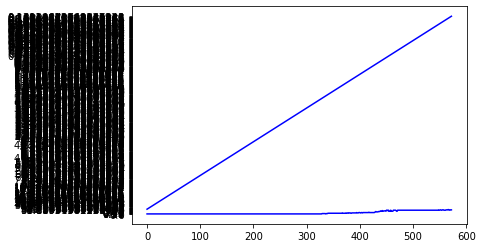

In [30]:
x= [i for i in range(0,len(acc))]
plt.plot(x,acc,color = 'b',label="acc")
plt.plot(x,losses,color = 'b',label="loss")
print(losses[len(losses)-1])
print(losses)

In [ ]:
record_losses=losses
record_time = times
record_acc = acc

In [ ]:
# params = list(model.parameters())
# k = 0
# count = 0
# for i in params:
#     print('第',count,"层：")
#     l = 1
#     print("该层的结构：" + str(list(i.size())))
#     for j in i.size():
#         l *= j
#     print("该层参数和：" + str(l))
#     k = k + l
#     count = count+1
